# Initialize

In [ ]:
import sys
sys.path.insert(0, "Source")

from setGPUs import setGPUs
GPU_numbers = [0]#[0,1]
GPU_names = setGPUs(GPU_numbers)
print(GPU_names)

import gc
import pickle
from multiprocessing import Pool

%matplotlib inline
import matplotlib

import psutil
from jupyterthemes import jtplot
from scipy import stats

import DNNLikelihood
import mcmc
import toy_likelihood
from DNNLikelihood import *
from mcmc import *
from toy_likelihood import *

fig_dir = 'Figures/'
jtplot.reset()

# Unbiased sampling $S_{1}$

## Sampler

In [ ]:
for j in range(11):
    NEW_SAMPLING = True
    INITIALIZE_IN_BALL = False
    logprob_fn = logprob
    #sampler = import_sampler('sampling_lik_emcee')
    
    # sampler inputs
    ndim, nwalkers, nsteps = 95, 1000, 1000000
    
    # Initialize backend
    filename = "Data_samples/likelihood_unbiased_sm_13_"+str(j)+".h5"
    chainsname = 'toy_likelihood'
    backend = emcee.backends.HDFBackend(filename, name=chainsname)
    if NEW_SAMPLING:
        # starting value of parameters
        if INITIALIZE_IN_BALL:
            start = timer()
            maxlik = minimize(lambda delta: -logprob(delta), np.full(95,0),method='Powell')
            p0 =  [maxlik['x']+0.01*np.insert(np.random.normal(0,1,94),0,np.random.uniform(-1,5)) for i in range(nwalkers)]
            end = timer()
            print("Initialization around maximum likelihood performed in",end-start,"s.")
            #print(np.sort([[logprob(x),x[0]] for x in result],axis=0))
        else:
            p0 = [np.full(95,0)+np.insert(np.random.normal(0,1,94),0,np.random.uniform(-1,5)) for i in range(nwalkers)]
        backend.reset(nwalkers, ndim)
    else:
        p0 = backend.get_last_sample()
    print("Initial number of steps: {0}".format(backend.iteration))
    
    moves = emcee.moves.StretchMove(1.3)
    
    n_processes = psutil.cpu_count(logical=False)
    if NEW_SAMPLING:
        for i in range(n_processes,n_processes+1,2):
            if __name__ ==  '__main__': 
                print('Running ', i,' parallel processes.')
                start = timer()
                with Pool(i) as pool:
                    sampler = emcee.EnsembleSampler(nwalkers, ndim, logprob_fn, moves=moves, pool=pool, backend=backend)
                    sampler.run_mcmc(p0, nsteps, progress=True)
                end = timer()
                print('Done in ',end-start,'seconds')
    else:
        for i in range(n_processes,n_processes+1,2):
            if __name__ ==  '__main__': 
                print('Running ', i,' parallel processes.')
                start = timer()
                with Pool(i) as pool:
                    sampler = emcee.EnsembleSampler(nwalkers, ndim, logprob_fn, moves=moves, pool=pool, backend=backend)
                    sampler.run_mcmc(None, nsteps, progress=True)
                end = timer()
                print('Done in ',end-start,'seconds')
    print("Final number of steps: {0}".format(backend.iteration))

In [ ]:
start = timer()
chains = sampler.get_chain()
logprobs = sampler.get_log_prob()
res_shape = np.shape(chains)
nsteps, nwalkers, ndim = np.shape(chains)
end = timer()
print('Chains have shape', res_shape,'\nThere are',res_shape[1],'chains of',res_shape[0],'steps in',res_shape[2],'dimensions.\nLoaded in',end-start,"s.")
del(res_shape)

## Sampling results

### Chains plots

In [ ]:
start = timer()
filename = "Data_samples/likelihood_unbiased_sm_13_1.h5"
chainsname = 'toy_likelihood'
backend = import_sampler(filename,chainsname)
f = h5py.File(filename, 'r')[chainsname]
nsteps = f.attrs["iteration"]
keys = f.keys()
chains_samp = f.get("chain")[:,:,0:1]
chains_lp = f.get("log_prob")
res_shape = np.shape(chains_samp)
nsteps, nwalkers, ndim = np.shape(chains_samp)
end = timer()
print('Chains have shape', res_shape,'\nThere are',res_shape[1],'chains of',res_shape[0],'steps in',res_shape[2],'dimensions.\nLoaded in',end-start,"s.")

In [ ]:
rnd_chains = np.sort(np.random.choice(np.arange(1000),100,replace=False))
rnd_chains

In [ ]:
idx = np.sort([(i)*(10**j) for i in range(1,11) for j in range(10)])
idx = np.unique(idx[idx<len(chains_lp)])
jtplot.reset()
plt.style.use('matplotlib.mplstyle')
plt.plot(idx,-chains_lp[:,rnd_chains][idx], '-', alpha=0.8)
plt.grid(linestyle="--", dashes=(5,5))
plt.xlabel(r"step")
plt.ylabel(r"$-\log\mathcal{L}$")
plt.xscale('log')
x1,x2,y1,y2 = plt.axis()
plt.axis([x1, x2, 295, 505])
plt.tight_layout()
#plt.savefig(fig_dir + "chains_sm_loglik.pdf",quality=50)
plt.show()

In [ ]:
idx = np.sort([(i)*(10**j) for i in range(1,11) for j in range(10)])
idx = np.unique(idx[idx<len(chains_samp)])
chain = chains_samp[:,:,0]
jtplot.reset()
plt.style.use('matplotlib.mplstyle')
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.plot(idx,chain[idx][:,rnd_chains], '-', alpha=0.8)
plt.grid(linestyle="--", dashes=(5,5))
plt.xlabel(r"step")
plt.ylabel(r"$\mu$")
plt.xscale('log')
plt.tight_layout()
plt.savefig(fig_dir + "chains_sm.pdf")
plt.show()

### Convergence: Integrated Autocorrelation Time (IAT)

In [ ]:
start = timer()
filename = "Data_samples/likelihood_unbiased_sm_13_1.h5"
chainsname = 'toy_likelihood'
backend = import_sampler(filename,chainsname)
f = h5py.File(filename, 'r')[chainsname]
nsteps = f.attrs["iteration"]
keys = f.keys()
chains_samp = f.get("chain")[:,:,0:1]
res_shape = np.shape(chains_samp)
nsteps, nwalkers, ndim = np.shape(chains_samp)
allsamples = chains_samp.reshape([nsteps*nwalkers,ndim])
end = timer()
print('Chains have shape', res_shape,'\nThere are',res_shape[1],'chains of',res_shape[0],'steps in',res_shape[2],'dimensions.\nLoaded in',end-start,"s.")

In [ ]:
jtplot.reset()
plt.style.use('matplotlib.mplstyle')
start = timer()
show_dist_and_autocorr(chains_samp[:,:,:],[0], labels, save=fig_dir+"figure_autocorr_dist.pdf", methods=["G&W 2010", "DFM 2017"])#'../paper/figs/figure_autocorr.pdf')#'../paper/figs/figure_autocorr.pdf')#'../paper/figs/figure_autocorr.pdf')
end = timer()
print("Distribution and autocorrelation time plots done and saved in",end-start,"s.")

In [ ]:
start = timer()
chain = chains_samp[:, :, 0].T
print([autocorr_gw2010(chain),autocorr_new(chain)])
end = timer()
print(end-start)

### Convergence: Gelman-Rubin
Before running should run the sampler 50 times with 200 walkers for 30000 steps (use code in Sec. 2.1)

#### From multiple samplers

In [ ]:
rnd_chains = np.sort(np.random.choice(np.arange(200),4,replace=False))
rnd_chains

In [ ]:
start_global = timer()
for n in range(50):
    start = timer()
    #filename = r"D:/chains/toy_likelihood_unbiased_sm_13_gelrub_"+str(n)+".h5"
    filename = "Data_samples/likelihood_unbiased_sm_13_gelrub_"+str(n)+".h5"
    chainsname = 'toy_likelihood'
    f = h5py.File(filename, 'r')[chainsname]
    nsteps = f.attrs["iteration"]
    keys = f.keys()
    if n==0:
        chains_samp = f.get("chain")[:,rnd_chains]
    if n>0:
        chains_samp_tmp = f.get("chain")[:,rnd_chains]
        chains_samp = np.concatenate((chains_samp,chains_samp_tmp),axis=1)
    res_shape = np.shape(chains_samp)
    nsteps, nwalkers, ndim = np.shape(chains_samp)
    end = timer()
    print('Chains have shape', res_shape,'\nThere are',res_shape[1],'chains of',res_shape[0],'steps in',res_shape[2],'dimensions.\nLoaded in',end-start,"s.")
end_global = timer()
print('Chains have shape', res_shape,'\nThere are',res_shape[1],'chains of',res_shape[0],'steps in',res_shape[2],'dimensions.\nLoaded in',end_global-start_global,"s.")

In [ ]:
start = timer()
res = gelman_rubin(chains_samp[:,:,0])
end = timer()
print(end-start)
res

In [ ]:
start = timer()
xcoord = np.sort(np.array([[i*10**j for i in range(1,10)] for j in range(2,5)]).flatten())
res = [gelman_rubin(chains_samp[0:i,:,:]) for i in xcoord[4:-6]]
R = np.array([i[0] for i in res])
sqrtVhat = np.sqrt([i[1] for i in res])
sqrtW = np.sqrt([i[2] for i in res])
end = timer()
print(end-start)

In [ ]:
jtplot.reset()
plt.style.use('matplotlib.mplstyle')
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.grid(linestyle="--", dashes=(5, 5))
plt.plot(xcoord[4:-6],R)
plt.xlim(500, 30000)
plt.ylim(0.95,2.45)
plt.xscale('log')
plt.xlabel(r"number of steps, $S$")
plt.ylabel(r"$\hat{R}_{c}$")
ax = plt.axes()
plt.text(0.5,0.9,"4 walkers from 50 samplers", fontsize=22, transform = ax.transAxes, ha='center',ma='left')
plt.tight_layout()
plt.savefig(fig_dir + "Gelman-Rubin_R_many_samplers.pdf",quality=50)
plt.show()

In [ ]:
jtplot.reset()
plt.style.use('matplotlib.mplstyle')
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.grid(linestyle="--", dashes=(5, 5))
plt.plot(xcoord[4:-6],sqrtVhat)
plt.xlim(500, 30000)
plt.ylim(0.3,1.1)
plt.xscale('log')
plt.xlabel(r"number of steps, $S$")
plt.ylabel(r"$\sqrt{\hat{V}}$")
ax = plt.axes()
plt.text(0.5,0.6,"4 walkers from 50 samplers", fontsize=22, transform = ax.transAxes, ha='center',ma='left')
plt.tight_layout()
plt.savefig(fig_dir + "Gelman-Rubin_Vhat_many_samplers.pdf",quality=50)
plt.show()

In [ ]:
jtplot.reset()
plt.style.use('matplotlib.mplstyle')
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.grid(linestyle="--", dashes=(5, 5))
plt.plot(xcoord[4:-6],sqrtW)
plt.xlim(500, 30000)
plt.ylim(0.25,1)
plt.xscale('log')
plt.xlabel(r"number of steps, $S$")
plt.ylabel(r"$\sqrt{W}$")
ax = plt.axes()
plt.text(0.33,0.9,"4 walkers from 50 samplers", fontsize=22, transform = ax.transAxes, ha='center',ma='left')
plt.tight_layout()
plt.savefig(fig_dir + "Gelman-Rubin_W_many_samplers.pdf",quality=50)
plt.show()

#### From single sampler

In [ ]:
start = timer()
#filename = r"D:/chains/toy_likelihood_unbiased_sm_13_gelrub_0.h5"
filename = "Data_samples/likelihood_unbiased_sm_13_gelrub_0.h5"
chainsname = 'toy_likelihood'
f = h5py.File(filename, 'r')[chainsname]
nsteps = f.attrs["iteration"]
keys = f.keys()
chains_samp_0 = f.get("chain")[:]
res_shape = np.shape(chains_samp_0)
nsteps, nwalkers, ndim = np.shape(chains_samp_0)
end = timer()

In [ ]:
start = timer()
xcoord = np.sort(np.array([[i*10**j for i in range(1,10)] for j in range(2,5)]).flatten())
res = [gelman_rubin(chains_samp_0[0:i,:,:]) for i in xcoord[4:-6]]
R = [i[0] for i in res]
sqrtVhat = np.sqrt([i[1] for i in res])
sqrtW = np.sqrt([i[2] for i in res])
end = timer()
print(end-start)

In [ ]:
jtplot.reset()
plt.style.use('matplotlib.mplstyle')
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.grid(linestyle="--", dashes=(5, 5))
plt.plot(xcoord[4:-6],R)
plt.xlim(500, 30000)
plt.ylim(0.95,2.45)
plt.xscale('log')
plt.xlabel(r"number of steps, $S$")
plt.ylabel(r"$\hat{R}_{c}$")
ax = plt.axes()
plt.text(0.5,0.9,"200 walkers from 1 sampler", fontsize=22, transform = ax.transAxes, ha='center',ma='left')
plt.tight_layout()
plt.savefig(fig_dir + "Gelman-Rubin_R_one_sampler.pdf",quality=50)
plt.show()

In [ ]:
jtplot.reset()
plt.style.use('matplotlib.mplstyle')
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.grid(linestyle="--", dashes=(5, 5))
plt.plot(xcoord[4:-6],sqrtVhat)
plt.xlim(500, 30000)
plt.ylim(0.3,1.1)
plt.xscale('log')
plt.xlabel(r"number of steps, $S$")
plt.ylabel(r"$\sqrt{\hat{V}}$")
ax = plt.axes()
plt.text(0.5,0.6,"200 walkers from 1 sampler", fontsize=22, transform = ax.transAxes, ha='center',ma='left')
plt.tight_layout()
plt.savefig(fig_dir + "Gelman-Rubin_Vhat_one_sampler.pdf",quality=50)
plt.show()

In [ ]:
jtplot.reset()
plt.style.use('matplotlib.mplstyle')
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.grid(linestyle="--", dashes=(5, 5))
plt.plot(xcoord[4:-6],sqrtW)
plt.xlim(500, 30000)
plt.ylim(0.25,1)
plt.xscale('log')
plt.xlabel(r"number of steps, $S$")
plt.ylabel(r"$\sqrt{W}$")
ax = plt.axes()
plt.text(0.33,0.9,"200 walkers from 1 sampler", fontsize=22, transform = ax.transAxes, ha='center',ma='left')
plt.tight_layout()
plt.savefig(fig_dir + "Gelman-Rubin_W_one_sampler.pdf",quality=50)
plt.show()

## Extract samples with thin=1000 (independent samples) and save them

In [ ]:
for j in range(11):
    "likelihood_unbiased_sm_13_"
    filename = "Data_samples/likelihood_unbiased_sm_13_"+str(j)".h5"
    chainsname = 'toy_likelihood'
    start = timer()
    backend = import_sampler(filename,chainsname)
    allsamples = backend.get_chain(discard=5000,thin=1000,flat=True)
    logprob_values = backend.get_log_prob(discard=5000,thin=1000,flat=True)
    end = timer()
    print(len(allsamples),"independent samples extracted in", end-start, "s.")
    samples_file = "Data_samples/likelihood_unbiased_sm_13_"+str(j)"_thinned1000.pickle"
    pickle_out = open(samples_file, 'wb')
    start = timer()
    pickle.dump(allsamples, pickle_out, protocol=4)
    pickle.dump(logprob_values, pickle_out, protocol=4)
    end = timer()
    pickle_out.close()
    statinfo = os.stat(samples_file)
    print('File saved in ',end-start,' seconds.\nFile size is ',statinfo.st_size,'.')

In [ ]:
#samples_file = '../../bigfiles/likelihood_unbiased_sm_13_11_thinned1000'
#pickle_in = open(samples_file,'rb')
#start = timer()
#statinfo = os.stat(samples_file)
#allsamples_train = pickle.load(pickle_in)
#logprob_values_train = pickle.load(pickle_in)
#end = timer()
#pickle_in.close()
#print('File loaded in ',end-start,' seconds.\nFile size is ',statinfo.st_size,'.')

In [ ]:
start_global = timer()
samples_files = ["Data_samples/likelihood_unbiased_sm_13_"+str(j)+"_thinned1000.pickle" for j in range(11)]
i=1
for samples_file in samples_files:
    start = timer()
    pickle_in = open(samples_file,'rb')
    statinfo = os.stat(samples_file)
    if i==1:
        allsamples = pickle.load(pickle_in)
        logprob_values = pickle.load(pickle_in)
        end = timer()
        print(len(allsamples),"samples from file",samples_file,"loaded in",end-start,"seconds. Samples added to array.")
    if i > 1:# and i < len(samples_files):
        allsamples_tmp = pickle.load(pickle_in)
        logprob_values_tmp = pickle.load(pickle_in)
        allsamples = np.concatenate((allsamples,allsamples_tmp))
        logprob_values = np.concatenate((logprob_values,logprob_values_tmp))
        end = timer()
        print(len(allsamples_tmp),"samples from file",samples_file,"loaded in",end-start,"seconds. Samples added to array.")
        del(allsamples_tmp,logprob_values_tmp)
    i = i+1
    pickle_in.close()
    end = timer()
allsamples_test = allsamples[-1000000:]
logprob_values_test = logprob_values[-1000000:]
allsamples_train = allsamples[:-1000000]
logprob_values_train = logprob_values[:-1000000]
end_global = timer()
print(len(allsamples_train),"training samples and",len(allsamples_test),"test samples obtained in",end_global-start_global,"s.")

In [ ]:
nnn = len(allsamples_train)
nnnn = len(allsamples_test)
n_processes = psutil.cpu_count(logical=False)
if __name__ ==  '__main__': 
    print('Running ', n_processes,' parallel processes.')
    start = timer()
    with Pool(n_processes) as pool:
        logprior_values_train = np.array(pool.map(logprior,allsamples_train[0:nnn]))
        logprior_values_test = np.array(pool.map(logprior,allsamples_test[0:nnnn]))
    end = timer()
    print(end-start)
loglik_values_train = logprob_values_train-logprior_values_train
loglik_values_test = logprob_values_test-logprior_values_test
## Check
if not np.prod(np.isclose(loglik_values_train[0:1000],np.array(list(map(loglik,allsamples_train[0:1000]))),rtol=1e-15,atol=0)):
    print("There's something wrong with loglik_values_train")
else:
    print("loglik_values_train correct within numerical relative accuracy (10^-15)")
if not np.prod(np.isclose(loglik_values_test[0:1000],np.array(list(map(loglik,allsamples_test[0:1000]))),rtol=1e-15,atol=0)):
    print("There's something wrong with loglik_values_train")
else:
    print("loglik_values_test correct within numerical relative accuracy (10^-15)")

In [ ]:
samples_file = "Data_samples/likelihood_unbiased_sm_13_thinned1000_11M.pickle"
pickle_out = open(samples_file, 'wb')
start = timer()
pickle.dump(allsamples_train, pickle_out, protocol=4)
pickle.dump(logprob_values_train, pickle_out, protocol=4)
pickle.dump(loglik_values_train, pickle_out, protocol=4)
pickle.dump(logprior_values_train, pickle_out, protocol=4)
pickle.dump(allsamples_test, pickle_out, protocol=4)
pickle.dump(logprob_values_test, pickle_out, protocol=4)
pickle.dump(loglik_values_test, pickle_out, protocol=4)
pickle.dump(logprior_values_test, pickle_out, protocol=4)
end = timer()
pickle_out.close()
statinfo = os.stat(samples_file)
print('File saved in',end-start,'seconds.\nFile size is',statinfo.st_size,'.')

## Bayesian Inference

In [ ]:
samples_file = "Data_samples/likelihood_unbiased_sm_13_thinned1000_11M.pickle"
pickle_in = open(samples_file,'rb')
start = timer()
statinfo = os.stat(samples_file)
allsamples_train = pickle.load(pickle_in)
logprob_values_train = pickle.load(pickle_in)
_ = pickle.load(pickle_in)
_ = pickle.load(pickle_in)
allsamples_test = pickle.load(pickle_in)
logprob_values_test = pickle.load(pickle_in)
_ = pickle.load(pickle_in)
_ = pickle.load(pickle_in)
end = timer()
pickle_in.close()
print('File loaded in ',end-start,' seconds.\nFile size is ',statinfo.st_size,'.')

In [ ]:
start= timer()
nbins = 60
sigma_contours = [1,2,3]
HPI_intervals1_all = HPD_intervals(allsamples_train[:,0], intervals = get_CI_from_sigma(sigma_contours), weights=None, nbins=nbins, print_hist=False, reduce_binning=True)
HPI_intervals1_pos = HPD_intervals(allsamples_train[:,0][allsamples_train[:,0]>0], intervals = get_CI_from_sigma(sigma_contours), weights=None, nbins=nbins, print_hist=False, reduce_binning=True)
end = timer()
print(end-start)

In [ ]:
print(HPI_intervals1_all, "\n",HPI_intervals1_pos)

In [ ]:
#Value of mu with highest marginal 1D probability (Bayesian)
print(np.mean(allsamples_train[:,0]))
#Value of mu in maximum likelihood point (frequentist)
print(minimize(minus_logprob,np.full(95,0),method='Powell')['x'][0])

In [8]:
start = timer()
nnn1 = len(allsamples_train)#len(allsamples_train)#
nnn2 = len(allsamples_test)#len(allsamples_test)#
ilist = [0,50,91,92,93,94]
nndim = len(ilist)
nbins = 60
s1 = allsamples_train
s2 = allsamples_test
rnd_indices_1 = np.random.choice(np.arange(len(s1)),size=nnn1,replace=False)
rnd_indices_2 = np.random.choice(np.arange(len(s2)),size=nnn2,replace=False)
samp_1 = s1[rnd_indices_1][:,ilist]
samp_2 = s2[rnd_indices_2][:,ilist]
ranges = extend_corner_range(s1,s2,ilist,0)
sigma_contours = [1,2,3]
HPI_intervals1 = [HPD_intervals(samp_1[:,i], intervals = get_CI_from_sigma(sigma_contours), weights=None, nbins=nbins, print_hist=False, reduce_binning=True) for i in range(nndim)]
HPI_intervals2 = [HPD_intervals(samp_2[:,i], intervals = get_CI_from_sigma(sigma_contours), weights=None, nbins=nbins, print_hist=False, reduce_binning=True) for i in range(nndim)]
levels1 = np.array([[np.sort(HPD_quotas(samp_1[:,[i,j]], nbins=nbins, intervals = get_CI_from_sigma(sigma_contours))).tolist() for j in range(nndim)] for i in range(nndim)])
levels2 = np.array([[np.sort(HPD_quotas(samp_2[:,[i,j]], nbins=nbins, intervals = get_CI_from_sigma(sigma_contours), weights=None)).tolist() for j in range(nndim)] for i in range(nndim)])
end = timer()
print(end-start)

545.4544925


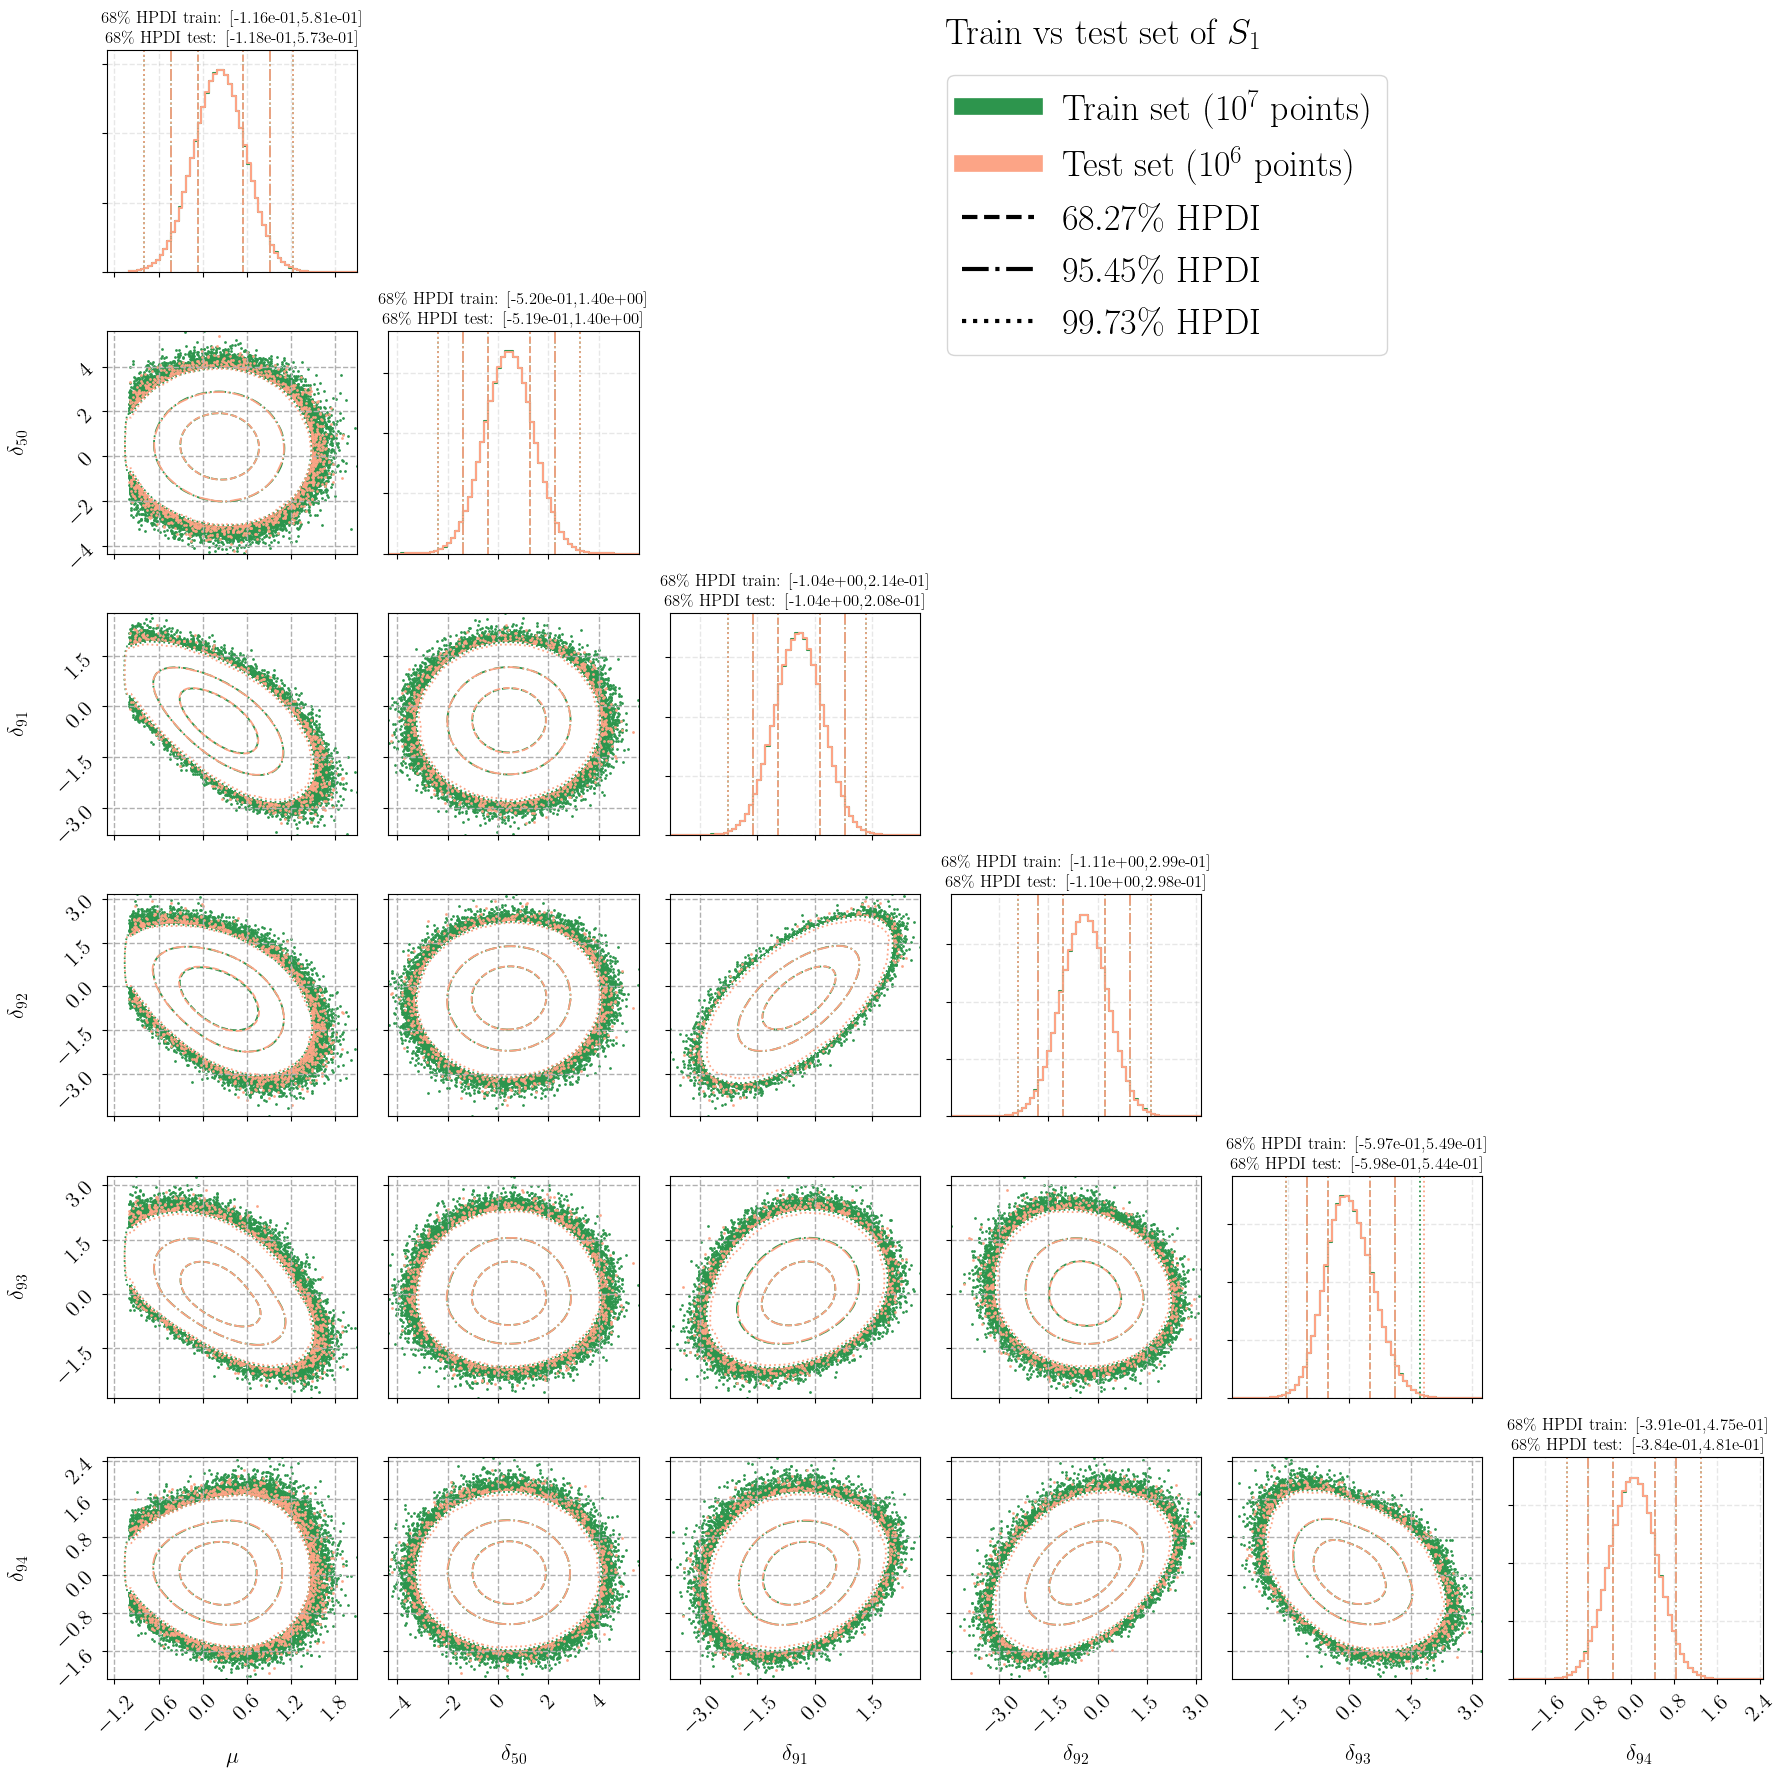

Plot done and saved in 445.2295429999999 s.


In [9]:
plot_corners(ilist, nbins, samp_1, samp_2, w1=None, w2=None, levels1=levels1, levels2=levels2, HPI_intervals1=HPI_intervals1, HPI_intervals2=HPI_intervals2, 
             ranges=ranges, title1="$68\%$ HPDI train", title2="$68\%$ HPDI test", color1=greens[-9], color2=reds[9], plot_title="Train vs test set of $S_{1}$", 
             legend_labels = [r"Train set ($10^{7}$ points)",r"Test set ($10^{6}$ points)",r'$68.27\%$ HPDI', r'$95.45\%$ HPDI', r'$99.73\%$ HPDI'], figdir=fig_dir, figname="corner_toy_lik_params_new.pdf")

# The Bayesian DNNLikelihood

## Perform training scan and saving results

In [ ]:
N_RUNS = 5
ACT_FUNC_OUT_LAYER_LIST = ['linear']
BATCH_NORM_LIST = [False]
CONTINUE_TRAINING = False
DROPOUT_RATE_LIST = [0]
EARLY_STOPPING = True
FILE_SAMPLES_LIST = ["Data_samples/likelihood_unbiased_sm_13_thinned1000_11M.pickle"]
FOLDER = 'DNNLikelihoods/'
FREQUENTISTS_RESULTS = False
GENERATE_DATA = True
# This also automatically sets GENERATE_DATA = True
GENERATE_DATA_ON_THE_FLY = False
HID_LAYERS_LIST = [
                  [[500, 'selu'], [500, 'selu']],
                  [[1000, 'selu'], [1000, 'selu']],
                  [[2000, 'selu'], [2000, 'selu']],
                  [[5000, 'selu'], [5000, 'selu']]
                  ]
LABELS = [r"$\mu$"]+[r"$\delta_{%d}$" % i for i in range(1, 95)]
LEARNING_RATE_LIST = [10**(-3)]
LOAD_MODEL = 'None'
LOGPROB_THRESHOLD = -1*np.inf
LOSS_LIST = ['mse']
METRICS = ['mse', 'mae', 'mape', 'me', 'mpe']
MODEL_CHEKPOINT = False
MONITORED_METRIC = 'mse'
MULTI_GPU = False
N_EPOCHS = 15
NEVENTS_TRAIN_LIST = [100000,200000,500000]
BATCH_SIZE_LIST = [int(closest_power2(x/200)) for x in NEVENTS_TRAIN_LIST]
MIN_DELTA_LIST = [1/x for x in NEVENTS_TRAIN_LIST]
PARS = [0, 3, 6, 30, 61, 85]
PLOTLOSSES = False
REDUCE_LR = True
REDUCE_LR_PATIENCE_LIST = [40]
SCALE_X = False
SCALE_Y = True
TEST_FRACTION = 0.5
VALIDATION_FRACTION = 0.5
WEIGHT_SAMPLES_LIST = [False]

#From previous run
try:
    [allsamples_train, logprob_values_train, allsamples_test, logprob_values_test] = [allsamples_train, logprob_values_train, allsamples_test, logprob_values_test]
except:
    [allsamples_train, logprob_values_train, allsamples_test,logprob_values_test] = ['None', 'None', 'None', 'None']
try:
    [rnd_indices_train, rnd_indices_val, rnd_indices_test] = [rnd_indices_train, rnd_indices_val, rnd_indices_test]
except:
    [rnd_indices_train, rnd_indices_val, rnd_indices_test] = ['None', 'None', 'None']
try:
    LOGPROB_THRESHOLD_INDICES_TRAIN, LOGPROB_THRESHOLD_INDICES_TEST = [LOGPROB_THRESHOLD_INDICES_TRAIN, LOGPROB_THRESHOLD_INDICES_TEST]
except:
    LOGPROB_THRESHOLD_INDICES_TRAIN, LOGPROB_THRESHOLD_INDICES_TEST = ['None', 'None']
try:
    [X_train, X_val, X_test, Y_train, Y_val, Y_test, W_train, W_val] = [X_train, X_val, X_test, Y_train, Y_val, Y_test, W_train, W_val]
except:
    [X_train, X_val, X_test, Y_train, Y_val, Y_test, W_train, W_val] = ['None', 'None', 'None', 'None', 'None', 'None', 'None', 'None']
try:
    [scalerX, scalerY] = [scalerX, scalerY]
except:
    [scalerX, scalerY] = ['None', 'None']
try:
    model = model
    training_model = training_model
except:
    model = 'None'
    training_model = 'None'
try:
    summary_log = summary_log
    history = history
    training_time = training_time
except:
    summary_log = 'None'
    history = 'None'
    training_time = 'None'
    

[allsamples_train, logprob_values_train, allsamples_test, logprob_values_test, LOGPROB_THRESHOLD_INDICES_TRAIN, LOGPROB_THRESHOLD_INDICES_TEST, rnd_indices_train, rnd_indices_val, rnd_indices_test, X_train, X_val, X_test, Y_train, Y_val, Y_test, W_train,
 W_val, scalerX, scalerY, model, training_model, summary_log, history, training_time] = model_training_scan(N_RUNS, ACT_FUNC_OUT_LAYER_LIST,
                                                                                                            BATCH_NORM_LIST, BATCH_SIZE_LIST, CONTINUE_TRAINING, DROPOUT_RATE_LIST, EARLY_STOPPING, FILE_SAMPLES_LIST, FOLDER, FREQUENTISTS_RESULTS, GENERATE_DATA,
                                                                                                            GENERATE_DATA_ON_THE_FLY, GPU_names, HID_LAYERS_LIST, LABELS, LEARNING_RATE_LIST, LOAD_MODEL, LOGPROB_THRESHOLD, LOGPROB_THRESHOLD_INDICES_TRAIN, LOGPROB_THRESHOLD_INDICES_TEST, LOSS_LIST, METRICS, MIN_DELTA_LIST, MODEL_CHEKPOINT, MONITORED_METRIC, MULTI_GPU, N_EPOCHS, NEVENTS_TRAIN_LIST,
                                                                                                            PARS, PLOTLOSSES, REDUCE_LR, REDUCE_LR_PATIENCE_LIST, SCALE_X, SCALE_Y, TEST_FRACTION, VALIDATION_FRACTION, WEIGHT_SAMPLES_LIST, allsamples_train, logprob_values_train, allsamples_test, logprob_values_test,
                                                                                                            rnd_indices_train, rnd_indices_val, rnd_indices_test, X_train, X_val, X_test, Y_train, Y_val, Y_test, W_train, W_val, scalerX, scalerY, model, training_model, summary_log, history, training_time)

## Compare and choose best models

In [ ]:
mydataframe = import_results(["DNNLikelihoods/"])
mydataframe2 = import_model(["DNNLikelihoods/"])
for key in mydataframe2.keys():
    mydataframe[key]=mydataframe2[key]
del(mydataframe2)
for key in mydataframe.keys():
    mydataframe[metric_name_abbreviate(key)] = mydataframe.pop(key)
mydataframe = mydataframe.sort_values(by=['test_loss_best'])
mydataframe.info()
mydataframe.describe()

In [ ]:
cols_to_print = np.sort(['1$\sigma$ HPI rel err test', '1$\sigma$ HPI rel err train',
       '1$\sigma$ HPI rel err train-test', '1$\sigma$ HPI rel err val',
       'AF out', 'Batch size', 'Date time', 'Dropout',
       'Early stopping', 'Epochs', 'GPU(s)', 'Hidden layers',
       'KS test-pred_train median', 'KS test-pred_val median', 'KS train-test median', 
       'KS val-pred_test median', 'Min_delta',
       'Name', 'Ndim', 'Nevt-train', 'Nevt-val',
       'Number', 'Optimizer', 'Params', 'Prediction time',
       'Reduce LR patience',
       'Trainable params', 'Training time', 'Weighted', 'loss_best',
       'loss_best_scaled', 'mae_best', 'mae_best_scaled', 'mape_best',
       'mape_best_scaled', 'me_best', 'me_best_scaled', 'mpe_best',
       'mpe_best_scaled', 'mse_best','mse_best_scaled', 
       'test_loss_best', 'test_loss_best_scaled', 'test_mae_best', 'test_mae_best_scaled',
       'test_mape_best', 'test_mape_best_scaled', 'test_me_best', 'test_me_best_scaled',
       'test_mpe_best', 'test_mpe_best_scaled', 'test_mse_best', 'test_mse_best_scaled',
       'val_loss_best', 'val_loss_best_scaled', 'val_mae_best', 'val_mae_best_scaled',
       'val_mape_best', 'val_mape_best_scaled', 'val_me_best', 'val_me_best_scaled', 
       'val_mpe_best', 'val_mpe_best_scaled', 'val_mse_best', 'val_mse_best_scaled'])

In [ ]:
df0100 = DataFrame(mydataframe[mydataframe["Nevt-train"]==100000].reindex(columns=cols_to_print))
df0200 = DataFrame(mydataframe[mydataframe["Nevt-train"]==200000].reindex(columns=cols_to_print))
df0500 = DataFrame(mydataframe[mydataframe["Nevt-train"]==500000].reindex(columns=cols_to_print))

In [ ]:
sortby(df0100,column_max='KS val-pred_test median',color_min='Green',color_max='Red',highlights_min=['loss_best','mse_best', 'mae_best', 'mape_best', 'me_best', 'mpe_best',
                           'val_loss_best', 'val_mse_best', 'val_mae_best', 'val_mape_best', 'val_me_best', 'val_mpe_best',
                           'test_loss_best', 'test_mse_best', 'test_mae_best', 'test_mape_best', 'test_me_best', 'test_mpe_best'],highlights_max=['KS test-pred_train median',
       'KS test-pred_val median', 'KS val-pred_test median', 'KS train-test median'])

In [ ]:
print('Name:', df0100.iloc[[1]]['Name'].to_numpy()[0])
print('Epochs:', df0100.iloc[[1]]['Epochs'].to_numpy()[0])
print('Best loss train:', df0100.iloc[[1]]['mse_best'].to_numpy()[0])
print('Best loss val:', df0100.iloc[[1]]['val_mse_best'].to_numpy()[0])
print('Best loss test:', df0100.iloc[[1]]['test_mse_best'].to_numpy()[0])
print('Best ME train:', df0100.iloc[[1]]['me_best'].to_numpy()[0])
print('Best ME val:', df0100.iloc[[1]]['val_me_best'].to_numpy()[0])
print('Best ME test:', df0100.iloc[[1]]['test_me_best'].to_numpy()[0])
print('Median 1D K-S test/pred-train:',df0100.iloc[[1]]['KS test-pred_train median'].to_numpy()[0])
print('Median 1D K-S test/pred-val:',df0100.iloc[[1]]['KS test-pred_val median'].to_numpy()[0])
print('Median 1D K-S val/pred-test:',df0100.iloc[[1]]['KS val-pred_test median'].to_numpy()[0])
print('Training time:',df0100.iloc[[3]]['Training time'].to_numpy()[0])
print('Prediction time:',df0100.iloc[[3]]['Prediction time'].to_numpy()[0]/df0100.iloc[[3]]['Nevt-val'].to_numpy()[0])

In [ ]:
sortby(df0200,column_max='KS val-pred_test median',color_min='Green',color_max='Red',highlights_min=['loss_best','mse_best', 'mae_best', 'mape_best', 'me_best', 'mpe_best',
                           'val_loss_best', 'val_mse_best', 'val_mae_best', 'val_mape_best', 'val_me_best', 'val_mpe_best',
                           'test_loss_best', 'test_mse_best', 'test_mae_best', 'test_mape_best', 'test_me_best', 'test_mpe_best'],highlights_max=['KS test-pred_train median',
       'KS test-pred_val median', 'KS val-pred_test median', 'KS train-test median'])

In [ ]:
print('Name:', df0200.iloc[[1]]['Name'].to_numpy()[0])
print('Epochs:', df0200.iloc[[0]]['Epochs'].to_numpy()[0])
print('Best loss train:', df0200.iloc[[0]]['mse_best'].to_numpy()[0])
print('Best loss val:', df0200.iloc[[0]]['val_mse_best'].to_numpy()[0])
print('Best loss test:', df0200.iloc[[0]]['test_mse_best'].to_numpy()[0])
print('Best ME train:', df0200.iloc[[0]]['me_best'].to_numpy()[0])
print('Best ME val:', df0200.iloc[[0]]['val_me_best'].to_numpy()[0])
print('Best ME test:', df0200.iloc[[0]]['test_me_best'].to_numpy()[0])
print('Median 1D K-S test/pred-train:',df0200.iloc[[0]]['KS test-pred_train median'].to_numpy()[0])
print('Median 1D K-S test/pred-val:',df0200.iloc[[0]]['KS test-pred_val median'].to_numpy()[0])
print('Median 1D K-S val/pred-test:',df0200.iloc[[0]]['KS val-pred_test median'].to_numpy()[0])
print('Training time:',df0200.iloc[[0]]['Training time'].to_numpy()[0])
print('Prediction time:',df0200.iloc[[0]]['Prediction time'].to_numpy()[0]/df0200.iloc[[0]]['Nevt-val'].to_numpy()[0])

In [ ]:
sortby(df0500,column_max='KS val-pred_test median',color_min='Green',color_max='Red',highlights_min=['loss_best','mse_best', 'mae_best', 'mape_best', 'me_best', 'mpe_best',
                           'val_loss_best', 'val_mse_best', 'val_mae_best', 'val_mape_best', 'val_me_best', 'val_mpe_best',
                           'test_loss_best', 'test_mse_best', 'test_mae_best', 'test_mape_best', 'test_me_best', 'test_mpe_best'],highlights_max=['KS test-pred_train median',
       'KS test-pred_val median', 'KS val-pred_test median', 'KS train-test median'])

In [ ]:
print('Name:', df0500.iloc[[0]]['Name'].to_numpy()[0])
print('Epochs:', df0500.iloc[[0]]['Epochs'].to_numpy()[0])
print('Best loss train:', df0500.iloc[[0]]['mse_best'].to_numpy()[0])
print('Best loss val:', df0500.iloc[[0]]['val_mse_best'].to_numpy()[0])
print('Best loss test:', df0500.iloc[[0]]['test_mse_best'].to_numpy()[0])
print('Best ME train:', df0500.iloc[[0]]['me_best'].to_numpy()[0])
print('Best ME val:', df0500.iloc[[0]]['val_me_best'].to_numpy()[0])
print('Best ME test:', df0500.iloc[[0]]['test_me_best'].to_numpy()[0])
print('Median 1D K-S test/pred-train:',df0500.iloc[[0]]['KS test-pred_train median'].to_numpy()[0])
print('Median 1D K-S test/pred-val:',df0500.iloc[[0]]['KS test-pred_val median'].to_numpy()[0])
print('Median 1D K-S val/pred-test:',df0500.iloc[[0]]['KS val-pred_test median'].to_numpy()[0])
print('Training time:',df0500.iloc[[1]]['Training time'].to_numpy()[0])
print('Prediction time:',df0500.iloc[[1]]['Prediction time'].to_numpy()[0]/df0500.iloc[[1]]['Nevt-val'].to_numpy()[0])

## B1-B3 DNNLikelihoods results
Code is present only for model B1. Repeat replacing model B1 with B2 and B3 (also in figures names)

### Training plot

In [ ]:
modelfile = "DNNLikelihoods/B1_model.h5"
with open(modelfile.replace("model.h5","model.json")) as json_file: 
    data = json.load(json_file)
    dict1 = {**{'Name': modelfile},**data}
with open(modelfile.replace("model.h5","history.json")) as json_file: 
    data = json.load(json_file)
    dict2 = {**{'Name': modelfile},**data}
summary_log = {**dict1,**dict2}
summary_text = generate_summary_text_reduced(summary_log, False)
title = generate_title_from_log_reduced(summary_log)
print(modelfile)

In [ ]:
metric = "loss"
val_metric = "val_"+metric
history = summary_log
filename = "loss_B1.pdf"
jtplot.reset()
plt.style.use('matplotlib.mplstyle')
plt.plot(history[metric])
plt.plot(history[val_metric])
plt.yscale("log")
plt.grid(linestyle="--", dashes=(5,5))
plt.title(r"%s"%title,fontsize=18)
plt.xlabel(r"epoch")
plt.ylabel(r"loss (mse)")
ylable = (metric.replace("_","-"))
plt.legend([r"training", r"validation"])
plt.tight_layout()
ax = plt.axes()
x1,x2,y1,y2 = plt.axis()
plt.text(0.35,0.74,r"Model $B_{1}$", fontsize=23, ha='right',ma='left',transform = ax.transAxes)
plt.text(0.965,0.15,r"%s"%summary_text, fontsize=9, bbox=dict(facecolor="green",alpha=0.15, edgecolor='black', boxstyle='round,pad=0.5'), ha='right',ma='left',transform = ax.transAxes)
plt.savefig(r"%s" % (fig_dir + "/" + filename))
plt.show()
plt.close()

### Load samples and logprob

In [ ]:
samples_file = "Data_samples/likelihood_unbiased_sm_13_thinned1000_11M.pickle"
pickle_in = open(samples_file,'rb')
start = timer()
statinfo = os.stat(samples_file)
allsamples_train = pickle.load(pickle_in)
logprob_values_train = pickle.load(pickle_in)
_ = pickle.load(pickle_in)
_ = pickle.load(pickle_in)
allsamples_test = pickle.load(pickle_in)
logprob_values_test = pickle.load(pickle_in)
_ = pickle.load(pickle_in)
_ = pickle.load(pickle_in)
end = timer()
pickle_in.close()
print('File loaded in ',end-start,' seconds.\nFile size is ',statinfo.st_size,'.')

### Bayesian Inference (reweighted)

In [ ]:
modelfile = "DNNLikelihoods/B1_model.h5"
model = load_model(modelfile, custom_objects={'R2_metric': R2_metric, 'Rt_metric':Rt_metric})
scalerX, scalerY = load_model_scaler(modelfile)
[idx_train,idx_val,idx_test] = load_data_indices(modelfile.replace("model.h5","samples_indices.pickle"))
threshold=np.min(logprob_values_train[idx_train])

In [ ]:
start = timer()
nnn = len(allsamples_test)
ilist = [0,30,60,91,92,94]
nndim = len(ilist)
nbins = 50
Y_true = logprob_values_test[:nnn]
Y_pred = logprob_DNN_multi(allsamples_test[:nnn],model,scalerX,scalerY,batch_size=2048)
weights_DNN = np.exp(Y_pred)/np.exp(Y_true)
samp_true = allsamples_test[:nnn][:,ilist]
samp_DNN_weights = weights_DNN/np.sum(weights_DNN)*len(samp_true)
ranges = extend_corner_range(allsamples_test,allsamples_test,ilist,0)
sigma_contours = [1,2,3]
HPI_intervals1 = [HPD_intervals(samp_true[:,i], intervals = get_CI_from_sigma(sigma_contours), weights=None, nbins=nbins, print_hist=False, reduce_binning=True) for i in range(nndim)]
HPI_intervals2 = [HPD_intervals(samp_true[:,i], intervals = get_CI_from_sigma(sigma_contours), weights=samp_DNN_weights, nbins=nbins, print_hist=False, reduce_binning=True) for i in range(nndim)]
levels1 = np.array([[np.sort(HPD_quotas(samp_true[:,[i,j]], nbins=nbins, intervals = get_CI_from_sigma(sigma_contours))).tolist() for j in range(nndim)] for i in range(nndim)])
levels2 = np.array([[np.sort(HPD_quotas(samp_true[:,[i,j]], nbins=nbins, intervals = get_CI_from_sigma(sigma_contours), weights=samp_DNN_weights)).tolist() for j in range(nndim)] for i in range(nndim)])
end = timer()
print(end-start)

In [ ]:
plot_corners(ilist, nbins, samp_true, samp_true, w1=None, w2=samp_DNN_weights, levels1=levels1, levels2=levels2, HPI_intervals1=HPI_intervals1, HPI_intervals2=HPI_intervals2, 
             ranges=ranges, title1="$68\%$ HPDI test", title2="$68\%$ HPDI DNN $B_{1}$", color1=greens[-9], color2=reds[9], plot_title="DNN $B_{1}$ reweighting", 
             legend_labels = [r"Test set ($10^{6}$ points)",r"Test set reweighted with DNN $B_{1}$",r'$68.27\%$ HPDI', r'$95.45\%$ HPDI', r'$99.73\%$ HPDI'], figdir=fig_dir, figname="corner_toy_lik_test_vs_DNN_B1_params_reweighting.pdf")

In [ ]:
#corner_toy_lik_test_vs_DNN_B1_params_reweighting

In [ ]:
start= timer()
nbins = 50
sigma_contours = [1,2,3]
HPI_intervals1_all = HPD_intervals(samp_true[:,0], intervals = get_CI_from_sigma(sigma_contours), weights=samp_DNN_weights, nbins=nbins, print_hist=False, reduce_binning=True)
HPI_intervals1_pos = HPD_intervals(samp_true[:,0][samp_true[:,0]>0], intervals = get_CI_from_sigma(sigma_contours), weights=samp_DNN_weights[samp_true[:,0]>0], nbins=nbins, print_hist=False, reduce_binning=True)
end = timer()
print(end-start)

In [ ]:
HPI_intervals1_all

In [ ]:
HPI_intervals1_pos

### Sampler

In [ ]:
modelfile ="DNNLikelihoods/B1_model.h5"
model = load_model(modelfile, custom_objects={'R2_metric': R2_metric, 'Rt_metric':Rt_metric})
scalerX, scalerY = load_model_scaler(modelfile)
[idx_train,idx_val,idx_test] = load_data_indices(modelfile.replace("model.h5","samples_indices.pickle"))
threshold=np.min(logprob_values_train[idx_train])

In [ ]:
## In my case MULTI_GPU takes a little more than a single GPU, but it may well depend on the hardware architecture
# sampler inputs
NEW_SAMPLING = True
INITIALIZE_IN_BALL = False
MULTI_GPU = False
logprob_fn = logprob_DNN_multi

ndim, nwalkers, nsteps = 95, 1024, 100000

if len(K.tensorflow_backend._get_available_gpus()) <= 1:
    MULTI_GPU = False

if MULTI_GPU:
    parallel_model = model_compile(model,model.loss,model.optimizer,model.metrics,True)
    args = [parallel_model,scalerX,scalerY,nwalkers,threshold]
else:
    args = [model,scalerX,scalerY,nwalkers,threshold]
    
# Initialize backend
filename = "Data_samples/DNNLikelihood_B1_sampling.h5"
chainsname = 'toy_likelihood'
backend = emcee.backends.HDFBackend(filename, name=chainsname)
if NEW_SAMPLING:
    # starting value of parameters
    if INITIALIZE_IN_BALL:
        start = timer()
        maxlik = minimize(lambda delta: -logprob(delta), np.full(95,0),method='Powell')
        p0 =  [maxlik['x']+0.01*np.insert(np.random.normal(0,1,94),0,np.random.uniform(-1,5)) for i in range(nwalkers)]
        end = timer()
        print("Initialization around maximum likelihood performed in",end-start,"s.")
    else:
        p0 = [np.full(95,0)+np.insert(np.random.normal(0,1,94),0,np.random.uniform(-1,5)) for i in range(nwalkers)]
    backend.reset(nwalkers, ndim)
else:
    p0 = backend.get_last_sample()
print("Initial number of steps: {0}".format(backend.iteration))

moves = emcee.moves.StretchMove(1.3)

start = timer()
sampler = emcee.EnsembleSampler(nwalkers, ndim, logprob_fn, moves=moves, backend=backend, args=args, vectorize=True)
sampler.run_mcmc(p0, nsteps, progress=True)
end = timer()
print('Done in ',end-start,'seconds')
print("Final number of steps: {0}".format(backend.iteration))

### Extract samples with thin=50

In [ ]:
filename = "Data_samples/DNNLikelihood_B1_sampling.h5"
chainsname = 'toy_likelihood'
start = timer()
backend = import_sampler(filename,chainsname)
allsamples = backend.get_chain(discard=50000,thin=50,flat=True)
logprob_values = backend.get_log_prob(discard=50000,thin=50,flat=True)
end = timer()
print(len(allsamples),"independent samples extracted in", end-start, "s.")

In [ ]:
logprob_values = logprob_values[allsamples[:,0]>-1][0:1000000]
allsamples = allsamples[allsamples[:,0]>-1][0:1000000]

In [ ]:
nnn = len(allsamples)
n_processes = psutil.cpu_count(logical=False)
if __name__ ==  '__main__': 
    print('Running ', n_processes,' parallel processes.')
    start = timer()
    with Pool(n_processes) as pool:
        logprior_values = np.array(pool.map(logprior,allsamples[0:nnn]))
    end = timer()
    print(end-start)
loglik_values = logprob_values-logprior_values

In [ ]:
samples_file = "Data_samples/DNNLikelihood_B1.pickle"
pickle_out = open(samples_file, 'wb')
start = timer()
pickle.dump(allsamples, pickle_out, protocol=4)
pickle.dump(logprob_values, pickle_out, protocol=4)
pickle.dump(loglik_values, pickle_out, protocol=4)
pickle.dump(logprior_values, pickle_out, protocol=4)
end = timer()
pickle_out.close()
statinfo = os.stat(samples_file)
print('File saved in',end-start,'seconds.\nFile size is',statinfo.st_size,'.')

### Bayesian Inference (resampled)

In [ ]:
samples_file = "Data_samples/likelihood_unbiased_sm_13_thinned1000_11M.pickle"
pickle_in = open(samples_file,'rb')
start = timer()
statinfo = os.stat(samples_file)
_ = pickle.load(pickle_in)
_ = pickle.load(pickle_in)
_ = pickle.load(pickle_in)
_ = pickle.load(pickle_in)
allsamples_test = pickle.load(pickle_in)
logprob_values_test = pickle.load(pickle_in)
_ = pickle.load(pickle_in)
_ = pickle.load(pickle_in)
end = timer()
pickle_in.close()
print('File loaded in ',end-start,' seconds.\nFile size is ',statinfo.st_size,'.')
samples_file = "Data_samples/DNNLikelihood_B1.pickle"
pickle_in = open(samples_file, 'rb')
start = timer()
allsamples_DNN_B1 = pickle.load(pickle_in)
logprob_values_DNN_B1 = pickle.load(pickle_in)
end = timer()
pickle_in.close()
statinfo = os.stat(samples_file)
print('File loaded in ',end-start,' seconds.\nFile size is ',statinfo.st_size,'.')

In [ ]:
start = timer()
nnn1 = len(allsamples_test)
nnn2 = len(allsamples_DNN_B1)
ilist = [0,50,91,92,93,94]
nndim = len(ilist)
nbins = 60
s1 = allsamples_test
s2 = allsamples_DNN_B1
rnd_indices_1 = np.random.choice(np.arange(len(s1)),size=nnn1,replace=False)
rnd_indices_2 = np.random.choice(np.arange(len(s2)),size=nnn2,replace=False)
samp_1 = s1[rnd_indices_1][:,ilist]
samp_2 = s2[rnd_indices_2][:,ilist]
samp_2 = samp_2[samp_2[:,0]>-1]
ranges = extend_corner_range(s1,s1,ilist,0)
sigma_contours = [1,2,3]
HPI_intervals1 = [HPD_intervals(samp_1[:,i], intervals = get_CI_from_sigma(sigma_contours), weights=None, nbins=nbins, print_hist=False, reduce_binning=True) for i in range(nndim)]
HPI_intervals2 = [HPD_intervals(samp_2[:,i], intervals = get_CI_from_sigma(sigma_contours), weights=None, nbins=nbins, print_hist=False, reduce_binning=True) for i in range(nndim)]
levels1 = np.array([[np.sort(HPD_quotas(samp_1[:,[i,j]], nbins=nbins, intervals = get_CI_from_sigma(sigma_contours))).tolist() for j in range(nndim)] for i in range(nndim)])
levels2 = np.array([[np.sort(HPD_quotas(samp_2[:,[i,j]], nbins=nbins, intervals = get_CI_from_sigma(sigma_contours), weights=None)).tolist() for j in range(nndim)] for i in range(nndim)])
end = timer()
print(end-start)

In [ ]:
plot_corners(ilist, nbins, samp_1, samp_2, w1=None, w2=None, levels1=levels1, levels2=levels2, HPI_intervals1=HPI_intervals1, HPI_intervals2=HPI_intervals2, 
             ranges=ranges, title1="$68\%$ HPDI test", title2="$68\%$ HPDI DNN $B_{1}$", color1=greens[-9], color2=reds[9], plot_title="DNN $B_{1}$ sampling", 
             legend_labels = [r"Test set ($10^{6}$ points)",r"Sampled DNN $B_{1}$ ($10^{6}$ points)",r'$68.27\%$ HPDI', r'$95.45\%$ HPDI', r'$99.73\%$ HPDI'], figdir=fig_dir, figname="corner_toy_lik_test_vs_DNN_B1_params_resampling_new.pdf")

In [ ]:
samples_file = "Data_samples/likelihood_unbiased_sm_13_thinned1000_11M.pickle"
pickle_in = open(samples_file,'rb')
start = timer()
statinfo = os.stat(samples_file)
_ = pickle.load(pickle_in)
_ = pickle.load(pickle_in)
_ = pickle.load(pickle_in)
_ = pickle.load(pickle_in)
allsamples_test = pickle.load(pickle_in)
logprob_values_test = pickle.load(pickle_in)
_ = pickle.load(pickle_in)
_ = pickle.load(pickle_in)
end = timer()
pickle_in.close()
print('File loaded in ',end-start,' seconds.\nFile size is ',statinfo.st_size,'.')
samples_file = "Data_samples/DNNLikelihood_B2.pickle"
pickle_in = open(samples_file, 'rb')
start = timer()
allsamples_DNN_B2 = pickle.load(pickle_in)
logprob_values_DNN_B2 = pickle.load(pickle_in)
end = timer()
pickle_in.close()
statinfo = os.stat(samples_file)
print('File loaded in ',end-start,' seconds.\nFile size is ',statinfo.st_size,'.')

In [ ]:
start = timer()
nnn1 = len(allsamples_test)
nnn2 = len(allsamples_DNN_B2)
ilist = [0,50,91,92,93,94]
nndim = len(ilist)
nbins = 60
s1 = allsamples_test
s2 = allsamples_DNN_B2
rnd_indices_1 = np.random.choice(np.arange(len(s1)),size=nnn1,replace=False)
rnd_indices_2 = np.random.choice(np.arange(len(s2)),size=nnn2,replace=False)
samp_1 = s1[rnd_indices_1][:,ilist]
samp_2 = s2[rnd_indices_2][:,ilist]
samp_2 = samp_2[samp_2[:,0]>-1]
ranges = extend_corner_range(s1,s1,ilist,0)
sigma_contours = [1,2,3]
HPI_intervals1 = [HPD_intervals(samp_1[:,i], intervals = get_CI_from_sigma(sigma_contours), weights=None, nbins=nbins, print_hist=False, reduce_binning=True) for i in range(nndim)]
HPI_intervals2 = [HPD_intervals(samp_2[:,i], intervals = get_CI_from_sigma(sigma_contours), weights=None, nbins=nbins, print_hist=False, reduce_binning=True) for i in range(nndim)]
levels1 = np.array([[np.sort(HPD_quotas(samp_1[:,[i,j]], nbins=nbins, intervals = get_CI_from_sigma(sigma_contours))).tolist() for j in range(nndim)] for i in range(nndim)])
levels2 = np.array([[np.sort(HPD_quotas(samp_2[:,[i,j]], nbins=nbins, intervals = get_CI_from_sigma(sigma_contours), weights=None)).tolist() for j in range(nndim)] for i in range(nndim)])
end = timer()
print(end-start)

In [ ]:
plot_corners(ilist, nbins, samp_1, samp_2, w1=None, w2=None, levels1=levels1, levels2=levels2, HPI_intervals1=HPI_intervals1, HPI_intervals2=HPI_intervals2, 
             ranges=ranges, title1="$68\%$ HPDI test", title2="$68\%$ HPDI DNN $B_{2}$", color1=greens[-9], color2=reds[9], plot_title="DNN $B_{2}$ sampling", 
             legend_labels = [r"Test set ($10^{6}$ points)",r"Sampled DNN $B_{2}$ ($10^{6}$ points)",r'$68.27\%$ HPDI', r'$95.45\%$ HPDI', r'$99.73\%$ HPDI'], figdir=fig_dir, figname="corner_toy_lik_test_vs_DNN_B2_params_resampling_new.pdf")

In [ ]:
samples_file = "Data_samples/likelihood_unbiased_sm_13_thinned1000_11M.pickle"
pickle_in = open(samples_file,'rb')
start = timer()
statinfo = os.stat(samples_file)
_ = pickle.load(pickle_in)
_ = pickle.load(pickle_in)
_ = pickle.load(pickle_in)
_ = pickle.load(pickle_in)
allsamples_test = pickle.load(pickle_in)
logprob_values_test = pickle.load(pickle_in)
_ = pickle.load(pickle_in)
_ = pickle.load(pickle_in)
end = timer()
pickle_in.close()
print('File loaded in ',end-start,' seconds.\nFile size is ',statinfo.st_size,'.')
samples_file = "Data_samples/DNNLikelihood_B3.pickle"
pickle_in = open(samples_file, 'rb')
start = timer()
allsamples_DNN_B3 = pickle.load(pickle_in)
logprob_values_DNN_B3 = pickle.load(pickle_in)
end = timer()
pickle_in.close()
statinfo = os.stat(samples_file)
print('File loaded in ',end-start,' seconds.\nFile size is ',statinfo.st_size,'.')

In [ ]:
start = timer()
nnn1 = len(allsamples_test)
nnn2 = len(allsamples_DNN_B3)
ilist = [0,50,91,92,93,94]
nndim = len(ilist)
nbins = 60
s1 = allsamples_test
s2 = allsamples_DNN_B3
rnd_indices_1 = np.random.choice(np.arange(len(s1)),size=nnn1,replace=False)
rnd_indices_2 = np.random.choice(np.arange(len(s2)),size=nnn2,replace=False)
samp_1 = s1[rnd_indices_1][:,ilist]
samp_2 = s2[rnd_indices_2][:,ilist]
samp_2 = samp_2[samp_2[:,0]>-1]
ranges = extend_corner_range(s1,s1,ilist,0)
sigma_contours = [1,2,3]
HPI_intervals1 = [HPD_intervals(samp_1[:,i], intervals = get_CI_from_sigma(sigma_contours), weights=None, nbins=nbins, print_hist=False, reduce_binning=True) for i in range(nndim)]
HPI_intervals2 = [HPD_intervals(samp_2[:,i], intervals = get_CI_from_sigma(sigma_contours), weights=None, nbins=nbins, print_hist=False, reduce_binning=True) for i in range(nndim)]
levels1 = np.array([[np.sort(HPD_quotas(samp_1[:,[i,j]], nbins=nbins, intervals = get_CI_from_sigma(sigma_contours))).tolist() for j in range(nndim)] for i in range(nndim)])
levels2 = np.array([[np.sort(HPD_quotas(samp_2[:,[i,j]], nbins=nbins, intervals = get_CI_from_sigma(sigma_contours), weights=None)).tolist() for j in range(nndim)] for i in range(nndim)])
end = timer()
print(end-start)

In [ ]:
plot_corners(ilist, nbins, samp_1, samp_2, w1=None, w2=None, levels1=levels1, levels2=levels2, HPI_intervals1=HPI_intervals1, HPI_intervals2=HPI_intervals2, 
             ranges=ranges, title1="$68\%$ HPDI test", title2="$68\%$ HPDI DNN $B_{3}$", color1=greens[-9], color2=reds[9], plot_title="DNN $B_{3}$ sampling", 
             legend_labels = [r"Test set ($10^{6}$ points)",r"Sampled DNN $B_{3}$ ($10^{6}$ points)",r'$68.27\%$ HPDI', r'$95.45\%$ HPDI', r'$99.73\%$ HPDI'], figdir=fig_dir, figname="corner_toy_lik_test_vs_DNN_B3_params_resampling_new.pdf")

In [ ]:
start= timer()
nbins = 50
sigma_contours = [1,2,3]
HPI_intervals1_all = HPD_intervals(samp_2[:,0], intervals = get_CI_from_sigma(sigma_contours), weights=None, nbins=nbins, print_hist=False, reduce_binning=True)
HPI_intervals1_pos = HPD_intervals(samp_2[:,0][samp_2[:,0]>0], intervals = get_CI_from_sigma(sigma_contours), weights=None, nbins=nbins, print_hist=False, reduce_binning=True)
end = timer()
print(end-start)

In [ ]:
HPI_intervals1_all

In [ ]:
HPI_intervals1_pos

# Biased sampling $S_{2}$

## Sampler

In [ ]:
start = timer()
p0 = list(map(lambda mu: np.concatenate((np.array([mu]),minimize(lambda delta: -logprob(np.concatenate((np.array([mu]),delta))), np.full(94,0),method='Powell')['x'])), np.random.uniform(-1,1,200)))
end = timer()
print(end-start)
print(np.sort([[logprob(x),x[0]] for x in result],axis=0))

In [ ]:
NEW_SAMPLING = True
logprob_fn = logprob
#sampler = import_sampler('sampling_lik_emcee')

# sampler inputs
ndim, nwalkers, nsteps = 95, 200, 100000

# Initialize backend
filename = "Data_samples/likelihood_biased_gm.h5"
chainsname = 'toy_likelihood_gm'
backend = emcee.backends.HDFBackend(filename, name=chainsname)
if NEW_SAMPLING:
    backend.reset(nwalkers, ndim)
print("Initial number of steps: {0}".format(backend.iteration))

n_processes = psutil.cpu_count(logical=False)
if NEW_SAMPLING:
    for i in range(n_processes,n_processes+1,2):
        if __name__ ==  '__main__': 
            print('Running ', i,' parallel processes.')
            start = timer()
            with Pool(i) as pool:
                moves = [(emcee.moves.StretchMove(0.001), 0), (emcee.moves.GaussianMove(0.0005, mode='random', factor=None),1)]
                sampler = emcee.EnsembleSampler(nwalkers, ndim, logprob_fn, moves=moves, pool=pool, backend=backend)
                sampler.run_mcmc(p0, nsteps, progress=True)
            end = timer()
            print('Done in ',end-start,'seconds')
else:
    for i in range(n_processes,n_processes+1,2):
        if __name__ ==  '__main__': 
            print('Running ', i,' parallel processes.')
            start = timer()
            with Pool(i) as pool:
                moves = [(emcee.moves.StretchMove(0.001), 0), (emcee.moves.GaussianMove(0.0005, mode='random', factor=None),1)]
                sampler = emcee.EnsembleSampler(nwalkers, ndim, logprob_fn, moves=moves,pool=pool, backend=backend)
                sampler.run_mcmc(None, nsteps, progress=True)
            end = timer()
            print('Done in ',end-start,'seconds')
print("Final number of steps: {0}".format(backend.iteration))

## Load chains

In [ ]:
# Load the backend from the folder '../../bigfiles/'
filename = "Data_samples/likelihood_biased_gm.h5"
chainsname = 'toy_likelihood_gm'
start = timer()
backend = import_sampler(filename,chainsname)
chains = backend.get_chain()
logprobs = backend.get_log_prob()
print(np.shape(chains))
end = timer()
print("Chains and logprobs loaded in", end-start, "s.")

In [ ]:
res_shape = np.shape(chains)
nsteps, nwalkers, ndim = np.shape(chains)
print('Chains have shape', res_shape,'\nThere are',res_shape[1],'chains of',res_shape[0],'steps in',res_shape[2],'dimensions.')
del(res_shape)

## Sampling results

### Chains plots

In [ ]:
start = timer()
filename = "Data_samples/likelihood_biased_gm.h5"
chainsname = 'toy_likelihood_gm'
backend = import_sampler(filename,chainsname)
f = h5py.File(filename, 'r')[chainsname]
nsteps = f.attrs["iteration"]
keys = f.keys()
chains_samp = f.get("chain")[:,:,0:1]
chains_lp = f.get("log_prob")
res_shape = np.shape(chains_samp)
nsteps, nwalkers, ndim = np.shape(chains_samp)
end = timer()
print('Chains have shape', res_shape,'\nThere are',res_shape[1],'chains of',res_shape[0],'steps in',res_shape[2],'dimensions.\nLoaded in',end-start,"s.")

In [ ]:
rnd_chains = np.sort(np.random.choice(np.arange(200),100,replace=False))
rnd_chains

In [ ]:
idx = np.sort([(i)*(10**j) for i in range(1,11) for j in range(10)])
idx = np.unique(idx[idx<len(chains_lp)])
jtplot.reset()
plt.style.use('matplotlib.mplstyle')
plt.plot(idx,-chains_lp[:,rnd_chains][idx], '-', alpha=0.8)
plt.grid(linestyle="--", dashes=(5,5))
plt.xlabel(r"step")
plt.ylabel(r"$-\log\mathcal{L}$")
plt.xscale('log')
x1,x2,y1,y2 = plt.axis()
plt.axis([x1, x2, 282, 318])
plt.tight_layout()
plt.savefig(fig_dir + "chains_gm_loglik.pdf",quality=50)
plt.show()

In [ ]:
idx = np.sort([(i)*(10**j) for i in range(1,11) for j in range(10)])
idx = np.unique(idx[idx<len(chains_samp)])
chain = chains_samp[:,:,0]
jtplot.reset()
plt.style.use('matplotlib.mplstyle')
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.plot(idx,chain[idx][:,rnd_chains], '-', alpha=0.8)
plt.grid(linestyle="--", dashes=(5,5))
plt.xlabel(r"step")
plt.ylabel(r"$\mu$")
plt.xscale('log')
plt.tight_layout()
plt.savefig(fig_dir + "chains_gm.pdf")
plt.show()

## Extract unique samples and save them

In [ ]:
nnn = int(1.1*10**7)
acceptance_rate = np.average(backend.accepted/nsteps)
burnin = int(nsteps - nnn/nwalkers/acceptance_rate)
start = timer()
allsamples_tmp = chains[burnin:, :, :].reshape([(nsteps-burnin)*nwalkers, ndim])
logprob_values_tmp = logprobs[burnin:, :].reshape((nsteps-burnin)*nwalkers)
allsamples_tmp2 = np.transpose(np.append(np.transpose(allsamples_tmp), np.array([logprob_values_tmp]), axis=0))
allsamples_tmp2 = allsamples_tmp2[allsamples_tmp2[:, -1] > -np.inf]
allsamples_unique = np.unique(allsamples_tmp2, axis=0, return_index=False)
indices = np.arange(len(allsamples_unique))
rnd_indices = np.random.choice(indices, size=nnn, replace=False)
allsamples = allsamples_unique[rnd_indices]
logprob_values = allsamples[:, -1]
allsamples = allsamples[:, :-1]
print(len(logprob_values_tmp), len(allsamples_unique), len(allsamples))
end = timer()
print(end-start)
del(allsamples_tmp,logprob_values_tmp,allsamples_tmp2,allsamples_unique,indices,rnd_indices)

In [ ]:
allsamples_gm_train, allsamples_gm_test = train_test_split(allsamples_gm, test_size=1000000)

In [ ]:
check_train = np.unique(allsamples_gm_train, axis=0, return_index=False)
check_test = np.unique(allsamples_gm_test, axis=0, return_index=False)
print(len(check_train),len(allsamples_gm_train))
print(len(check_test),len(allsamples_gm_test))

In [ ]:
samples_file = "Data_samples/likelihood_biased_gm_11M.pickle"
pickle_out = open(samples_file, 'wb')
start = timer()
pickle.dump(allsamples_gm_train, pickle_out, protocol=4)
pickle.dump(allsamples_gm_test, pickle_out, protocol=4)
end = timer()
pickle_out.close()
statinfo = os.stat(samples_file)
print('File saved in ',end-start,' seconds.\nFile size is ',statinfo.st_size,'.')

In [ ]:
samples_file = "Data_samples/likelihood_biased_gm_11M.pickle"
pickle_in = open(samples_file, 'rb')
start = timer()
allsamples_gm_train = pickle.load(pickle_in)
allsamples_gm_test = pickle.load(pickle_in)
end = timer()
pickle_in.close()
statinfo = os.stat(samples_file)
print('File saved in ',end-start,' seconds.\nFile size is ',statinfo.st_size,'.')

In [ ]:
nnn = len(allsamples_gm_train)
nnnn = len(allsamples_gm_test)
n_processes = psutil.cpu_count(logical=False)
if __name__ ==  '__main__': 
    print('Running ', n_processes,' parallel processes.')
    start = timer()
    with Pool(n_processes) as pool:
        loglik_values_gm_train = np.array(pool.map(logprior,allsamples_gm_train[0:nnn]))
        loglik_values_gm_test = np.array(pool.map(logprior,allsamples_gm_test[0:nnnn]))
    end = timer()
    print(end-start)
loglik_values_gm_train = logprob_values_gm_train-logprior_values_gm_train
loglik_values_gm_test = logprob_values_gm_test-logprior_values_gm_test

In [ ]:
samples_file = "Data_samples/likelihood_biased_gm_11M.pickle"
pickle_out = open(samples_file, 'wb')
start = timer()
pickle.dump(allsamples_gm_train, pickle_out, protocol=4)
pickle.dump(logprob_values_gm_train, pickle_out, protocol=4)
pickle.dump(loglik_values_gm_train, pickle_out, protocol=4)
pickle.dump(logprior_values_gm_train, pickle_out, protocol=4)
pickle.dump(allsamples_gm_test, pickle_out, protocol=4)
pickle.dump(logprob_values_gm_test, pickle_out, protocol=4)
pickle.dump(loglik_values_gm_test, pickle_out, protocol=4)
pickle.dump(logprior_values_gm_test, pickle_out, protocol=4)
end = timer()
pickle_out.close()
statinfo = os.stat(samples_file)
print('File saved in',end-start,'seconds.\nFile size is',statinfo.st_size,'.')

## Frequentist Inference

In [ ]:
samples_file = "Data_samples/likelihood_biased_gm_11M.pickle"
pickle_in = open(samples_file,'rb')
start = timer()
statinfo = os.stat(samples_file)
allsamples_gm_train = pickle.load(pickle_in)
logprob_values_gm_train = pickle.load(pickle_in)
end = timer()
pickle_in.close()
print('File loaded in ',end-start,' seconds.\nFile size is ',statinfo.st_size,'.')

In [ ]:
start = timer()
blst = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
if 'tmuexact' in globals():
    pass
else:
    tmuexact = np.array(list(map(tmu, blst)))
cl68 = np.array([[-1,2],[1,1]])
cl95 = np.array([[-1,2],[4,4]])
end = timer()
print(end-start)

In [ ]:
start = timer()
blst = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
NEVENTS = 100000
indices = np.arange(len(allsamples_gm_train))
rnd_indices = np.random.choice(indices, size=NEVENTS,replace=False)
if 'tmuexact' in globals():
    pass
else:
    tmuexact = np.array(list(map(tmu, blst)))
#tmusample0001 = np.array(list(map(lambda x: tmu_sample(x,allsamples_gm_train[rnd_indices],logprob_values_gm_train[rnd_indices],0.001),blst)))
tmusample001 = np.array(list(map(lambda x: tmu_sample(x,allsamples_gm_train[rnd_indices],logprob_values_gm_train[rnd_indices],0.01),blst)))
tmusample002 = np.array(list(map(lambda x: tmu_sample(x,allsamples_gm_train[rnd_indices],logprob_values_gm_train[rnd_indices],0.02),blst)))
tmusample005 = np.array(list(map(lambda x: tmu_sample(x,allsamples_gm_train[rnd_indices],logprob_values_gm_train[rnd_indices],0.05),blst)))
tmusample01 = np.array(list(map(lambda x: tmu_sample(x,allsamples_gm_train[rnd_indices],logprob_values_gm_train[rnd_indices],0.1),blst)))
del(blst)
end = timer()
print(end-start)

In [ ]:
jtplot.reset()
plt.style.use('matplotlib.mplstyle')
plt.grid(linestyle="--", dashes=(5,5),alpha=0)
plt.plot(tmuexact[:,0],tmuexact[:,-1])
plt.plot(tmusample001[:,1],tmusample001[:,-1], linestyle="--", dashes=(3,3))
plt.plot(tmusample002[:,1],tmusample002[:,-1], linestyle="--", dashes=(3,3))
plt.plot(tmusample005[:,1],tmusample005[:,-1], linestyle="--", dashes=(3,3))
plt.plot(tmusample01[:,1],tmusample01[:,-1], linestyle="--", dashes=(3,3))
x1,x2,y1,y2 = plt.axis()
plt.plot(cl68[0],cl68[1],linestyle="--", dashes=(1,1),color='black',alpha=0.9)
plt.plot(cl95[0],cl95[1],linestyle="--", dashes=(1,1),color='black',alpha=0.9)
plt.axis([x1, x2, y1, y2])
plt.xlabel(r'$\mu$')
plt.ylabel(r'$t_{\mu}(\mu)$')
plt.legend(['Numerical maximization',r'$S_{2}$ (bin size 0.01)',r'$S_{2}$ (bin size 0.02)',r'$S_{2}$ (bin size 0.05)',r'$S_{2}$ (bin size 0.1)'],fontsize=15)
plt.text(0.76,-0.1,r'$10^{5}$ samples from $S_{2}$',fontsize=18, ha='center',ma='center')
plt.text(0.9,1.1,r"Wilks' $68.27\%$",fontsize=18, ha='center',ma='center')
plt.text(0.5,3.45,r"Wilks' $95.45\%$",fontsize=18, ha='center',ma='center')
plt.tight_layout()
plt.savefig(fig_dir + 'tmu_samp2_105.pdf')
plt.show()

In [ ]:
blst = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
NEVENTS = 1000000
indices = np.arange(len(allsamples_gm_train))
rnd_indices = np.random.choice(indices, size=NEVENTS,replace=False)
if 'tmuexact' in globals():
    pass
else:
    tmuexact = np.array(list(map(tmu, blst)))
tmusample001 = np.array(list(map(lambda x: tmu_sample(x,allsamples_gm_train[rnd_indices],logprob_values_gm_train[rnd_indices],0.01),blst)))
tmusample002 = np.array(list(map(lambda x: tmu_sample(x,allsamples_gm_train[rnd_indices],logprob_values_gm_train[rnd_indices],0.02),blst)))
tmusample005 = np.array(list(map(lambda x: tmu_sample(x,allsamples_gm_train[rnd_indices],logprob_values_gm_train[rnd_indices],0.05),blst)))
tmusample01 = np.array(list(map(lambda x: tmu_sample(x,allsamples_gm_train[rnd_indices],logprob_values_gm_train[rnd_indices],0.1),blst)))
del(blst)

In [ ]:
jtplot.reset()
plt.style.use('matplotlib.mplstyle')
plt.grid(linestyle="--", dashes=(5,5),alpha=0)
plt.plot(tmuexact[:,0],tmuexact[:,-1])
plt.plot(tmusample001[:,1],tmusample001[:,-1], linestyle="--", dashes=(3,3))
plt.plot(tmusample002[:,1],tmusample002[:,-1], linestyle="--", dashes=(3,3))
plt.plot(tmusample005[:,1],tmusample005[:,-1], linestyle="--", dashes=(3,3))
plt.plot(tmusample01[:,1],tmusample01[:,-1], linestyle="--", dashes=(3,3))
x1,x2,y1,y2 = plt.axis()
plt.plot(cl68[0],cl68[1],linestyle="--", dashes=(1,1),color='black',alpha=0.9)
plt.plot(cl95[0],cl95[1],linestyle="--", dashes=(1,1),color='black',alpha=0.9)
plt.axis([x1, x2, y1, y2])
plt.xlabel(r'$\mu$')
plt.ylabel(r'$t_{\mu}(\mu)$')
plt.legend(['Numerical maximization',r'$S_{2}$ (bin size 0.01)',r'$S_{2}$ (bin size 0.02)',r'$S_{2}$ (bin size 0.05)',r'$S_{2}$ (bin size 0.1)'],fontsize=15)
plt.text(0.76,-0.1,r'$10^{6}$ samples from $S_{2}$',fontsize=18, ha='center',ma='center')
plt.text(0.9,1.1,r"Wilks' $68.27\%$",fontsize=18, ha='center',ma='center')
plt.text(0.5,3.45,r"Wilks' $95.45\%$",fontsize=18, ha='center',ma='center')
plt.tight_layout()
plt.savefig(fig_dir + 'tmu_samp2_106.pdf')
plt.show()

In [ ]:
blst = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
NEVENTS = 10000000
indices = np.arange(len(allsamples_gm_train))
rnd_indices = np.random.choice(indices, size=NEVENTS,replace=False)
if 'tmuexact' in globals():
    pass
else:
    tmuexact = np.array(list(map(tmu, blst)))
tmusample001 = np.array(list(map(lambda x: tmu_sample(x,allsamples_gm_train[rnd_indices],logprob_values_gm_train[rnd_indices],0.01),blst)))
tmusample002 = np.array(list(map(lambda x: tmu_sample(x,allsamples_gm_train[rnd_indices],logprob_values_gm_train[rnd_indices],0.02),blst)))
tmusample005 = np.array(list(map(lambda x: tmu_sample(x,allsamples_gm_train[rnd_indices],logprob_values_gm_train[rnd_indices],0.05),blst)))
tmusample01 = np.array(list(map(lambda x: tmu_sample(x,allsamples_gm_train[rnd_indices],logprob_values_gm_train[rnd_indices],0.1),blst)))
del(blst)

In [ ]:
jtplot.reset()
plt.style.use('matplotlib.mplstyle')
plt.grid(linestyle="--", dashes=(5,5),alpha=0)
plt.plot(tmuexact[:,0],tmuexact[:,-1])
plt.plot(tmusample001[:,1],tmusample001[:,-1], linestyle="--", dashes=(3,3))
plt.plot(tmusample002[:,1],tmusample002[:,-1], linestyle="--", dashes=(3,3))
plt.plot(tmusample005[:,1],tmusample005[:,-1], linestyle="--", dashes=(3,3))
plt.plot(tmusample01[:,1],tmusample01[:,-1], linestyle="--", dashes=(3,3))
x1,x2,y1,y2 = plt.axis()
plt.plot(cl68[0],cl68[1],linestyle="--", dashes=(1,1),color='black',alpha=0.9)
plt.plot(cl95[0],cl95[1],linestyle="--", dashes=(1,1),color='black',alpha=0.9)
plt.axis([x1, x2, y1, y2])
plt.xlabel(r'$\mu$')
plt.ylabel(r'$t_{\mu}(\mu)$')
plt.legend(['Numerical maximization',r'$S_{2}$ (bin size 0.01)',r'$S_{2}$ (bin size 0.02)',r'$S_{2}$ (bin size 0.05)',r'$S_{2}$ (bin size 0.1)'],fontsize=15)
plt.text(0.76,-0.1,r'$10^{7}$ samples from $S_{2}$',fontsize=18, ha='center',ma='center')
plt.text(0.9,1.1,r"Wilks' $68.27\%$",fontsize=18, ha='center',ma='center')
plt.text(0.5,3.45,r"Wilks' $95.45\%$",fontsize=18, ha='center',ma='center')
plt.tight_layout()
plt.savefig(fig_dir + 'tmu_samp2_107.pdf')
plt.show()

In [ ]:
print(len(allsamples_gm_train[:100000][[i > 0 and i < 1 for i in allsamples_gm_train[:100000][:, 0]]]))
print(len(allsamples_gm_train[:1000000][[i > 0 and i < 1 for i in allsamples_gm_train[:1000000][:, 0]]]))
print(len(allsamples_gm_train[[i > 0 and i < 1 for i in allsamples_gm_train[:, 0]]]))

### Toys marginal model (hybrid freq/bayes approach)

#### Make toys

In [ ]:
murange = np.round(np.arange(0,1.1,0.1),2)
customfuncdict = dict([[mu,'custom_func'+'{:.2f}'.format(mu).replace(".","")] for mu in murange])

In [ ]:
start = timer()
n_pseudo_exp = 10000
mean = np.full(94,0)
var = np.identity(94)
obs_toys_dict = {}
for mu in murange:
    toys = np.array([np.concatenate((np.array([mu]),x)) for x in np.random.multivariate_normal(mean,var,n_pseudo_exp)])
    obs_toys = [np.round(np.random.poisson(expected(t))) for t in toys for q in range(10)]
    obs_toys_dict = {**obs_toys_dict, **{mu: obs_toys}} 
end = timer()
del(obs_toys)
print(end-start)

In [ ]:
n_processes = 44#psutil.cpu_count(logical=False)
toys_result = {}
if __name__ ==  '__main__': 
    print('Running ', n_processes,' parallel processes.')
    start = timer()
    with Pool(n_processes) as pool:
        for mu in murange:
            startt = timer()
            tmp = np.array(pool.map(custom_func_max,obs_toys_dict[mu]))
            tmp2 = np.array(pool.map(eval(customfuncdict[mu]),tmp[:,0].tolist()))
            toys_result = {**toys_result, **{mu: np.concatenate((tmp,tmp2.reshape(-1,1)),axis=1)}}
            endd = timer()
            print('mu =','{:.2f}'.format(mu),'done in',endd-startt,'s')                     
    del(tmp,tmp2)
    end = timer()
    print(end-start)

In [ ]:
start = timer()
blst = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
if 'tmuexact' in globals():
    pass
else:
    tmuexact = np.array(list(map(tmu, blst)))
cl68 = np.array([[-1,2],[1,1]])
cl95 = np.array([[-1,2],[4,4]])
end = timer()
print(end-start)

In [ ]:
samples_file = "Data_samples/pseudo_experiments_hybrid.pickle"
pickle_out = open(samples_file, 'wb')
start = timer()
pickle.dump(obs_toys_dict, pickle_out, protocol=4)
pickle.dump(toys_result, pickle_out, protocol=4)
pickle.dump(tmuexact, pickle_out, protocol=4)
end = timer()
pickle_out.close()
statinfo = os.stat(samples_file)
print('File saved in',end-start,'seconds.\nFile size is',statinfo.st_size,'.')

#### Results

In [ ]:
murange = np.round(np.arange(0,1.1,0.1),2)

In [ ]:
samples_file = "Data_samples/pseudo_experiments_hybrid.pickle"
pickle_in = open(samples_file,'rb')
start = timer()
statinfo = os.stat(samples_file)
obs_toys_dict = pickle.load(pickle_in)
toys_result_40K = pickle.load(pickle_in)
tmuexact = pickle.load(pickle_in)
end = timer()
pickle_in.close()
print('File loaded in ',end-start,' seconds.\nFile size is ',statinfo.st_size,'.')

In [ ]:
jtplot.reset()
plt.style.use('matplotlib.mplstyle')

x = np.linspace(0, 10, 10000)
for mu in [i/10 for i in range(0,6)]:
    counts, bins = np.histogram(-2*(toys_result[mu][:,3]-toys_result[mu][:,2]),50,density=True)
    integral = 1
    plt.grid(linestyle="--", dashes=(5,5))
    plt.step(bins[:-1], counts/integral, where='post')
    x1,x2,y1,y2 = plt.axis()
plt.plot(x,stats.chi2.pdf(x, 1))
plt.axis([-0.05, 8,-0.05,3])
plt.legend(np.append(np.array([r'$\mu = '+str(mu)+'$' for mu in [i/10 for i in range(0,6)]]),r'$\chi^{2}_{1}$'))
plt.xlabel(r'$t_{\mu}$')
plt.ylabel(r'$f(t_{\mu}|\mu)$')
plt.tight_layout()
plt.savefig(fig_dir + 'coverage_toy_1_hybrid.pdf')
plt.show()

for mu in [i/10 for i in range(6,11)]:
    counts, bins = np.histogram(-2*(toys_result[mu][:,3]-toys_result[mu][:,2]),50,density=True)
    integral = 1
    plt.grid(linestyle="--", dashes=(5,5))
    plt.step(bins[:-1], counts/integral, where='post')
    x1,x2,y1,y2 = plt.axis()
plt.plot(x,stats.chi2.pdf(x, 1))
plt.axis([-0.05, 8,-0.05,1.3])
plt.legend(np.append(np.array([r'$\mu = '+str(mu)+'$' for mu in [i/10 for i in range(6,11)]]),r'$\chi^{2}_{1}$'))
plt.xlabel(r'$t_{\mu}$')
plt.ylabel(r'$f(t_{\mu}|\mu)$')
plt.tight_layout()
plt.savefig(fig_dir + 'coverage_toy_2_hybrid.pdf')
plt.show()

In [ ]:
solutions = {r'$\mu$': [r'$t_{\mu}$',r'coverage']}
for i in range(len(murange)):
    mu = murange[i]
    data = np.sort((-2*(toys_result[mu][:,3]-toys_result[mu][:,2])))
    data = data[data>0]
    p = np.transpose([data, 1. * np.arange(len(data)) / (len(data) - 1)])
    np.amin(np.abs(p[:,0]-tmuexact[1,3]))
    res = np.round(p[np.where(np.abs(p[:,0]-tmuexact[i,3]) == np.amin(np.abs(p[:,0]-tmuexact[i,3])))[0][0]].astype(np.double),2)
    solutions = {**solutions, **{mu: list(res)}}
pd.DataFrame.from_dict(solutions)

In [ ]:
[['CL','$\mu$'],[0.6827,np.interp(0.6827, np.array(list(solutions.values())[1:])[:,1], np.array([float(i) for i in list(solutions.keys())[1:]]))],
 [0.9545,np.interp(0.9545, np.array(list(solutions.values())[1:])[:,1], np.array([float(i) for i in list(solutions.keys())[1:]]))],
 [0.9973,np.interp(0.9973, np.array(list(solutions.values())[1:])[:,1], np.array([float(i) for i in list(solutions.keys())[1:]]))]]

In [ ]:
[['CL','$t_{\mu}$'],[0.6827,np.interp(0.6827, np.array(list(solutions.values())[1:])[:,1], np.array(list(solutions.values())[1:])[:,0])],
 [0.9545,np.interp(0.9545, np.array(list(solutions.values())[1:])[:,1], np.array(list(solutions.values())[1:])[:,0])],
 [0.9973,np.interp(0.9973, np.array(list(solutions.values())[1:])[:,1], np.array(list(solutions.values())[1:])[:,0])]]

In [ ]:
[['$t_{\mu}$','CL'],[1,np.interp(1, np.array(list(solutions.values())[1:])[:,0], np.array(list(solutions.values())[1:])[:,1])],
 [4,np.interp(4, np.array(list(solutions.values())[1:])[:,0], np.array(list(solutions.values())[1:])[:,1])],
 [9,np.interp(9, np.array(list(solutions.values())[1:])[:,0], np.array(list(solutions.values())[1:])[:,1])]]

In [ ]:
np.interp(1, np.array(list(solutions.values())[1:])[:,0], np.array(list(solutions.values())[1:])[:,1])

### Toys profile construction (frequentist maxLik approach)

#### Make toys

In [ ]:
murange = np.round(np.arange(0,1.1,0.1),2)
customfuncdict = dict([[mu,'custom_func'+'{:.2f}'.format(mu).replace(".","")] for mu in murange])

In [ ]:
start = timer()
ml_dict = {}
for mu in murange:
    ml = minimize(lambda x: -logprob(np.concatenate((np.array([mu]), x))), np.full(94, 0), method='Powell')['x']
    ml_dict = {**ml_dict, **{mu: np.concatenate((np.array([mu]),ml))}}
end = timer()
del(ml)
print(end-start)

In [ ]:
n_pseudo_exp = 50000
start = timer()
obs_toys_dict = {}
for mu in murange:
    obs_toys = [np.round(np.random.poisson(expected(ml_dict[mu]))) for q in range(n_pseudo_exp)]
    obs_toys_dict = {**obs_toys_dict, **{mu: obs_toys}} 
end = timer()
del(obs_toys)
print(end-start)

In [ ]:
n_processes = 44#psutil.cpu_count(logical=False)
toys_result = {}
if __name__ ==  '__main__': 
    print('Running ', n_processes,' parallel processes.')
    start = timer()
    with Pool(n_processes) as pool:
        for mu in murange:
            startt = timer()
            tmp = np.array(pool.map(custom_func_max,obs_toys_dict[mu]))
            tmp2 = np.array(pool.map(eval(customfuncdict[mu]),tmp[:,0].tolist()))
            toys_result = {**toys_result, **{mu: np.concatenate((tmp,tmp2.reshape(-1,1)),axis=1)}}
            endd = timer()
            print('mu =','{:.2f}'.format(mu),'done in',endd-startt,'s')                     
    del(tmp,tmp2)
    end = timer()
    print(end-start)

In [ ]:
start = timer()
if 'tmuexact' in globals():
    pass
else:
    tmuexact = np.array(list(map(tmu, murange)))
cl68 = np.array([[-1,2],[1,1]])
cl95 = np.array([[-1,2],[4,4]])
end = timer()
print(end-start)

In [ ]:
samples_file = "Data_samples/pseudo_experiments_profile.pickle"
pickle_out = open(samples_file, 'wb')
start = timer()
pickle.dump(ml_dict, pickle_out, protocol=4)
pickle.dump(obs_toys_dict, pickle_out, protocol=4)
pickle.dump(toys_result, pickle_out, protocol=4)
pickle.dump(tmuexact, pickle_out, protocol=4)
end = timer()
pickle_out.close()
statinfo = os.stat(samples_file)
print('File saved in',end-start,'seconds.\nFile size is',statinfo.st_size,'.')

#### Results

In [ ]:
murange = np.round(np.arange(0,1.1,0.1),2)

In [ ]:
samples_file = "Data_samples/pseudo_experiments_profile.pickle"
pickle_in = open(samples_file,'rb')
start = timer()
statinfo = os.stat(samples_file)
ml_dict = pickle.load(pickle_in)
obs_toys_dict = pickle.load(pickle_in)
toys_result_40K = pickle.load(pickle_in)
tmuexact = pickle.load(pickle_in)
end = timer()
pickle_in.close()
print('File loaded in ',end-start,' seconds.\nFile size is ',statinfo.st_size,'.')

In [ ]:
jtplot.reset()
plt.style.use('matplotlib.mplstyle')

x = np.linspace(0, 10, 10000)
for mu in [i/10 for i in range(0,6)]:
    counts, bins = np.histogram(-2*(toys_result[mu][:,3]-toys_result[mu][:,2]),50,density=True)
    integral = 1
    plt.grid(linestyle="--", dashes=(5,5))
    plt.step(bins[:-1], counts/integral, where='post')
    x1,x2,y1,y2 = plt.axis()
plt.plot(x,stats.chi2.pdf(x, 1))
plt.axis([-0.05, 8,-0.05,3])
plt.legend(np.append(np.array([r'$\mu = '+str(mu)+'$' for mu in [i/10 for i in range(0,6)]]),r'$\chi^{2}_{1}$'))
plt.xlabel(r'$t_{\mu}$')
plt.ylabel(r'$f(t_{\mu}|\mu)$')
plt.tight_layout()
plt.savefig(fig_dir + 'coverage_toy_1_profile.pdf')
plt.show()

for mu in [i/10 for i in range(6,11)]:
    counts, bins = np.histogram(-2*(toys_result[mu][:,3]-toys_result[mu][:,2]),50,density=True)
    integral = 1#counts.sum()
    plt.grid(linestyle="--", dashes=(5,5))
    plt.step(bins[:-1], counts/integral, where='post')
    x1,x2,y1,y2 = plt.axis()
plt.plot(x,stats.chi2.pdf(x, 1))
plt.axis([-0.05, 8,-0.05,1.3])
plt.legend(np.append(np.array([r'$\mu = '+str(mu)+'$' for mu in [i/10 for i in range(6,11)]]),r'$\chi^{2}_{1}$'))
plt.xlabel(r'$t_{\mu}$')
plt.ylabel(r'$f(t_{\mu}|\mu)$')
plt.tight_layout()
plt.savefig(fig_dir + 'coverage_toy_2_profile.pdf')
plt.show()

In [ ]:
solutions = {r'$\mu$': [r'$t_{\mu}$',r'coverage']}
for i in range(len(murange)):
    mu = murange[i]
    data = np.sort((-2*(toys_result[mu][:,3]-toys_result[mu][:,2])))
    data = data[data>0]
    p = np.transpose([data, 1. * np.arange(len(data)) / (len(data) - 1)])
    np.amin(np.abs(p[:,0]-tmuexact[1,3]))
    res = np.round(p[np.where(np.abs(p[:,0]-tmuexact[i,3]) == np.amin(np.abs(p[:,0]-tmuexact[i,3])))[0][0]].astype(np.double),2)
    solutions = {**solutions, **{mu: list(res)}}
pd.DataFrame.from_dict(solutions)

In [ ]:
[['CL','$\mu$'],[0.6827,np.interp(0.6827, np.array(list(solutions.values())[1:])[:,1], np.array([float(i) for i in list(solutions.keys())[1:]]))],
 [0.9545,np.interp(0.9545, np.array(list(solutions.values())[1:])[:,1], np.array([float(i) for i in list(solutions.keys())[1:]]))],
 [0.9973,np.interp(0.9973, np.array(list(solutions.values())[1:])[:,1], np.array([float(i) for i in list(solutions.keys())[1:]]))]]

In [ ]:
[['CL','$t_{\mu}$'],[0.6827,np.interp(0.6827, np.array(list(solutions.values())[1:])[:,1], np.array(list(solutions.values())[1:])[:,0])],
 [0.9545,np.interp(0.9545, np.array(list(solutions.values())[1:])[:,1], np.array(list(solutions.values())[1:])[:,0])],
 [0.9973,np.interp(0.9973, np.array(list(solutions.values())[1:])[:,1], np.array(list(solutions.values())[1:])[:,0])]]

In [ ]:
[['$t_{\mu}$','CL'],[1,np.interp(1, np.array(list(solutions.values())[1:])[:,0], np.array(list(solutions.values())[1:])[:,1])],
 [4,np.interp(4, np.array(list(solutions.values())[1:])[:,0], np.array(list(solutions.values())[1:])[:,1])],
 [9,np.interp(9, np.array(list(solutions.values())[1:])[:,0], np.array(list(solutions.values())[1:])[:,1])]]

In [ ]:
np.interp(1, np.array(list(solutions.values())[1:])[:,0], np.array(list(solutions.values())[1:])[:,1])

### Result for $\chi^{2}_{1}$

In [ ]:
solutions = {r'$\mu$': [r'$t_{\mu}$',r'coverage']}
dict_chi2={i[0]: [round(i[3],2),round(stats.chi2.cdf(i[3],1),2)] for i in tmuexact}
solutions = {**solutions, **dict_chi2}
pd.DataFrame.from_dict(solutions)

In [ ]:
[['CL','$t_{\mu}$','$\mu$']]+[[i,stats.chi2.ppf(i,1),np.interp(stats.chi2.ppf(i,1),tmuexact[:,3],tmuexact[:,0])] for i in [0.6827,0.8282,0.9545,0.9944,0.9973]]

In [ ]:
### Toys (hybrid freq/bayes approach: http://inspirehep.net/record/1196797)

#### Make toys

start = timer()
n_pseudo_exp = 1000
mean = np.full(94,0)
var = np.identity(94)
samples_dict = {}
obs_toys_dict = {}
for mu in range(11):
    mu = mu/10
    toys = np.array([np.concatenate((np.array([mu]),x)) for x in np.random.multivariate_normal(mean,var,n_pseudo_exp)])
    obs_toys = [np.round(np.random.poisson(expected(t))) for t in toys for q in range(10)]
    obs_toys_dict = {**obs_toys_dict, **{str(mu): obs_toys}} 
    #original_logprob = samples_logprob[rnd_indices]
end = timer()
del(obs_toys)
print(end-start)

n_processes = 44#psutil.cpu_count(logical=False)
if __name__ ==  '__main__': 
    print('Running ', n_processes,' parallel processes.')
    start = timer()
    with Pool(n_processes) as pool:
        startt = timer()
        maxlogliktoys = {'0.0': np.array(pool.map(custom_func,obs_toys_dict['0.0']))}
        maxloglikproftoys = {'0.0': np.array(pool.map(custom_func00,obs_toys_dict['0.0']))}
        endd = timer()
        print('mu = 0.0 done in',endd-startt,'s')
        for mu in range(1,11):
            mu = mu/10
            startt = timer()
            maxlogliktoys = {**maxlogliktoys, **{str(mu): np.array(pool.map(custom_func,obs_toys_dict[str(mu)]))}}
            maxloglikproftoys = {**maxloglikproftoys, **{str(mu): np.array(pool.map(eval('custom_func'+str(mu).replace('.','')),obs_toys_dict[str(mu)]))}}
            endd = timer()
            print('mu = ',str(mu),' done in',endd-startt,'s')                     
    end = timer()
    print(end-start)

obs_toys_dict["0.1"][0]

maxloglikproftoys["0.1"][0]

start = timer()
blst = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
if 'tmuexact' in globals():
    pass
else:
    tmuexact = np.array(list(map(tmu, blst)))
cl68 = np.array([[-1,2],[1,1]])
cl95 = np.array([[-1,2],[4,4]])
end = timer()
print(end-start)

samples_file = '../bigfiles/toys_hybrid'
pickle_out = open(samples_file, 'wb')
start = timer()
pickle.dump(tmuexact, pickle_out, protocol=4)
pickle.dump(maxlogliktoys, pickle_out, protocol=4)
pickle.dump(maxloglikproftoys, pickle_out, protocol=4)
end = timer()
pickle_out.close()
statinfo = os.stat(samples_file)
print('File saved in',end-start,'seconds.\nFile size is',statinfo.st_size,'.')

#### Results

samples_file = '../bigfiles/toys_hybrid'
pickle_in = open(samples_file,'rb')
start = timer()
statinfo = os.stat(samples_file)
tmuexact = pickle.load(pickle_in)
maxlogliktoys = pickle.load(pickle_in)
maxloglikproftoys = pickle.load(pickle_in)
end = timer()
pickle_in.close()
print('File loaded in ',end-start,' seconds.\nFile size is ',statinfo.st_size,'.')

jtplot.reset()
plt.style.use('matplotlib.mplstyle')

x = np.linspace(0, 10, 10000)
#chi2 = np.array([[a/100,stats.chi2.pdf(a/100, 1)] for a in range(200)])
for mu in [i/10 for i in range(0,6)]:
    counts, bins = np.histogram(-2*(maxloglikproftoys[str(mu)]-maxlogliktoys[str(mu)]),50,density=True)
    integral = 1#counts.sum()
    plt.grid(linestyle="--", dashes=(5,5))
    plt.step(bins[:-1], counts/integral, where='post')
    #plt.plot(bins[:-1], counts/integral)
    x1,x2,y1,y2 = plt.axis()
    #plt.plot(chi2[:,0],chi2[:,1])
    #plt.yscale('log')
    #plt.xlabel(r"$\log\mathcal{L}$")
    #plt.ylabel(r"$p(\log\mathcal{L})$")
plt.plot(x,stats.chi2.pdf(x, 1))
plt.axis([-0.05, 8,-0.05,3])
plt.legend(np.append(np.array([r'$\mu = '+str(mu)+'$' for mu in [i/10 for i in range(0,6)]]),r'$\chi^{2}_{0}$'))
plt.xlabel(r'$t_{\mu}$')
plt.ylabel(r'$f(t_{\mu}|\mu)$')
plt.tight_layout()
plt.savefig(fig_dir + 'coverage_toy_1_hyb.pdf')
plt.show()

for mu in [i/10 for i in range(6,11)]:
    counts, bins = np.histogram(-2*(maxloglikproftoys[str(mu)]-maxlogliktoys[str(mu)]),50,density=True)
    integral = 1#counts.sum()
    plt.grid(linestyle="--", dashes=(5,5))
    plt.step(bins[:-1], counts/integral, where='post')
    #plt.plot(bins[:-1], counts/integral)
    x1,x2,y1,y2 = plt.axis()
    #plt.plot(chi2[:,0],chi2[:,1])
    #plt.yscale('log')
    #plt.xlabel(r"$\log\mathcal{L}$")
    #plt.ylabel(r"$p(\log\mathcal{L})$")
plt.plot(x,stats.chi2.pdf(x, 1))
plt.axis([-0.05, 8,-0.05,1.3])
plt.legend(np.append(np.array([r'$\mu = '+str(mu)+'$' for mu in [i/10 for i in range(6,11)]]),r'$\chi^{2}_{0}$'))
plt.xlabel(r'$t_{\mu}$')
plt.ylabel(r'$f(t_{\mu}|\mu)$')
plt.tight_layout()
plt.savefig(fig_dir + 'coverage_toy_2_hyb.pdf')
plt.show()

solutions = {r'$\mu$': [r'$t_{\mu}$',r'coverage']}
for point in range(11):
    point = point/10
    data = np.sort((-2*(maxloglikproftoys[str(point)]-maxlogliktoys[str(point)])))
    data = data[data>0]
    p = np.transpose([data, 1. * np.arange(len(data)) / (len(data) - 1)])
    np.amin(np.abs(p[:,0]-tmuexact[1,3]))
    # Get the indices of minimum element in numpy array
    res = np.round(p[np.where(np.abs(p[:,0]-tmuexact[int(10*point),3]) == np.amin(np.abs(p[:,0]-tmuexact[int(10*point),3])))[0][0]],2)
    solutions = {**solutions, **{str(point): list(res)}}
pd.DataFrame.from_dict(solutions)

print(pd.DataFrame.from_dict(solutions).to_latex())

[['CL','$\mu$'],[0.6827,np.interp(0.6827, np.array(list(solutions.values())[1:])[:,1], np.array([float(i) for i in list(solutions.keys())[1:]]))],
 [0.8282,np.interp(0.8282, np.array(list(solutions.values())[1:])[:,1], np.array([float(i) for i in list(solutions.keys())[1:]]))],
 [0.9545,np.interp(0.9545, np.array(list(solutions.values())[1:])[:,1], np.array([float(i) for i in list(solutions.keys())[1:]]))],
 [0.9944,np.interp(0.9944, np.array(list(solutions.values())[1:])[:,1], np.array([float(i) for i in list(solutions.keys())[1:]]))],
 [0.9973,np.interp(0.9973, np.array(list(solutions.values())[1:])[:,1], np.array([float(i) for i in list(solutions.keys())[1:]]))]]

[['CL','$t_{\mu}$'],[0.6827,np.interp(0.6827, np.array(list(solutions.values())[1:])[:,1], np.array(list(solutions.values())[1:])[:,0])],
 [0.8282,np.interp(0.8282, np.array(list(solutions.values())[1:])[:,1], np.array(list(solutions.values())[1:])[:,0])],
 [0.9545,np.interp(0.9545, np.array(list(solutions.values())[1:])[:,1], np.array(list(solutions.values())[1:])[:,0])],
 [0.9944,np.interp(0.9944, np.array(list(solutions.values())[1:])[:,1], np.array(list(solutions.values())[1:])[:,0])],
 [0.9973,np.interp(0.9973, np.array(list(solutions.values())[1:])[:,1], np.array(list(solutions.values())[1:])[:,0])]]

[['$t_{\mu}$','CL'],[1,np.interp(1, np.array(list(solutions.values())[1:])[:,0], np.array(list(solutions.values())[1:])[:,1])],
 [4,np.interp(4, np.array(list(solutions.values())[1:])[:,0], np.array(list(solutions.values())[1:])[:,1])],
 [9,np.interp(9, np.array(list(solutions.values())[1:])[:,0], np.array(list(solutions.values())[1:])[:,1])]]

[['$t_{\mu}$','CL'],[1,np.interp(1, np.array(list(solutions.values())[1:])[:,0], np.array(list(solutions.values())[1:])[:,1])],
 [4,np.interp(4, np.array(list(solutions.values())[1:])[:,0], np.array(list(solutions.values())[1:])[:,1])],
 [9,np.interp(9, np.array(list(solutions.values())[1:])[:,0], np.array(list(solutions.values())[1:])[:,1])]]

np.interp(1, np.array(list(solutions.values())[1:])[:,0], np.array(list(solutions.values())[1:])[:,1])

### Toys (pure frequentist approach (MaxLik): http://inspirehep.net/record/1196797)

#### Make toys

murange = np.round(np.arange(0,1.1,0.1),2)
customfuncdict = dict([[mu,'custom_func'+'{:.2f}'.format(mu).replace(".","")] for mu in murange])
murange

start = timer()
ml_dict = {}
for mu in murange:
    ml = minimize(lambda x: -logprob(np.concatenate((np.array([mu]), x))), np.full(94, 0), method='Powell')['x']
    ml_dict = {**ml_dict, **{mu: np.concatenate((np.array([mu]),ml))}}
end = timer()
del(ml)
print(end-start)

start = timer()
obs_toys_dict = {}
for mu in murange:
    n_pseudo_exp = 30000#int(50/mu)
    obs_toys = [np.round(np.random.poisson(expected(ml_dict[mu]))) for q in range(n_pseudo_exp)]
    obs_toys_dict = {**obs_toys_dict, **{mu: obs_toys}} 
    #original_logprob = samples_logprob[rnd_indices]
end = timer()
del(obs_toys)
print(end-start)

samples_file = '../bigfiles/toys_maxlik'
pickle_out = open(samples_file, 'wb')
start = timer()
pickle.dump(ml_dict, pickle_out, protocol=4)
pickle.dump(obs_toys_dict, pickle_out, protocol=4)
end = timer()
pickle_out.close()
statinfo = os.stat(samples_file)
print('File saved in',end-start,'seconds.\nFile size is',statinfo.st_size,'.')

samples_file = '../bigfiles/toys_maxlik'
pickle_in = open(samples_file,'rb')
start = timer()
statinfo = os.stat(samples_file)
ml_dict = pickle.load(pickle_in)
obs_toys_dict = pickle.load(pickle_in)
end = timer()
pickle_in.close()
print('File loaded in ',end-start,' seconds.\nFile size is ',statinfo.st_size,'.')

n_processes = 44#psutil.cpu_count(logical=False)
toys_result = {}
if __name__ ==  '__main__': 
    print('Running ', n_processes,' parallel processes.')
    start = timer()
    with Pool(n_processes) as pool:
        for mu in murange:
            startt = timer()
            tmp = np.array(pool.map(custom_func_max,obs_toys_dict[mu]))
            #tmp = tmp[np.logical_and(tmp[:,1]>0,tmp[:,1]<mu)]
            tmp2 = np.array(pool.map(eval(customfuncdict[mu]),tmp[:,0].tolist()))
            toys_result = {**toys_result, **{mu: np.concatenate((tmp,tmp2.reshape(-1,1)),axis=1)}}
            endd = timer()
            print('mu =','{:.2f}'.format(mu),'done in',endd-startt,'s')                     
    del(tmp,tmp2)
    end = timer()
    print(end-start)

start = timer()
if 'tmuexact' in globals():
    pass
else:
    tmuexact = np.array(list(map(tmu, murange)))
cl68 = np.array([[-1,2],[1,1]])
cl95 = np.array([[-1,2],[4,4]])
end = timer()
print(end-start)

samples_file = '../bigfiles/toys_maxlik_30K'
pickle_out = open(samples_file, 'wb')
start = timer()
pickle.dump(ml_dict, pickle_out, protocol=4)
pickle.dump(obs_toys_dict, pickle_out, protocol=4)
pickle.dump(toys_result, pickle_out, protocol=4)
pickle.dump(tmuexact, pickle_out, protocol=4)
end = timer()
pickle_out.close()
statinfo = os.stat(samples_file)
print('File saved in',end-start,'seconds.\nFile size is',statinfo.st_size,'.')

samples_file = '../bigfiles/toys_maxlik_30K'
pickle_in = open(samples_file,'rb')
start = timer()
statinfo = os.stat(samples_file)
_ = pickle.load(pickle_in)
_ = pickle.load(pickle_in)
toys_result_30K = pickle.load(pickle_in)
_ = pickle.load(pickle_in)
end = timer()
pickle_in.close()
print('File loaded in ',end-start,' seconds.\nFile size is ',statinfo.st_size,'.')
samples_file = '../bigfiles/toys_maxlik_10K'
pickle_in = open(samples_file,'rb')
start = timer()
statinfo = os.stat(samples_file)
_ = pickle.load(pickle_in)
_ = pickle.load(pickle_in)
toys_result_10K = pickle.load(pickle_in)
tmuexact = pickle.load(pickle_in)
end = timer()
pickle_in.close()
print('File loaded in ',end-start,' seconds.\nFile size is ',statinfo.st_size,'.')

start = timer()
ds = [toys_result_10K, toys_result_30K]
toys_result = {}
for k in toys_result_10K.keys():
    toys_result[k] = np.concatenate(list(d[k] for d in ds))
end = timer()
print(end-start)

samples_file = '../bigfiles/toys_maxlik_40K'
pickle_out = open(samples_file, 'wb')
start = timer()
pickle.dump(ml_dict, pickle_out, protocol=4)
pickle.dump(obs_toys_dict, pickle_out, protocol=4)
pickle.dump(toys_result, pickle_out, protocol=4)
pickle.dump(, pickle_out, protocol=4)
end = timer()
pickle_out.close()
statinfo = os.stat(samples_file)
print('File saved in',end-start,'seconds.\nFile size is',statinfo.st_size,'.')

#### Results

murange = np.round(np.arange(0,1.1,0.1),2)

samples_file = '../bigfiles/toys_maxlik_40K'
pickle_in = open(samples_file,'rb')
start = timer()
statinfo = os.stat(samples_file)
ml_dict = pickle.load(pickle_in)
obs_toys_dict = pickle.load(pickle_in)
toys_result_40K = pickle.load(pickle_in)
tmuexact = pickle.load(pickle_in)
end = timer()
pickle_in.close()
print('File loaded in ',end-start,' seconds.\nFile size is ',statinfo.st_size,'.')

jtplot.reset()
plt.style.use('matplotlib.mplstyle')

x = np.linspace(0, 10, 10000)
#chi2 = np.array([[a/100,stats.chi2.pdf(a/100, 1)] for a in range(200)])
for mu in [i/10 for i in range(0,6)]:
    counts, bins = np.histogram(-2*(toys_result[mu][:,3]-toys_result[mu][:,2]),50,density=True)
    integral = 1#counts.sum()
    plt.grid(linestyle="--", dashes=(5,5))
    plt.step(bins[:-1], counts/integral, where='post')
    #plt.plot(bins[:-1], counts/integral)
    x1,x2,y1,y2 = plt.axis()
    #plt.plot(chi2[:,0],chi2[:,1])
    #plt.yscale('log')
    #plt.xlabel(r"$\log\mathcal{L}$")
    #plt.ylabel(r"$p(\log\mathcal{L})$")
plt.plot(x,stats.chi2.pdf(x, 1))
plt.axis([-0.05, 8,-0.05,3])
plt.legend(np.append(np.array([r'$\mu = '+str(mu)+'$' for mu in [i/10 for i in range(0,6)]]),r'$\chi^{2}_{1}$'))
plt.xlabel(r'$t_{\mu}$')
plt.ylabel(r'$f(t_{\mu}|\mu)$')
plt.tight_layout()
plt.savefig(fig_dir + 'coverage_toy_1_freq.pdf')
plt.show()

for mu in [i/10 for i in range(6,11)]:
    counts, bins = np.histogram(-2*(toys_result[mu][:,3]-toys_result[mu][:,2]),50,density=True)
    integral = 1#counts.sum()
    plt.grid(linestyle="--", dashes=(5,5))
    plt.step(bins[:-1], counts/integral, where='post')
    #plt.plot(bins[:-1], counts/integral)
    x1,x2,y1,y2 = plt.axis()
    #plt.plot(chi2[:,0],chi2[:,1])
    #plt.yscale('log')
    #plt.xlabel(r"$\log\mathcal{L}$")
    #plt.ylabel(r"$p(\log\mathcal{L})$")
plt.plot(x,stats.chi2.pdf(x, 1))
plt.axis([-0.05, 8,-0.05,1.3])
plt.legend(np.append(np.array([r'$\mu = '+str(mu)+'$' for mu in [i/10 for i in range(6,11)]]),r'$\chi^{2}_{1}$'))
plt.xlabel(r'$t_{\mu}$')
plt.ylabel(r'$f(t_{\mu}|\mu)$')
plt.tight_layout()
plt.savefig(fig_dir + 'coverage_toy_2_freq.pdf')
plt.show()

solutions = {r'$\mu$': [r'$t_{\mu}$',r'coverage']}
for i in range(len(murange)):
    mu = murange[i]
    data = np.sort((-2*(toys_result[mu][:,3]-toys_result[mu][:,2])))
    data = data[data>0]
    p = np.transpose([data, 1. * np.arange(len(data)) / (len(data) - 1)])
    np.amin(np.abs(p[:,0]-tmuexact[1,3]))
    # Get the indices of minimum element in numpy array
    res = np.round(p[np.where(np.abs(p[:,0]-tmuexact[i,3]) == np.amin(np.abs(p[:,0]-tmuexact[i,3])))[0][0]].astype(np.double),2)
    solutions = {**solutions, **{mu: list(res)}}
pd.DataFrame.from_dict(solutions)

[['CL','$\mu$'],[0.6827,np.interp(0.6827, np.array(list(solutions.values())[1:])[:,1], np.array([float(i) for i in list(solutions.keys())[1:]]))],
 [0.8282,np.interp(0.8282, np.array(list(solutions.values())[1:])[:,1], np.array([float(i) for i in list(solutions.keys())[1:]]))],
 [0.9545,np.interp(0.9545, np.array(list(solutions.values())[1:])[:,1], np.array([float(i) for i in list(solutions.keys())[1:]]))],
 [0.9944,np.interp(0.9944, np.array(list(solutions.values())[1:])[:,1], np.array([float(i) for i in list(solutions.keys())[1:]]))],
 [0.9973,np.interp(0.9973, np.array(list(solutions.values())[1:])[:,1], np.array([float(i) for i in list(solutions.keys())[1:]]))]]

[['CL','$t_{\mu}$'],[0.6827,np.interp(0.6827, np.array(list(solutions.values())[1:])[:,1], np.array(list(solutions.values())[1:])[:,0])],
 [0.8282,np.interp(0.8282, np.array(list(solutions.values())[1:])[:,1], np.array(list(solutions.values())[1:])[:,0])],
 [0.9545,np.interp(0.9545, np.array(list(solutions.values())[1:])[:,1], np.array(list(solutions.values())[1:])[:,0])],
 [0.9944,np.interp(0.9944, np.array(list(solutions.values())[1:])[:,1], np.array(list(solutions.values())[1:])[:,0])],
 [0.9973,np.interp(0.9973, np.array(list(solutions.values())[1:])[:,1], np.array(list(solutions.values())[1:])[:,0])]]

[['$t_{\mu}$','CL'],[1,np.interp(1, np.array(list(solutions.values())[1:])[:,0], np.array(list(solutions.values())[1:])[:,1])],
 [4,np.interp(4, np.array(list(solutions.values())[1:])[:,0], np.array(list(solutions.values())[1:])[:,1])],
 [9,np.interp(9, np.array(list(solutions.values())[1:])[:,0], np.array(list(solutions.values())[1:])[:,1])]]

np.interp(1, np.array(list(solutions.values())[1:])[:,0], np.array(list(solutions.values())[1:])[:,1])

### Result for $\chi^{2}_{1}$

#solutions = {r'$\mu$': [r'$t_{\mu}$',r'coverage']}
#x = np.random.chisquare(1,10000)
#for i in range(len(murange)):
#    mu = murange[i]
#    data = np.sort(x)
#    data = data[data>0]
#    p = np.transpose([data, 1. * np.arange(len(data)) / (len(data) - 1)])
#    np.amin(np.abs(p[:,0]-tmuexact[1,3]))
#    # Get the indices of minimum element in numpy array
#    res = np.round(p[np.where(np.abs(p[:,0]-tmuexact[i,3]) == np.amin(np.abs(p[:,0]-tmuexact[i,3])))[0][0]].astype(np.double),2)
#    solutions = {**solutions, **{mu: list(res)}}
#pd.DataFrame.from_dict(solutions)

solutions = {r'$\mu$': [r'$t_{\mu}$',r'coverage']}
dict_chi2={i[0]: [round(i[3],2),round(stats.chi2.cdf(i[3],1),2)] for i in tmuexact}
solutions = {**solutions, **dict_chi2}
pd.DataFrame.from_dict(solutions)

[['CL','$t_{\mu}$','$\mu$']]+[[i,stats.chi2.ppf(i,1),np.interp(stats.chi2.ppf(i,1),tmuexact[:,3],tmuexact[:,0])] for i in [0.6827,0.8282,0.9545,0.9944,0.9973]]

1-0.8282

### Toys, coverage, and correct frequentist result

#### Make toys

In [ ]:
start = timer()
n_pseudo_exp = 10000
mean = np.full(94,0)
var = np.identity(94)
samples_dict = {}
obs_toys_dict = {}
for mu in range(11):
    mu = mu/10
    toys = np.array([np.concatenate((np.array([mu]),x)) for x in np.random.multivariate_normal(mean,var,n_pseudo_exp)])
    obs_toys = [np.round(expected(t)) for t in toys]
    obs_toys_dict = {**obs_toys_dict, **{str(mu): obs_toys}} 
end = timer()
del(obs_toys)
print(end-start)

In [ ]:
n_processes = psutil.cpu_count(logical=False)
if __name__ ==  '__main__': 
    print('Running ', n_processes,' parallel processes.')
    start = timer()
    with Pool(n_processes) as pool:
        startt = timer()
        maxlogliktoys = {'0.0': np.array(pool.map(custom_func,obs_toys_dict['0.0']))}
        maxloglikproftoys = {'0.0': np.array(pool.map(custom_func00,obs_toys_dict['0.0']))}
        endd = timer()
        print('mu = 0.0 done in',endd-startt,'s')
        for mu in range(1,11):
            mu = mu/10
            startt = timer()
            maxlogliktoys = {**maxlogliktoys, **{str(mu): np.array(pool.map(custom_func,obs_toys_dict[str(mu)]))}}
            maxloglikproftoys = {**maxloglikproftoys, **{str(mu): np.array(pool.map(eval('custom_func'+str(mu).replace('.','')),obs_toys_dict[str(mu)]))}}
            endd = timer()
            print('mu = ',str(mu),' done in',endd-startt,'s')                     
    end = timer()
    print(end-start)

In [ ]:
start = timer()
blst = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
if 'tmuexact' in globals():
    pass
else:
    tmuexact = np.array(list(map(tmu, blst)))
cl68 = np.array([[-1,2],[1,1]])
cl95 = np.array([[-1,2],[3.86,3.86]])
end = timer()
print(end-start)

In [ ]:
samples_file = "Data_samples/pseudo_experiments_1000.pickle"
pickle_out = open(samples_file, 'wb')
start = timer()
pickle.dump(tmuexact, pickle_out, protocol=4)
pickle.dump(maxlogliktoys, pickle_out, protocol=4)
pickle.dump(maxloglikproftoys, pickle_out, protocol=4)
end = timer()
pickle_out.close()
statinfo = os.stat(samples_file)
print('File saved in',end-start,'seconds.\nFile size is',statinfo.st_size,'.')

#### Results

In [ ]:
samples_file = "Data_samples/pseudo_experiments_1000.pickle"
pickle_in = open(samples_file,'rb')
start = timer()
statinfo = os.stat(samples_file)
tmuexact = pickle.load(pickle_in)
maxlogliktoys = pickle.load(pickle_in)
maxloglikproftoys = pickle.load(pickle_in)
end = timer()
pickle_in.close()
print('File loaded in ',end-start,' seconds.\nFile size is ',statinfo.st_size,'.')

In [ ]:
jtplot.reset()
plt.style.use('matplotlib.mplstyle')

x = np.linspace(0, 10, 10000)
for mu in [i/10 for i in range(0,6)]:
    counts, bins = np.histogram(-2*(maxloglikproftoys[str(mu)]-maxlogliktoys[str(mu)]),50,density=True)
    integral = 1
    plt.grid(linestyle="--", dashes=(5,5))
    plt.step(bins[:-1], counts/integral, where='post')
    x1,x2,y1,y2 = plt.axis()
plt.plot(x,stats.chi2.pdf(x, 1))
plt.axis([-0.05, 8,-0.05,3])
plt.legend(np.append(np.array([r'$\mu = '+str(mu)+'$' for mu in [i/10 for i in range(0,6)]]),r'$\chi^{2}_{0}$'))
plt.xlabel(r'$t_{\mu}$')
plt.ylabel(r'$p(t_{\mu})$')
plt.tight_layout()
plt.savefig(fig_dir + 'coverage_toy_1.pdf')
plt.show()

for mu in [i/10 for i in range(6,11)]:
    counts, bins = np.histogram(-2*(maxloglikproftoys[str(mu)]-maxlogliktoys[str(mu)]),50,density=True)
    integral = 1
    plt.grid(linestyle="--", dashes=(5,5))
    plt.step(bins[:-1], counts/integral, where='post')
    x1,x2,y1,y2 = plt.axis()
plt.plot(x,stats.chi2.pdf(x, 1))
plt.axis([-0.05, 8,-0.05,1.3])
plt.legend(np.append(np.array([r'$\mu = '+str(mu)+'$' for mu in [i/10 for i in range(6,11)]]),r'$\chi^{2}_{0}$'))
plt.xlabel(r'$t_{\mu}$')
plt.ylabel(r'$p(t_{\mu})$')
plt.tight_layout()
plt.savefig(fig_dir + 'coverage_toy_2.pdf')
plt.show()

In [ ]:
solutions = {r'$\mu$': [r'$t_{\mu}$',r'coverage']}
for point in range(11):
    point = point/10
    data = np.sort((-2*(maxloglikproftoys[str(point)]-maxlogliktoys[str(point)])))
    data = data[data>0]
    p = np.transpose([data, 1. * np.arange(len(data)) / (len(data) - 1)])
    np.amin(np.abs(p[:,0]-tmuexact[1,3]))
    res = np.round(p[np.where(np.abs(p[:,0]-tmuexact[int(10*point),3]) == np.amin(np.abs(p[:,0]-tmuexact[int(10*point),3])))[0][0]],2)
    solutions = {**solutions, **{str(point): list(res)}}
pd.DataFrame.from_dict(solutions)

In [ ]:
print(pd.DataFrame.from_dict(solutions).to_latex())

In [ ]:
[['CL','$\mu$'],[0.6827,np.interp(0.6827, np.array(list(solutions.values())[1:])[:,1], np.array([float(i) for i in list(solutions.keys())[1:]]))],
 [0.8282,np.interp(0.8282, np.array(list(solutions.values())[1:])[:,1], np.array([float(i) for i in list(solutions.keys())[1:]]))],
 [0.9545,np.interp(0.9545, np.array(list(solutions.values())[1:])[:,1], np.array([float(i) for i in list(solutions.keys())[1:]]))],
 [0.9944,np.interp(0.9944, np.array(list(solutions.values())[1:])[:,1], np.array([float(i) for i in list(solutions.keys())[1:]]))],
 [0.9973,np.interp(0.9973, np.array(list(solutions.values())[1:])[:,1], np.array([float(i) for i in list(solutions.keys())[1:]]))]]

In [ ]:
[['CL','$t_{\mu}$'],[0.6827,np.interp(0.6827, np.array(list(solutions.values())[1:])[:,1], np.array(list(solutions.values())[1:])[:,0])],
 [0.8282,np.interp(0.8282, np.array(list(solutions.values())[1:])[:,1], np.array(list(solutions.values())[1:])[:,0])],
 [0.9545,np.interp(0.9545, np.array(list(solutions.values())[1:])[:,1], np.array(list(solutions.values())[1:])[:,0])],
 [0.9944,np.interp(0.9944, np.array(list(solutions.values())[1:])[:,1], np.array(list(solutions.values())[1:])[:,0])],
 [0.9973,np.interp(0.9973, np.array(list(solutions.values())[1:])[:,1], np.array(list(solutions.values())[1:])[:,0])]]

In [ ]:
[['$t_{\mu}$','CL'],[1,np.interp(1, np.array(list(solutions.values())[1:])[:,0], np.array(list(solutions.values())[1:])[:,1])],
 [4,np.interp(4, np.array(list(solutions.values())[1:])[:,0], np.array(list(solutions.values())[1:])[:,1])],
 [9,np.interp(9, np.array(list(solutions.values())[1:])[:,0], np.array(list(solutions.values())[1:])[:,1])]]

In [ ]:
[['CL','$\mu$'],[0.82816,np.interp([0.82816, np.array(list(solutions.values())[1:])[:,1], np.array([float(i) for i in list(solutions.keys())[1:]]))],
 [0.9545,np.interp(0.9545, np.array(list(solutions.values())[1:])[:,1], np.array([float(i) for i in list(solutions.keys())[1:]]))],
 [0.9973,np.interp(0.9973, np.array(list(solutions.values())[1:])[:,1], np.array([float(i) for i in list(solutions.keys())[1:]]))]]

In [ ]:
np.interp(1, np.array(list(solutions.values())[1:])[:,0], np.array(list(solutions.values())[1:])[:,1])

# Mixed Sampling $S_{3}$

## Make and save mixed sample

In [ ]:
samples_file = "Data_samples/likelihood_unbiased_sm_13_thinned1000_11M.pickle"
pickle_in = open(samples_file,'rb')
start = timer()
statinfo = os.stat(samples_file)
allsamples_train = pickle.load(pickle_in)
logprob_values_train = pickle.load(pickle_in)
loglik_values_train = pickle.load(pickle_in)
logprior_values_train = pickle.load(pickle_in)
allsamples_test = pickle.load(pickle_in)
logprob_values_test = pickle.load(pickle_in)
loglik_values_test = pickle.load(pickle_in)
logprior_values_test = pickle.load(pickle_in)
end = timer()
pickle_in.close()
print('File loaded in ',end-start,' seconds.\nFile size is ',statinfo.st_size,'.')
samples_file = "Data_samples/likelihood_biased_gm_11M.pickle"
pickle_in = open(samples_file,'rb')
start = timer()
statinfo = os.stat(samples_file)
allsamples_gm_train = pickle.load(pickle_in)
logprob_values_gm_train = pickle.load(pickle_in)
loglik_values_gm_train = pickle.load(pickle_in)
logprior_values_gm_train = pickle.load(pickle_in)
allsamples_gm_test = pickle.load(pickle_in)
logprob_values_gm_test = pickle.load(pickle_in)
loglik_values_gm_test = pickle.load(pickle_in)
logprior_values_gm_test = pickle.load(pickle_in)
end = timer()
pickle_in.close()
print('File loaded in ',end-start,' seconds.\nFile size is ',statinfo.st_size,'.')

In [ ]:
show_points = 300000

jtplot.reset()
plt.style.use('matplotlib.mplstyle')
plt.grid(linestyle="--", dashes=(5,5))

counts, bins = np.histogram(np.concatenate((logprob_values_train[:show_points],logprob_values_gm_train[:show_points])), 100)

for frac1 in [5000000,6000000,7000000,8000000]:
    frac2 = round((len(logprob_values_train)-frac1-np.count_nonzero(logprob_values_gm_train>-290)))
    rnd_indices = np.arange(len(logprob_values_train))
    np.random.shuffle(rnd_indices)
    logprob_values_mixed_train = np.concatenate((logprob_values_train[:frac1],logprob_values_gm_train[logprob_values_gm_train<-290][:frac2],logprob_values_gm_train[logprob_values_gm_train>-290]))[rnd_indices]
    len(logprob_values_mixed_train)
    counts, _ = np.histogram(logprob_values_mixed_train[:show_points], bins)
    integral = 1#counts.sum()
    plt.step(bins[:-1], counts/integral, where='post')
plt.xlabel(r"$\log\mathcal{L}$")
plt.ylabel(r"$p(\log\mathcal{L})$")
plt.tight_layout()
plt.legend(['5','6','7','8'])
plt.show()
plt.close()


for frac1 in [5000000,6000000,7000000,8000000]:
    frac2 = round((len(logprob_values_train)-frac1-np.count_nonzero(logprob_values_gm_train>-290)))
    rnd_indices = np.arange(len(logprob_values_train))
    np.random.shuffle(rnd_indices)
    logprob_values_mixed_train = np.concatenate((logprob_values_train[:frac1],logprob_values_gm_train[logprob_values_gm_train<-290][:frac2],logprob_values_gm_train[logprob_values_gm_train>-290]))[rnd_indices]
    len(logprob_values_mixed_train)
    counts, _ = np.histogram(logprob_values_mixed_train[:show_points], bins)
    integral = 1#counts.sum()
    plt.step(bins[:-1], counts/integral, where='post')
plt.xlabel(r"$\log\mathcal{L}$")
plt.ylabel(r"$p(\log\mathcal{L})$")
plt.tight_layout()
plt.legend(['5','6','7','8'])
plt.yscale('log')
plt.show()
plt.close()

In [ ]:
np.count_nonzero(logprob_values_gm_train>-290)

In [ ]:
frac1 = 7000000
frac2 = round((len(logprob_values_train)-frac1-np.count_nonzero(logprob_values_gm_train>-290)))
rnd_indices = np.arange(len(logprob_values_train))
np.random.shuffle(rnd_indices)
allsamples_mixed_train = np.concatenate((allsamples_train[:frac1],allsamples_gm_train[logprob_values_gm_train<-290][:frac2],allsamples_gm_train[logprob_values_gm_train>-290]))[rnd_indices]
logprob_values_mixed_train = np.concatenate((logprob_values_train[:frac1],logprob_values_gm_train[logprob_values_gm_train<-290][:frac2],logprob_values_gm_train[logprob_values_gm_train>-290]))[rnd_indices]
loglik_values_mixed_train = np.concatenate((loglik_values_train[:frac1],loglik_values_gm_train[logprob_values_gm_train<-290][:frac2],loglik_values_gm_train[logprob_values_gm_train>-290]))[rnd_indices]
logprior_values_mixed_train = np.concatenate((logprior_values_train[:frac1],logprior_values_gm_train[logprob_values_gm_train<-290][:frac2],logprior_values_gm_train[logprob_values_gm_train>-290]))[rnd_indices]
len(allsamples_mixed_train)

In [ ]:
frac1 = 700000
frac2 = round((len(logprob_values_test)-frac1-np.count_nonzero(logprob_values_gm_test>-290)))
rnd_indices = np.arange(len(logprob_values_test))
np.random.shuffle(rnd_indices)
allsamples_mixed_test = np.concatenate((allsamples_test[:frac1],allsamples_gm_test[logprob_values_gm_test<-290][:frac2],allsamples_gm_test[logprob_values_gm_test>-290]))[rnd_indices]
logprob_values_mixed_test = np.concatenate((logprob_values_test[:frac1],logprob_values_gm_test[logprob_values_gm_test<-290][:frac2],logprob_values_gm_test[logprob_values_gm_test>-290]))[rnd_indices]
loglik_values_mixed_test = np.concatenate((loglik_values_test[:frac1],loglik_values_gm_test[logprob_values_gm_test<-290][:frac2],loglik_values_gm_test[logprob_values_gm_test>-290]))[rnd_indices]
logprior_values_mixed_test = np.concatenate((logprior_values_test[:frac1],logprior_values_gm_test[logprob_values_gm_test<-290][:frac2],logprior_values_gm_test[logprob_values_gm_test>-290]))[rnd_indices]
len(allsamples_mixed_test)

In [ ]:
samples_file = "Data_samples/likelihood_mixed_sm_13_thinned1000_11M.pickle"
pickle_out = open(samples_file, 'wb')
start = timer()
pickle.dump(allsamples_mixed_train, pickle_out, protocol=4)
pickle.dump(logprob_values_mixed_train, pickle_out, protocol=4)
pickle.dump(loglik_values_mixed_train, pickle_out, protocol=4)
pickle.dump(logprior_values_mixed_train, pickle_out, protocol=4)
pickle.dump(allsamples_mixed_test, pickle_out, protocol=4)
pickle.dump(logprob_values_mixed_test, pickle_out, protocol=4)
pickle.dump(loglik_values_mixed_test, pickle_out, protocol=4)
pickle.dump(logprior_values_mixed_test, pickle_out, protocol=4)
end = timer()
pickle_out.close()
statinfo = os.stat(samples_file)
print('File saved in',end-start,'seconds.\nFile size is',statinfo.st_size,'.')

In [ ]:
dof = 1
[ 
  ['CL',r'$\Delta\chi^{2}=2\Delta\log\mathcal{L}$'],
  [r'$0.995\sigma (68\%$)',get_delta_chi2_from_CI(0.68,dof)],
  [r'$1\sigma$',get_delta_chi2_from_CI(get_CI_from_sigma(1),dof)],
  [r'$1.96\sigma$ ($95%$)',get_delta_chi2_from_CI(0.95,dof)],
  [r'$2\sigma$',get_delta_chi2_from_CI(get_CI_from_sigma(2),dof)],
  [r'$1.96\sigma$ ($99%$)',get_delta_chi2_from_CI(0.95,dof)],
  [r'$3\sigma$',get_delta_chi2_from_CI(get_CI_from_sigma(3),dof)],
  [r'$4\sigma$',get_delta_chi2_from_CI(get_CI_from_sigma(4),dof)],
  [r'$5\sigma$',get_delta_chi2_from_CI(get_CI_from_sigma(5),dof)]
]

In [ ]:
show_points = 10000000

jtplot.reset()
plt.style.use('matplotlib.mplstyle')
plt.grid(linestyle="--", dashes=(5,5))

counts, bins = np.histogram(np.concatenate((logprob_values_train[:show_points],logprob_values_gm_train[:show_points])), 100)

counts, _ = np.histogram(logprob_values_train[:show_points], bins)
integral = 1#counts.sum()
plt.step(bins[:-1], counts/integral, where='post',color = 'green')
counts, _ = np.histogram(logprob_values_gm_train[:show_points], bins)
integral = 1#counts.sum()
plt.step(bins[:-1], counts/integral, where='post',color = 'red')
counts, _ = np.histogram(logprob_values_mixed_train[:show_points], bins)
integral = 1#counts.sum()
plt.step(bins[:-1], counts/integral, where='post',color = 'blue')
plt.xlabel(r"$\log\mathcal{L}$")
plt.ylabel(r"number of samples/bin")
x1,x2,y1,y2 = plt.axis()
plt.axis([-390, -280, y1, y2])
plt.tight_layout()
plt.legend([r'$S_{1}$',r'$S_{2}$',r'$S_{3}$'])
plt.show()
plt.close()


counts, _ = np.histogram(logprob_values_train[:show_points], bins)
integral = 1#counts.sum()
plt.step(bins[:-1], counts/integral, where='post',color = 'green')
counts, _ = np.histogram(logprob_values_gm_train[:show_points], bins)
integral = 1#counts.sum()
plt.step(bins[:-1], counts/integral, where='post',color = 'red')
counts, _ = np.histogram(logprob_values_mixed_train[:show_points], bins)
integral = 1#counts.sum()
plt.step(bins[:-1], counts/integral, where='post',color = 'blue')
plt.xlabel(r"$\log\mathcal{L}$")
plt.ylabel(r"number of samples/bin")
plt.legend([r'$S_{1}$',r'$S_{2}$',r'$S_{3}$'])#, bbox_to_anchor=(0.4, 0.35))#, bbox_to_anchor=(0.3, 1), fontsize=15)#, bbox_transform=plt.gcf().transFigure)#, loc='upper right')
plt.yscale('log')
x1,x2,y1,y2 = plt.axis()
plt.axis([-390, -280, y1, y2])
plt.tight_layout()
plt.savefig(fig_dir + 'distr_toy_lik_sm_vs_gm_vs_mixed.pdf')
plt.show()
plt.close()

## Frequentist Inference

In [ ]:
samples_file = "Data_samples/likelihood_mixed_sm_13_thinned1000_11M.pickle"
pickle_in = open(samples_file,'rb')
start = timer()
statinfo = os.stat(samples_file)
allsamples_mixed_train = pickle.load(pickle_in)
logprob_values_mixed_train = pickle.load(pickle_in)
end = timer()
pickle_in.close()
print('File loaded in ',end-start,' seconds.\nFile size is ',statinfo.st_size,'.')

In [ ]:
start = timer()
blst = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
if 'tmuexact' in globals():
    pass
else:
    tmuexact = np.array(list(map(tmu, blst)))
cl68 = np.array([[-1,2],[1,1]])
cl95 = np.array([[-1,2],[4,4]])
end = timer()
print(end-start)

In [ ]:
blst = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
NEVENTS = 100000
indices = np.arange(len(allsamples_mixed_train))
rnd_indices = np.random.choice(indices, size=NEVENTS,replace=False)
if 'tmuexact' in globals():
    pass
else:
    tmuexact = np.array(list(map(tmu, blst)))
tmusample001 = np.array(list(map(lambda x: tmu_sample(x,allsamples_mixed_train[rnd_indices],logprob_values_mixed_train[rnd_indices],0.01),blst)))
tmusample002 = np.array(list(map(lambda x: tmu_sample(x,allsamples_mixed_train[rnd_indices],logprob_values_mixed_train[rnd_indices],0.02),blst)))
tmusample005 = np.array(list(map(lambda x: tmu_sample(x,allsamples_mixed_train[rnd_indices],logprob_values_mixed_train[rnd_indices],0.05),blst)))
tmusample01 = np.array(list(map(lambda x: tmu_sample(x,allsamples_mixed_train[rnd_indices],logprob_values_mixed_train[rnd_indices],0.1),blst)))
del(blst)

In [ ]:
blst = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
[[mu,len(allsamples_mixed_train[rnd_indices][[i > mu-0.001/2 and i < mu+0.001/2 for i in allsamples_gm_train[rnd_indices][:, 0]]])] for mu in blst]

In [ ]:
jtplot.reset()
plt.style.use('matplotlib.mplstyle')
plt.grid(linestyle="--", dashes=(5,5),alpha=0)
plt.plot(tmuexact[:,0],tmuexact[:,-1])
plt.plot(tmusample001[:,1],tmusample001[:,-1], linestyle="--", dashes=(3,3))
plt.plot(tmusample002[:,1],tmusample002[:,-1], linestyle="--", dashes=(3,3))
plt.plot(tmusample005[:,1],tmusample005[:,-1], linestyle="--", dashes=(3,3))
plt.plot(tmusample01[:,1],tmusample01[:,-1], linestyle="--", dashes=(3,3))
x1,x2,y1,y2 = plt.axis()
plt.plot(cl68[0],cl68[1],linestyle="--", dashes=(1,1),color='black',alpha=0.9)
plt.plot(cl95[0],cl95[1],linestyle="--", dashes=(1,1),color='black',alpha=0.9)
plt.axis([x1, x2, y1, y2])
plt.xlabel(r'$\mu$')
plt.ylabel(r'$t_{\mu}(\mu)$')
plt.legend(['Numerical maximization','Sample 2 (bin size 0.01)','Sample 2 (bin size 0.02)','Sample 2 (bin size 0.05)','Sample 2 (bin size 0.1)'],fontsize=15)
plt.text(0.76,-0.1,r'$10^{5}$ samples from Sample 2',fontsize=18, ha='center',ma='center')
plt.text(0.9,1.1,r'$68\%$',fontsize=18, ha='center',ma='center')
plt.text(0.9,4.1,r'$95\%$',fontsize=18, ha='center',ma='center')
plt.tight_layout()
plt.savefig(fig_dir + 'tmu_samp3_105.pdf')
plt.show()

In [ ]:
blst = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
NEVENTS = 1000000
indices = np.arange(len(allsamples_mixed_train))
rnd_indices = np.random.choice(indices, size=NEVENTS,replace=False)
if 'tmuexact' in globals():
    pass
else:
    tmuexact = np.array(list(map(tmu, blst)))
tmusample001 = np.array(list(map(lambda x: tmu_sample(x,allsamples_mixed_train[rnd_indices],logprob_values_mixed_train[rnd_indices],0.01),blst)))
tmusample002 = np.array(list(map(lambda x: tmu_sample(x,allsamples_mixed_train[rnd_indices],logprob_values_mixed_train[rnd_indices],0.02),blst)))
tmusample005 = np.array(list(map(lambda x: tmu_sample(x,allsamples_mixed_train[rnd_indices],logprob_values_mixed_train[rnd_indices],0.05),blst)))
tmusample01 = np.array(list(map(lambda x: tmu_sample(x,allsamples_mixed_train[rnd_indices],logprob_values_mixed_train[rnd_indices],0.1),blst)))
del(blst)

In [ ]:
jtplot.reset()
plt.style.use('matplotlib.mplstyle')
plt.grid(linestyle="--", dashes=(5,5),alpha=0)
plt.plot(tmuexact[:,0],tmuexact[:,-1])
plt.plot(tmusample001[:,1],tmusample001[:,-1], linestyle="--", dashes=(3,3))
plt.plot(tmusample002[:,1],tmusample002[:,-1], linestyle="--", dashes=(3,3))
plt.plot(tmusample005[:,1],tmusample005[:,-1], linestyle="--", dashes=(3,3))
plt.plot(tmusample01[:,1],tmusample01[:,-1], linestyle="--", dashes=(3,3))
x1,x2,y1,y2 = plt.axis()
plt.plot(cl68[0],cl68[1],linestyle="--", dashes=(1,1),color='black',alpha=0.9)
plt.plot(cl95[0],cl95[1],linestyle="--", dashes=(1,1),color='black',alpha=0.9)
plt.axis([x1, x2, y1, y2])
plt.xlabel(r'$\mu$')
plt.ylabel(r'$t_{\mu}(\mu)$')
plt.legend(['Numerical maximization','Sample 2 (bin size 0.01)','Sample 2 (bin size 0.02)','Sample 2 (bin size 0.05)','Sample 2 (bin size 0.1)'],fontsize=15)
plt.text(0.76,-0.1,r'$10^{6}$ samples from Sample 2',fontsize=18, ha='center',ma='center')
plt.text(0.9,1.1,r'$68\%$',fontsize=18, ha='center',ma='center')
plt.text(0.9,4.1,r'$95\%$',fontsize=18, ha='center',ma='center')
plt.tight_layout()
plt.savefig(fig_dir + 'tmu_samp3_106.pdf')
plt.show()

In [ ]:
blst = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
NEVENTS = 10000000#len(allsamples_mixed)
indices = np.arange(len(allsamples_mixed_train))
rnd_indices = np.random.choice(indices, size=NEVENTS,replace=False)
if 'tmuexact' in globals():
    pass
else:
    tmuexact = np.array(list(map(tmu, blst)))
tmusample001 = np.array(list(map(lambda x: tmu_sample(x,allsamples_mixed_train[rnd_indices],logprob_values_mixed_train[rnd_indices],0.01),blst)))
tmusample002 = np.array(list(map(lambda x: tmu_sample(x,allsamples_mixed_train[rnd_indices],logprob_values_mixed_train[rnd_indices],0.02),blst)))
tmusample005 = np.array(list(map(lambda x: tmu_sample(x,allsamples_mixed_train[rnd_indices],logprob_values_mixed_train[rnd_indices],0.05),blst)))
tmusample01 = np.array(list(map(lambda x: tmu_sample(x,allsamples_mixed_train[rnd_indices],logprob_values_mixed_train[rnd_indices],0.1),blst)))
del(blst)

In [ ]:
jtplot.reset()
plt.style.use('matplotlib.mplstyle')
plt.grid(linestyle="--", dashes=(5,5),alpha=0)
plt.plot(tmuexact[:,0],tmuexact[:,-1])
plt.plot(tmusample001[:,1],tmusample001[:,-1], linestyle="--", dashes=(3,3))
plt.plot(tmusample002[:,1],tmusample002[:,-1], linestyle="--", dashes=(3,3))
plt.plot(tmusample005[:,1],tmusample005[:,-1], linestyle="--", dashes=(3,3))
plt.plot(tmusample01[:,1],tmusample01[:,-1], linestyle="--", dashes=(3,3))
x1,x2,y1,y2 = plt.axis()
plt.plot(cl68[0],cl68[1],linestyle="--", dashes=(1,1),color='black',alpha=0.9)
plt.plot(cl95[0],cl95[1],linestyle="--", dashes=(1,1),color='black',alpha=0.9)
plt.axis([x1, x2, y1, y2])
plt.xlabel(r'$\mu$')
plt.ylabel(r'$t_{\mu}(\mu)$')
plt.legend(['Numerical maximization','Sample 2 (bin size 0.01)','Sample 2 (bin size 0.02)','Sample 2 (bin size 0.05)','Sample 2 (bin size 0.1)'],fontsize=15)
plt.text(0.76,-0.1,r'$10^{7}$ samples from Sample 2',fontsize=18, ha='center',ma='center')
plt.text(0.9,1.1,r'$68\%$',fontsize=18, ha='center',ma='center')
plt.text(0.9,4.1,r'$95\%$',fontsize=18, ha='center',ma='center')
plt.tight_layout()
plt.savefig(fig_dir + 'tmu_samp3_107.pdf')
plt.show()

In [ ]:
print(len(allsamples_gm_train[:100000][[i > 0 and i < 1 for i in allsamples_gm_train[:100000][:, 0]]]))
print(len(allsamples_gm_train[:1000000][[i > 0 and i < 1 for i in allsamples_gm_train[:1000000][:, 0]]]))
print(len(allsamples_gm_train[[i > 0 and i < 1 for i in allsamples_gm_train[:, 0]]]))

# The Full DNNLikelihood

## Load samples and logprob

## Perform training scan and saving results

In [ ]:
N_RUNS = 5
ACT_FUNC_OUT_LAYER_LIST = ['linear']
BATCH_NORM_LIST = [False]
CONTINUE_TRAINING = False
DROPOUT_RATE_LIST = [0]
EARLY_STOPPING = True
FILE_SAMPLES_LIST = ["Data_samples/likelihood_mixed_sm_13_thinned1000_11M.pickle"]
FOLDER = 'DNNLikelihoods/'
FREQUENTISTS_RESULTS = True
GENERATE_DATA = True
# This also automatically sets GENERATE_DATA = True
GENERATE_DATA_ON_THE_FLY = False
HID_LAYERS_LIST = [
                  [[500, 'selu'], [500, 'selu']],
                  [[1000, 'selu'], [1000, 'selu']],
                  [[2000, 'selu'], [2000, 'selu']],
                  [[5000, 'selu'], [5000, 'selu']]
                  ]
LABELS = [r"$\mu$"]+[r"$\delta_{%d}$" % i for i in range(1, 95)]
LEARNING_RATE_LIST = [10**(-3)]
LOAD_MODEL = 'None'
LOGPROB_THRESHOLD = -1*np.inf
LOSS_LIST = ['mse']
METRICS = ['mse', 'mae', 'mape', 'me', 'mpe']
MODEL_CHEKPOINT = False
MONITORED_METRIC = 'mse'
MULTI_GPU = False
N_EPOCHS = 15
NEVENTS_TRAIN_LIST = [100000,200000,500000]
BATCH_SIZE_LIST = [int(closest_power2(x/200)) for x in NEVENTS_TRAIN_LIST]
MIN_DELTA_LIST = [1/x for x in NEVENTS_TRAIN_LIST]
PARS = [0, 3, 6, 30, 61, 85]
PLOTLOSSES = False
REDUCE_LR = True
REDUCE_LR_PATIENCE_LIST = [40]
SCALE_X = False
SCALE_Y = True
TEST_FRACTION = 0.5
VALIDATION_FRACTION = 0.5
WEIGHT_SAMPLES_LIST = [False]

#From previous run
try:
    [allsamples_train, logprob_values_train, allsamples_test, logprob_values_test] = [allsamples_train, logprob_values_train, allsamples_test, logprob_values_test]
except:
    [allsamples_train, logprob_values_train, allsamples_test,logprob_values_test] = ['None', 'None', 'None', 'None']
try:
    [rnd_indices_train, rnd_indices_val, rnd_indices_test] = [rnd_indices_train, rnd_indices_val, rnd_indices_test]
except:
    [rnd_indices_train, rnd_indices_val, rnd_indices_test] = ['None', 'None', 'None']
try:
    LOGPROB_THRESHOLD_INDICES_TRAIN, LOGPROB_THRESHOLD_INDICES_TEST = [LOGPROB_THRESHOLD_INDICES_TRAIN, LOGPROB_THRESHOLD_INDICES_TEST]
except:
    LOGPROB_THRESHOLD_INDICES_TRAIN, LOGPROB_THRESHOLD_INDICES_TEST = ['None', 'None']
try:
    [X_train, X_val, X_test, Y_train, Y_val, Y_test, W_train, W_val] = [X_train, X_val, X_test, Y_train, Y_val, Y_test, W_train, W_val]
except:
    [X_train, X_val, X_test, Y_train, Y_val, Y_test, W_train, W_val] = ['None', 'None', 'None', 'None', 'None', 'None', 'None', 'None']
try:
    [scalerX, scalerY] = [scalerX, scalerY]
except:
    [scalerX, scalerY] = ['None', 'None']
try:
    model = model
    training_model = training_model
except:
    model = 'None'
    training_model = 'None'
try:
    summary_log = summary_log
    history = history
    training_time = training_time
except:
    summary_log = 'None'
    history = 'None'
    training_time = 'None'
    

[allsamples_train, logprob_values_train, allsamples_test, logprob_values_test, LOGPROB_THRESHOLD_INDICES_TRAIN, LOGPROB_THRESHOLD_INDICES_TEST, rnd_indices_train, rnd_indices_val, rnd_indices_test, X_train, X_val, X_test, Y_train, Y_val, Y_test, W_train,
 W_val, scalerX, scalerY, model, training_model, summary_log, history, training_time] = model_training_scan(N_RUNS, ACT_FUNC_OUT_LAYER_LIST,
                                                                                                            BATCH_NORM_LIST, BATCH_SIZE_LIST, CONTINUE_TRAINING, DROPOUT_RATE_LIST, EARLY_STOPPING, FILE_SAMPLES_LIST, FOLDER, FREQUENTISTS_RESULTS, GENERATE_DATA,
                                                                                                            GENERATE_DATA_ON_THE_FLY, GPU_names, HID_LAYERS_LIST, LABELS, LEARNING_RATE_LIST, LOAD_MODEL, LOGPROB_THRESHOLD, LOGPROB_THRESHOLD_INDICES_TRAIN, LOGPROB_THRESHOLD_INDICES_TEST, LOSS_LIST, METRICS, MIN_DELTA_LIST, MODEL_CHEKPOINT, MONITORED_METRIC, MULTI_GPU, N_EPOCHS, NEVENTS_TRAIN_LIST,
                                                                                                            PARS, PLOTLOSSES, REDUCE_LR, REDUCE_LR_PATIENCE_LIST, SCALE_X, SCALE_Y, TEST_FRACTION, VALIDATION_FRACTION, WEIGHT_SAMPLES_LIST, allsamples_train, logprob_values_train, allsamples_test, logprob_values_test,
                                                                                                            rnd_indices_train, rnd_indices_val, rnd_indices_test, X_train, X_val, X_test, Y_train, Y_val, Y_test, W_train, W_val, scalerX, scalerY, model, training_model, summary_log, history, training_time)

In [ ]:
jtplot.reset()
plt.style.use('matplotlib.mplstyle')
plt.grid(linestyle="--", dashes=(5,5))

counts, bins = np.histogram(Y_train_log[:1000000], 100)
integral = 1#counts.sum()
plt.step(bins[:-1], counts/integral, where='post',color='green')
counts, bins = np.histogram(Y_train_log[:1000000], 100,weights=W_train)
integral = 1#counts.sum()
plt.step(bins[:-1], counts/integral, where='post',color='blue')
plt.xlabel(r"$\log\mathcal{L}$")
plt.ylabel(r"$p(\log\mathcal{L})$")
plt.tight_layout()
plt.legend(['True','Mixed'])
plt.show()
plt.close()

jtplot.reset()
plt.style.use('matplotlib.mplstyle')
plt.grid(linestyle="--", dashes=(5,5))

counts, bins = np.histogram(Y_train_log_standardized[:1000000], 100)
integral = 1#counts.sum()
plt.step(bins[:-1], counts/integral, where='post',color='green')
counts, bins = np.histogram(Y_train_log_standardized[:1000000], 100,weights=W_train)
integral = 1#counts.sum()
plt.step(bins[:-1], counts/integral, where='post',color='blue')
plt.xlabel(r"$\log\mathcal{L}$")
plt.ylabel(r"$p(\log\mathcal{L})$")
plt.tight_layout()
plt.legend(['True','Mixed'])
plt.show()
plt.close()

jtplot.reset()
plt.style.use('matplotlib.mplstyle')
plt.grid(linestyle="--", dashes=(5,5))

counts, bins = np.histogram(Y_train_log_standardized[:1000000], 100)
integral = 1#counts.sum()
plt.step(bins[:-1], counts/integral, where='post',color='green')
counts, bins = np.histogram(Y_train_log_standardized[:1000000], 100,weights=W_train)
integral = 1#counts.sum()
plt.step(bins[:-1], counts/integral, where='post',color='blue')
plt.xlabel(r"$\log\mathcal{L}$")
plt.ylabel(r"$p(\log\mathcal{L})$")
plt.tight_layout()
plt.legend(['True','Mixed'])
plt.yscale('log')
plt.show()
plt.close()

In [ ]:
start = timer()
overall_progress = widgets.FloatProgress(value=0.0, min=0.0, max=1.0, layout={'width': '500px', 'height': '14px', 'padding': '0px', 'margin': '-5px 0px -20px 0px'})
display(overall_progress)
iterator = 0
#NN parameters
RUNS = 5

for run in range(RUNS): 
    NEVENTS_LIST = [200000]#,200000]#,500000]#,1000000]
    MULTI_GPU = True
    HID_LAYERS_LIST = [
                      #[[200,'selu'],[200,'selu']],              
                      #[[200,'selu'],[200,'selu'],[200,'selu']],
                      #[[200,'selu'],[200,'selu'],[200,'selu'],[200,'selu']],
                      [[500,'selu'],[500,'selu']]#,              
                      #[[500,'selu'],[500,'selu'],[500,'selu']],
                      #[[500,'selu'],[500,'selu'],[500,'selu'],[500,'selu']],
                      #[[1000,'selu'],[1000,'selu']],             
                      ##[[1000,'selu'],[1000,'selu'],[1000,'selu']],
                      #[[1000,'selu'],[1000,'selu'],[1000,'selu'],[1000,'selu']],
                      #[[2000,'selu'],[2000,'selu']]   
                     ]
    ACT_FUNC_OUT_LAYER_LIST = ['linear']
    DROPOUT_RATE_LIST = [0]#, 0.1, 0.4]
    BATCH_NORM_LIST = [False]#, True]
    #Model compilation parameters
    if MULTI_GPU:
        NUM_GPUS = len(K.tensorflow_backend._get_available_gpus())
    else:
        if len(K.tensorflow_backend._get_available_gpus()) == 0:
            NUM_GPUS = 0
        else:
            NUM_GPUS = 1
    BATCH_SIZE_LIST = [int(512)]#,int(512),int(2048)]
    if NUM_GPUS != 0:
        BATCH_SIZE_LIST = [i*2 for i in BATCH_SIZE_LIST]
    LOSS = 'mae'
    METRICS = ['mape','mse','msle','mae','kullback_leibler_divergence', R2_metric, Rt_metric]
    LEARNING_RATE_LIST = [10**(-3)]#,0.0001]
    NEW_TRAIN = True
    SCALE_Y = True
    if SCALE_Y:
        folder = 'results_DNNLik_ensemble_samemodel_diffdata/'
    else:
        folder = 'results_DNNLik_ensemble_samemodel_diffdata/'
    print('Preparing data')
    LOAD_MODEL = 'None'
    WEIGHT_SAMPLES_LIST = [False]
    LOGPROB_THRESHOLD = -400
    for NEVENTS in NEVENTS_LIST:
        indices = np.arange(len(allsamples_mixed[logprob_values_mixed>LOGPROB_THRESHOLD]))
        rnd_indices = np.random.choice(indices, size=3*NEVENTS)
        #sample = [allsamples_mixed[rnd_indices], logprob_values_mixed[rnd_indices], nbI_values_mixed[rnd_indices],sample_weights]
        sample = [allsamples_mixed[logprob_values_mixed>LOGPROB_THRESHOLD][rnd_indices], logprob_values_mixed[logprob_values_mixed>LOGPROB_THRESHOLD][rnd_indices], nbI_values_mixed[logprob_values_mixed>LOGPROB_THRESHOLD][rnd_indices]]
        for WEIGHT_SAMPLES in WEIGHT_SAMPLES_LIST:
            if WEIGHT_SAMPLES:
                sample_weights = compute_sample_weights(sample[1],500,power=1/1.3)
            else:
                sample_weights = np.full(len(rnd_indices),1)
            sample = [sample[0], sample[1], sample[2], sample_weights]
            NDIM = list(np.shape(sample[0]))[1]
            if NEW_TRAIN:
                [X_train, X_test_val, Y_train_log, Y_test_val_log, nbI_values_train, nbI_values_test_val, W_train, W_test_val] = train_test_split(sample[0], sample[1], sample[2], sample[3], test_size=2/3, random_state=seed)
                [X_val, X_test, Y_val_log, Y_test_log, nbI_values_val, nbI_values_test, W_val, W_test] = train_test_split(X_test_val, Y_test_val_log, nbI_values_test_val, W_test_val, test_size=0.5, random_state=seed)
                if SCALE_Y:
                    scaler = StandardScaler()
                    scaler.fit(Y_train_log.reshape(-1, 1))
                    Y_train_log_standardized = scaler.transform(Y_train_log.reshape(-1, 1)).reshape(len(Y_train_log))
                    Y_val_log_standardized = scaler.transform(Y_val_log.reshape(-1, 1)).reshape(len(Y_test_log))
                    Y_test_log_standardized = scaler.transform(Y_test_log.reshape(-1, 1)).reshape(len(Y_test_log))
                    print('Min and max log-lik in train/val/test:')
                    print([np.amin(Y_train_log),np.amax(Y_train_log)])
                    print([np.amin(Y_val_log),np.amax(Y_val_log)])
                    print([np.amin(Y_test_log),np.amax(Y_test_log)])
                else:
                    scaler = 'None'
            #LOAD_MODEL = 'results_DNNLik_2/model_checkpoint.h5'
            #'results_DNNLik_3/2019-07-06--11-30-34 - Data_Normal - Ndim_97 - Nevt_2E06 - Loss_mape_model.h5'
            #K.set_epsilon(min(Y_train)/2)
            #K.set_epsilon(10**(-15))
            #model.load_weight('results_DNNLik_2/2019-07-05--07-56-34 - Data_Normal - Ndim_97 - Nevt_1E06 - Loss_mape_weights.h5')
            for HID_LAYERS in HID_LAYERS_LIST:
                for ACT_FUNC_OUT_LAYER in ACT_FUNC_OUT_LAYER_LIST:
                    for DROPOUT_RATE in DROPOUT_RATE_LIST:
                        for BATCH_SIZE in BATCH_SIZE_LIST:
                            for BATCH_NORM in BATCH_NORM_LIST:
                                for LEARNING_RATE in LEARNING_RATE_LIST:
                                    N_EPOCHS = 1000
                                    OPTIMIZER = optimizers.Adam(lr=LEARNING_RATE, beta_1=0.95, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
                                    #OPTIMIZER = AdaBound(lr=LEARNING_RATE, final_lr=0.1, sgamma=1e-03, weight_decay=0., amsbound=False)
                                    #OPTIMIZER = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
                                    if NEW_TRAIN:
                                        #Model definition
                                        model = model_define(NDIM,HID_LAYERS,DROPOUT_RATE,ACT_FUNC_OUT_LAYER,BATCH_NORM,verbose=1)
                                        #Model compilation
                                        history = {}
                                        training_time = 0
                                    #Model title
                                    now = datetime.now().strftime('%Y-%m-%d--%H-%M-%S')
                                    title = str(now) + " - "
                                    title = title + "Data: Normal - "
                                    title = title + "Ndim: " + str(NDIM) + " - "
                                    title = title + "Nevt: " + '%.E' % Decimal(str(NEVENTS)) + " - "
                                    title = title + "Weighted: " + str(WEIGHT_SAMPLES) + " - "
                                    title = title.replace("+","") + "Loss: " + str(LOSS)
                                    #Summary
                                    summary_text = "Layers: " + str(HID_LAYERS) + "\n"
                                    summary_text = summary_text + "Pars: " + str(model_params(model)) + "\n"
                                    summary_text = summary_text + "Trainable pars: " + str(model_trainable_params(model)) + "\n"
                                    summary_text = summary_text + "Non-trainable pars: " + str(model_non_trainable_params(model)) + "\n"
                                    summary_text = summary_text + "Dropout: " + str(DROPOUT_RATE) + "\n"
                                    summary_text = summary_text + "AF out: " + str(ACT_FUNC_OUT_LAYER) + "\n"
                                    summary_text = summary_text + "Batch norm: " + str(BATCH_NORM) + "\n"
                                    summary_text = summary_text + "Loss: " + str(LOSS) + "\n"
                                    summary_text = summary_text + "Optimizer: Adam (LR" + str(LEARNING_RATE) + ")\n"
                                    summary_text = summary_text + "Batch size: " + str(BATCH_SIZE) + "\n"
                                    #Model training
                                    model = model_compile(model,LOSS,OPTIMIZER,METRICS,MULTI_GPU)
                                    if LOAD_MODEL != 'None':
                                        if SCALE_Y:
                                            model_fit(model,X_train,Y_train_log_standardized,X_val,Y_val_log_standardized,1,BATCH_SIZE,sample_weights=W_train,verbose=True)
                                        else:
                                            model_fit(model,X_train,Y_train_log,X_val,Y_val_log,1,BATCH_SIZE,sample_weights=W_train,verbose=True)
                                        model = load_model(LOAD_MODEL, custom_objects={'R2_metric': R2_metric, 'Rt_metric':Rt_metric})
                                        #scaler = load_model_scaler(LOAD_MODEL.replace('_model.h5','_scaler.jlib'))
                                        LOAD_MODEL = False
                                    if NEW_TRAIN:
                                        print('Start training of new model')
                                    else:
                                        print('Continue training of loaded model')
                                    if SCALE_Y:
                                        [h_run, training_time_run] = model_fit(model,X_train,Y_train_log_standardized,X_val,Y_val_log_standardized,N_EPOCHS,BATCH_SIZE,sample_weights=W_train,early_stopping=True,verbose=2)
                                    else:
                                        [h_run, training_time_run] = model_fit(model,X_train,Y_train_log,X_val,Y_val_log,N_EPOCHS,BATCH_SIZE,sample_weights=W_train,early_stopping=True,verbose=2)
                                    if NEW_TRAIN:
                                        training_time = training_time_run
                                        history = h_run.history
                                    else:
                                        training_time = training_time + training_time_run
                                        history_full = {}
                                        history_run = h_run.history
                                        for key in history_run.keys():
                                            history_full[key] = history[key] + history_run[key]
                                        history = history_full
                                        del(history_full,history_run)
                                    print('Computing predictions')
                                    nnn = int(NEVENTS/10)
                                    idx_val = np.random.choice(np.arange(len(X_val)), nnn, replace=False)
                                    idx_test = np.random.choice(np.arange(len(X_test)), nnn, replace=False)
                                    pred_val, prediction_time_val = model_predict(model,X_val[idx_val],batch_size=BATCH_SIZE)
                                    pred_test, prediction_time_test = model_predict(model,X_test[idx_test],batch_size=BATCH_SIZE)
                                    prediction_time = (prediction_time_val+prediction_time_test)/2
                                    if SCALE_Y:
                                        Y_pred_val_log_standardized_inverse = scaler.inverse_transform(pred_val).reshape(nnn)
                                        Y_pred_val_log_standardized_inverse_exp = np.exp(Y_pred_val_log_standardized_inverse)
                                        Y_val_log_exp = np.exp(Y_val_log[idx_val])
                                        mape_on_exp_val = 100/nnn*np.sum(np.abs(Y_pred_val_log_standardized_inverse_exp-Y_val_log_exp)/Y_val_log_exp)
                                        Y_pred_test_log_standardized_inverse = scaler.inverse_transform(pred_test).reshape(nnn)
                                        Y_pred_test_log_standardized_inverse_exp = np.exp(Y_pred_test_log_standardized_inverse)
                                        Y_test_log_exp = np.exp(Y_test_log[idx_test])
                                        mape_on_exp_test = 100/nnn*np.sum(np.abs(Y_pred_test_log_standardized_inverse_exp-Y_test_log_exp)/Y_test_log_exp)
                                        print('Predicted MAPE on exp validation:',mape_on_exp_val)
                                        print('Predicted MAPE on exp test:',mape_on_exp_test)
                                        print('Estimating frequentist inference')
                                        start_tmu = timer()
                                        blst = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
                                        tmuexact = np.array(list(map(tmu, blst)))
                                        tmuDNN = np.array(list(map(lambda x: tmu_DNN(x,model,scaler), blst)))
                                        tmusample001 = np.array(list(map(lambda x: tmu_sample(x,X_train,Y_train_log,0.01),blst)))
                                        tmusample005 = np.array(list(map(lambda x: tmu_sample(x,X_train,Y_train_log,0.05),blst)))
                                        tmusample01 = np.array(list(map(lambda x: tmu_sample(x,X_train,Y_train_log,0.1),blst)))
                                        tmusample02 = np.array(list(map(lambda x: tmu_sample(x,X_train,Y_train_log,0.2),blst)))
                                        tmu_err_mean = np.mean(np.abs(tmuexact[:,-1]-tmuDNN[:,-1]))
                                        freq_tmu = [tmuexact,tmuDNN,tmusample001,tmusample005,tmusample01,tmusample02]
                                        end_tmu = timer()
                                        print('t_mu computed in:',end_tmu-start_tmu,'s')
                                        print('Mean error on tmu:',tmu_err_mean)
                                    else:
                                        Y_pred_val_log_exp = np.exp(pred_val)
                                        Y_val_log_exp = np.exp(Y_val_log[idx_val])
                                        mape_on_exp_test = 100/nnn*np.sum(np.abs(Y_pred_val_log_exp-Y_val_log_exp)/Y_val_log_exp)
                                        Y_pred_test_log_exp = np.exp(pred_test)
                                        Y_test_log_exp = np.exp(Y_test_log[idx_test])
                                        mape_on_exp_test = 100/nnn*np.sum(np.abs(Y_pred_test_log_exp-Y_test_log_exp)/Y_test_log_exp)
                                        print('Predicted MAPE on exp validation:',mape_on_exp_val)
                                        print('Predicted MAPE on exp test:',mape_on_exp_test)
                                    #pred_loss = metrics.mean_absolute_percentage_error(Y_train[0:nnn], prediction)
                                    #pred_loss = 100/nnn*np.sum(np.abs(prediction-Y_train[0:nnn])/Y_train[0:nnn])
                                    #pred_loss = metrics.mean_absolute_percentage_error(Y_train[0:nnn], prediction)
                                    #pred_loss = 100/nnn*np.sum(np.abs(prediction-Y_train[0:nnn])/Y_train[0:nnn])
                                    del(idx_test,idx_val,pred_test,pred_val)
                                    #for EPOCH in range(N_EPOCHS):
                                    #    progress.value = float(EPOCH+1)/N_EPOCHS
                                    #    [h, tt] = model_fit(model,X_train,Y_train,X_test,Y_test,1,BATCH_SIZE)
                                    #    if history == {}:
                                    #        history = h.history
                                    #    else:
                                    #        for k in history.keys():
                                    #            history[k] = history[k] + h.history[k]
                                    #    training_time = training_time + tt
                                    EXACT_EPOCHS = len(history['loss'])
                                    summary_text = summary_text + "Epochs: " + str(EXACT_EPOCHS) + "\n"
                                    summary_text = summary_text + "GPUs: " + str(NUM_GPUS) + "\n"
                                    summary_text = summary_text + "Min loss: "+ '{0:1.2e}'.format(min(history['loss'])) + "\n"
                                    summary_text = summary_text + "Min val-loss: "+ '{0:1.2e}'.format(min(history['val_loss'])) + "\n"
                                    summary_text = summary_text + "Est pred-mape on exp val: "+ '{0:1.2e}'.format(mape_on_exp_val) + "\n"
                                    summary_text = summary_text + "Est pred-mape on exp test: "+ '{0:1.2e}'.format(mape_on_exp_test) + "\n"
                                    summary_text = summary_text + "Mean error on tmu: "+ str(tmu_err_mean) + "\n"
                                    summary_text = summary_text + "Train time: " + str(int(training_time)) + "s" + "\n"
                                    summary_text = summary_text + "Pred time: " + str(int(prediction_time)) + "s"
                                    summary_log = {}
                                    summary_log['Date time'] = str(now)
                                    summary_log['Data'] = 'Normal distribution'
                                    summary_log['Ndim'] = NDIM
                                    summary_log['Nevt'] = NEVENTS
                                    summary_log['Weighted'] = WEIGHT_SAMPLES
                                    summary_log['Loss'] = LOSS
                                    summary_log['Hidden layers'] = HID_LAYERS
                                    summary_log['Params'] = model_params(model)
                                    summary_log['Trainable params'] = model_trainable_params(model)
                                    summary_log['Non-trainable params'] = model_non_trainable_params(model)
                                    summary_log['Params'] = model_params(model)
                                    summary_log['Dropout'] = DROPOUT_RATE
                                    summary_log['AF out'] = ACT_FUNC_OUT_LAYER
                                    summary_log['Batch norm'] = BATCH_NORM
                                    summary_log['Optimizer'] = 'Adam (LR' + str(LEARNING_RATE)+')'
            #                        summary_log['Optimizer'] = "Adam lr=0.1"
                                    summary_log['Batch size'] = BATCH_SIZE
                                    summary_log['Epochs'] = EXACT_EPOCHS
                                    summary_log['GPUs'] = NUM_GPUS
                                    summary_log['Training time'] = training_time
                                    summary_log['Est pred-mape on exp val'] = mape_on_exp_val
                                    summary_log['Est pred-mape on exp test'] = mape_on_exp_test
                                    summary_log['Prediction time'] = prediction_time
                                    summary_log['Frequentist tmu exact'] = tmuexact.tolist()
                                    summary_log['Frequentist tmu DNN'] = tmuDNN.tolist()
                                    summary_log['Frequentist tmu sample 0.01'] = tmusample001.tolist()
                                    summary_log['Frequentist tmu sample 0.05'] = tmusample005.tolist()
                                    summary_log['Frequentist tmu sample 0.1'] = tmusample01.tolist()
                                    summary_log['Frequentist tmu sample 0.2'] = tmusample02.tolist()
                                    summary_log['Frequentist mean error on tmu'] = tmu_err_mean.tolist()
                                    #Summary figure saving 
                                    print('Saving model, results, plots')
                                    model_save_fig(folder,history,title,summary_text,metric='mean_absolute_error',yscale='log')
                                    model_store(folder,model,scaler,history,title,summary_log)
                                    if SCALE_Y:
                                        save_results(folder,model,scaler,title,summary_text,X_train,X_val,Y_train_log_standardized,Y_val_log_standardized,nbI_values_train,nbI_values_val,observed,freq_tmu,pars=[0,9,39,69,94])
                                    else:
                                        save_results(folder,model,scaler,title,summary_text,X_train,X_val,Y_train_log,Y_val_log,nbI_values_train,nbI_values_val,observed,freq_tmu,pars=[0,9,39,69,94])
                                    iterator = iterator + 1
                                    overall_progress.value = float(iterator)/(len(NEVENTS_LIST)*len(LEARNING_RATE_LIST)*len(BATCH_NORM_LIST)*len(HID_LAYERS_LIST)*len(ACT_FUNC_OUT_LAYER_LIST)*len(DROPOUT_RATE_LIST)*len(BATCH_SIZE_LIST)*RUNS)
                                    print("Processed NN:" + summary_text.replace("\n"," / "))
                                    #del history
                                    #del model
                                    #gc.collect()
                                    #K.clear_sesssion()
end = timer()
print("Processed " + str(len(NEVENTS_LIST)*len(LEARNING_RATE_LIST)*len(BATCH_NORM_LIST)*len(HID_LAYERS_LIST)*len(ACT_FUNC_OUT_LAYER_LIST)*len(DROPOUT_RATE_LIST)*len(BATCH_SIZE_LIST)*RUNS) + " models in " + str(int(end-start)) + " s")

In [ ]:
value = np.array([-287,-290,-300,-310,-320,-330])
scaledvalue = scaler.transform(value.reshape(-1,1))
scaledvaluepmerror = [scaledvalue - 0.0196, scaledvalue + 0.0196]
interval = [value-scaler.inverse_transform(scaledvaluepmerror[0].reshape(-1,1)).reshape(len(value)),scaler.inverse_transform(scaledvaluepmerror[1].reshape(-1,1)).reshape(len(value))-value]
interval

In [ ]:
value = np.array([-287,-290,-300,-310,-320,-330])
scaledvalue = scaler.transform(value.reshape(-1,1))
scaledvaluepmerror = [scaledvalue - 0.0243, scaledvalue + 0.0243]
interval = [value-scaler.inverse_transform(scaledvaluepmerror[0].reshape(-1,1)).reshape(len(value)),scaler.inverse_transform(scaledvaluepmerror[1].reshape(-1,1)).reshape(len(value))-value]
interval

In [ ]:
len(allsamples_mixed)

In [ ]:
start = timer()
#model = load_model('results_DNNLik_Log_mixed/2019-08-14--16-31-10 - Data_Normal - Ndim_95 - Nevt_2E05 - Loss_mae_model.h5', custom_objects={'R2_metric': R2_metric, 'Rt_metric':Rt_metric})
#scaler = joblib.load('results_DNNLik_Log_mixed/2019-08-14--16-31-10 - Data_Normal - Ndim_95 - Nevt_2E05 - Loss_mae_scaler.jlib') 
logprob_values_DNN = logprob_DNN_multi(allsamples[:1000000],model,scaler,batch_size=2048)
logprob_values_DNN_mixed = logprob_DNN_multi(allsamples_mixed,model,scaler,batch_size=2048)
end = timer()
print(end-start)

In [ ]:
jtplot.reset()
plt.style.use('matplotlib.mplstyle')
plt.grid(linestyle="--", dashes=(5,5))

counts, bins = np.histogram(logprob_values_mixed, 100)
integral = counts.sum()
plt.step(bins[:-1], counts/integral, where='post',color='green')
counts, bins = np.histogram(logprob_values_DNN_mixed, 100)
integral = counts.sum()
plt.step(bins[:-1], counts/integral, where='post',color='red')
plt.yscale('log')
plt.xlabel(r"$\log\mathcal{L}$")
plt.ylabel(r"$p(\log\mathcal{L})$")
plt.tight_layout()
plt.legend(['Mixed','DNN-Mixed'])
#if type(save) == bool:
#    if save:
#        title_time = timer()
#        plt.savefig('../paper/figs/figure_autocorr_dist_'+str(par)+'_'+str(title_time)+'.pdf')
#elif type(save) == str:
#    save = save.replace('.pdf','_')
#    title_time = timer()
plt.savefig(fig_dir + "distr_toy_lik_mixed_vs_DNN.pdf")
plt.show()
plt.close()

In [ ]:
jtplot.reset()
plt.style.use('matplotlib.mplstyle')
plt.grid(linestyle="--", dashes=(5,5))

counts, bins = np.histogram(logprob_values[:1000000], 100)
integral = counts.sum()
plt.step(bins[:-1], counts/integral, where='post',color='green')
counts, bins = np.histogram(logprob_values_DNN[:1000000], 100)
integral = counts.sum()
plt.step(bins[:-1], counts/integral, where='post',color='red')
plt.yscale('log')
plt.xlabel(r"$\log\mathcal{L}$")
plt.ylabel(r"$p(\log\mathcal{L})$")
plt.tight_layout()
plt.legend(['True','DNN'])
#if type(save) == bool:
#    if save:
#        title_time = timer()
#        plt.savefig('../paper/figs/figure_autocorr_dist_'+str(par)+'_'+str(title_time)+'.pdf')
#elif type(save) == str:
#    save = save.replace('.pdf','_')
#    title_time = timer()
plt.savefig(fig_dir + "distr_toy_lik_mixed_vs_DNN.pdf")
plt.show()
plt.close()

## Compare and choose best models

In [ ]:
mydataframe = import_results(["DNNLikelihoods/"])
mydataframe2 = import_model(["DNNLikelihoods/"])
for key in mydataframe2.keys():
    mydataframe[key]=mydataframe2[key]
del(mydataframe2)
for key in mydataframe.keys():
    mydataframe[metric_name_abbreviate(key)] = mydataframe.pop(key)
mydataframe = mydataframe.sort_values(by=['test_loss_best'])
mydataframe.info()
mydataframe.describe()

In [ ]:
cols_to_print = np.sort(['1$\sigma$ HPI rel err test', '1$\sigma$ HPI rel err train',
       '1$\sigma$ HPI rel err train-test', '1$\sigma$ HPI rel err val',
       'AF out', 'Batch size', 'Date time', 'Dropout',
       'Early stopping', 'Epochs', 'Frequentist mean error on tmu', 'Frequentist tmu DNN', 'Frequentist tmu exact',
       'GPU(s)', 'Hidden layers',
       'KS test-pred_train median', 'KS test-pred_val median', 'KS train-test median', 
       'KS val-pred_test median', 'Min_delta',
       'Name', 'Ndim', 'Nevt-train', 'Nevt-val',
       'Number', 'Optimizer', 'Params', 'Prediction time',
       'Reduce LR patience',
       'Trainable params', 'Training time', 'Weighted', 'loss_best',
       'loss_best_scaled', 'mae_best', 'mae_best_scaled', 'mape_best',
       'mape_best_scaled', 'me_best', 'me_best_scaled', 'mpe_best',
       'mpe_best_scaled', 'mse_best','mse_best_scaled', 
       'test_loss_best', 'test_loss_best_scaled', 'test_mae_best', 'test_mae_best_scaled',
       'test_mape_best', 'test_mape_best_scaled', 'test_me_best', 'test_me_best_scaled',
       'test_mpe_best', 'test_mpe_best_scaled', 'test_mse_best', 'test_mse_best_scaled',
       'val_loss_best', 'val_loss_best_scaled', 'val_mae_best', 'val_mae_best_scaled',
       'val_mape_best', 'val_mape_best_scaled', 'val_me_best', 'val_me_best_scaled', 
       'val_mpe_best', 'val_mpe_best_scaled', 'val_mse_best', 'val_mse_best_scaled'])

In [ ]:
df0100 = DataFrame(mydataframe[mydataframe["Nevt-train"]==100000].reindex(columns=cols_to_print))
df0200 = DataFrame(mydataframe[mydataframe["Nevt-train"]==200000].reindex(columns=cols_to_print))
df0500 = DataFrame(mydataframe[mydataframe["Nevt-train"]==500000].reindex(columns=cols_to_print))

In [ ]:
sortby(df0100,column_max='KS val-pred_test median',color_min='Green',color_max='Red',highlights_min=['loss_best','mse_best', 'mae_best', 'mape_best', 'me_best', 'mpe_best',
                           'val_loss_best', 'val_mse_best', 'val_mae_best', 'val_mape_best', 'val_me_best', 'val_mpe_best',
                           'test_loss_best', 'test_mse_best', 'test_mae_best', 'test_mape_best', 'test_me_best', 'test_mpe_best','Frequentist mean error on tmu'],highlights_max=['KS test-pred_train median',
       'KS test-pred_val median', 'KS val-pred_test median', 'KS train-test median'])

In [ ]:
sortby(df0100,column_min='Frequentist mean error on tmu',color_min='Green',color_max='Red',highlights_min=['loss_best','mse_best', 'mae_best', 'mape_best', 'me_best', 'mpe_best',
                           'val_loss_best', 'val_mse_best', 'val_mae_best', 'val_mape_best', 'val_me_best', 'val_mpe_best',
                           'test_loss_best', 'test_mse_best', 'test_mae_best', 'test_mape_best', 'test_me_best', 'test_mpe_best','Frequentist mean error on tmu'],highlights_max=['KS test-pred_train median',
       'KS test-pred_val median', 'KS val-pred_test median', 'KS train-test median'])

In [ ]:
df0100.iloc[[0]]['Name']

In [ ]:
i_F1 = 0
print('Name:', df0100.iloc[[i_F1]]['Name'].to_numpy()[0])
print('Epochs:', df0100.iloc[[i_F1]]['Epochs'].to_numpy()[0])
print('Best loss train:', df0100.iloc[[i_F1]]['mse_best'].to_numpy()[0])
print('Best loss val:', df0100.iloc[[i_F1]]['val_mse_best'].to_numpy()[0])
print('Best loss test:', df0100.iloc[[i_F1]]['test_mse_best'].to_numpy()[0])
print('Best ME train:', df0100.iloc[[i_F1]]['me_best'].to_numpy()[0])
print('Best ME val:', df0100.iloc[[i_F1]]['val_me_best'].to_numpy()[0])
print('Best ME test:', df0100.iloc[[i_F1]]['test_me_best'].to_numpy()[0])
print('Median 1D K-S test/pred-train:',df0100.iloc[[i_F1]]['KS test-pred_train median'].to_numpy()[0])
print('Median 1D K-S test/pred-val:',df0100.iloc[[i_F1]]['KS test-pred_val median'].to_numpy()[0])
print('Median 1D K-S val/pred-test:',df0100.iloc[[i_F1]]['KS val-pred_test median'].to_numpy()[0])
print('Frequentist mean error on tmu:',df0100.iloc[[i_F1]]['Frequentist mean error on tmu'].to_numpy()[0])
print('Training time:',df0100.iloc[[i_F1]]['Training time'].to_numpy()[0])
print('Prediction time:',df0100.iloc[[i_F1]]['Prediction time'].to_numpy()[0]/df0100.iloc[[i_F1]]['Nevt-val'].to_numpy()[0]*10**6)

In [ ]:
sortby(df0200,column_max='KS val-pred_test median',color_min='Green',color_max='Red',highlights_min=['loss_best','mse_best', 'mae_best', 'mape_best', 'me_best', 'mpe_best',
                           'val_loss_best', 'val_mse_best', 'val_mae_best', 'val_mape_best', 'val_me_best', 'val_mpe_best',
                           'test_loss_best', 'test_mse_best', 'test_mae_best', 'test_mape_best', 'test_me_best', 'test_mpe_best','Frequentist mean error on tmu'],highlights_max=['KS test-pred_train median',
       'KS test-pred_val median', 'KS val-pred_test median', 'KS train-test median'])

In [ ]:
sortby(df0200,column_min='Frequentist mean error on tmu',color_min='Green',color_max='Red',highlights_min=['loss_best','mse_best', 'mae_best', 'mape_best', 'me_best', 'mpe_best',
                           'val_loss_best', 'val_mse_best', 'val_mae_best', 'val_mape_best', 'val_me_best', 'val_mpe_best',
                           'test_loss_best', 'test_mse_best', 'test_mae_best', 'test_mape_best', 'test_me_best', 'test_mpe_best','Frequentist mean error on tmu'],highlights_max=['KS test-pred_train median',
       'KS test-pred_val median', 'KS val-pred_test median', 'KS train-test median'])

In [ ]:
df0200.iloc[[0]]['Name']

In [ ]:
i_F2 = 0
print('Name:', df0200.iloc[[i_F2]]['Name'].to_numpy()[0])
print('Epochs:', df0200.iloc[[i_F2]]['Epochs'].to_numpy()[0])
print('Best loss train:', df0200.iloc[[i_F2]]['mse_best'].to_numpy()[0])
print('Best loss val:', df0200.iloc[[i_F2]]['val_mse_best'].to_numpy()[0])
print('Best loss test:', df0200.iloc[[i_F2]]['test_mse_best'].to_numpy()[0])
print('Best ME train:', df0200.iloc[[i_F2]]['me_best'].to_numpy()[0])
print('Best ME val:', df0200.iloc[[i_F2]]['val_me_best'].to_numpy()[0])
print('Best ME test:', df0200.iloc[[i_F2]]['test_me_best'].to_numpy()[0])
print('Median 1D K-S test/pred-train:',df0200.iloc[[i_F2]]['KS test-pred_train median'].to_numpy()[0])
print('Median 1D K-S test/pred-val:',df0200.iloc[[i_F2]]['KS test-pred_val median'].to_numpy()[0])
print('Median 1D K-S val/pred-test:',df0200.iloc[[i_F2]]['KS val-pred_test median'].to_numpy()[0])
print('Frequentist mean error on tmu:',df0200.iloc[[i_F2]]['Frequentist mean error on tmu'].to_numpy()[0])
print('Training time:',df0200.iloc[[i_F2]]['Training time'].to_numpy()[0])
print('Prediction time:',df0200.iloc[[i_F2]]['Prediction time'].to_numpy()[0]/df0200.iloc[[i_F2]]['Nevt-val'].to_numpy()[0]*10**6)

In [ ]:
sortby(df0500,column_max='KS val-pred_test median',color_min='Green',color_max='Red',highlights_min=['loss_best','mse_best', 'mae_best', 'mape_best', 'me_best', 'mpe_best',
                           'val_loss_best', 'val_mse_best', 'val_mae_best', 'val_mape_best', 'val_me_best', 'val_mpe_best',
                           'test_loss_best', 'test_mse_best', 'test_mae_best', 'test_mape_best', 'test_me_best', 'test_mpe_best','Frequentist mean error on tmu'],highlights_max=['KS test-pred_train median',
       'KS test-pred_val median', 'KS val-pred_test median', 'KS train-test median'])

In [ ]:
sortby(df0500,column_min='Frequentist mean error on tmu',color_min='Green',color_max='Red',highlights_min=['loss_best','mse_best', 'mae_best', 'mape_best', 'me_best', 'mpe_best',
                           'val_loss_best', 'val_mse_best', 'val_mae_best', 'val_mape_best', 'val_me_best', 'val_mpe_best',
                           'test_loss_best', 'test_mse_best', 'test_mae_best', 'test_mape_best', 'test_me_best', 'test_mpe_best','Frequentist mean error on tmu'],highlights_max=['KS test-pred_train median',
       'KS test-pred_val median', 'KS val-pred_test median', 'KS train-test median'])

In [ ]:
df0500.iloc[[0]]['Name']

In [ ]:
i_F3 = 0
print('Name:', df0500.iloc[[i_F3]]['Name'].to_numpy()[0])
print('Epochs:', df0500.iloc[[i_F3]]['Epochs'].to_numpy()[0])
print('Best loss train:', df0500.iloc[[i_F3]]['mse_best'].to_numpy()[0])
print('Best loss val:', df0500.iloc[[i_F3]]['val_mse_best'].to_numpy()[0])
print('Best loss test:', df0500.iloc[[i_F3]]['test_mse_best'].to_numpy()[0])
print('Best ME train:', df0500.iloc[[i_F3]]['me_best'].to_numpy()[0])
print('Best ME val:', df0500.iloc[[i_F3]]['val_me_best'].to_numpy()[0])
print('Best ME test:', df0500.iloc[[i_F3]]['test_me_best'].to_numpy()[0])
print('Median 1D K-S test/pred-train:',df0500.iloc[[i_F3]]['KS test-pred_train median'].to_numpy()[0])
print('Median 1D K-S test/pred-val:',df0500.iloc[[i_F3]]['KS test-pred_val median'].to_numpy()[0])
print('Median 1D K-S val/pred-test:',df0500.iloc[[i_F3]]['KS val-pred_test median'].to_numpy()[0])
print('Frequentist mean error on tmu:',df0500.iloc[[i_F3]]['Frequentist mean error on tmu'].to_numpy()[0])
print('Training time:',df0500.iloc[[i_F3]]['Training time'].to_numpy()[0])
print('Prediction time:',df0500.iloc[[i_F3]]['Prediction time'].to_numpy()[0]/df0500.iloc[[i_F3]]['Nevt-val'].to_numpy()[0]*10**6)

## Frequentist Inference

In [ ]:
tmuexact = mydataframe.iloc[[0]]['Frequentist tmu exact']
tmuexact = np.array([i for i in tmuexact])[0][:,[0,3]]
tmuDNN100 = df0100.iloc[[0]]['Frequentist tmu DNN']
tmuDNN100 = np.array([i for i in tmuDNN100])[0][:,[0,3]]
tmuDNN200 = df0200.iloc[[0]]['Frequentist tmu DNN']
tmuDNN200 = np.array([i for i in tmuDNN200])[0][:,[0,3]]
tmuDNN500 = df0500.iloc[[0]]['Frequentist tmu DNN']
tmuDNN500 = np.array([i for i in tmuDNN500])[0][:,[0,3]]

In [ ]:
cl68 = np.array([[-1,2],[1,1]])
cl95 = np.array([[-1,2],[4,4]])
jtplot.reset()
plt.style.use('matplotlib.mplstyle')
plt.grid(linestyle="--", dashes=(5,5),alpha=1)
plt.plot(tmuexact[:,0],tmuexact[:,1])
plt.plot(tmuDNN100[:,0],tmuDNN100[:,1],linestyle='--')
plt.plot(tmuDNN200[:,0],tmuDNN200[:,1],linestyle=':')
plt.plot(tmuDNN500[:,0],tmuDNN500[:,1],linestyle='-.')
x1,x2,y1,y2 = plt.axis()
plt.plot(cl68[0],cl68[1],linestyle="--", dashes=(1,1),color='black',alpha=0.9)
plt.plot(cl95[0],cl95[1],linestyle="--", dashes=(1,1),color='black',alpha=0.9)
plt.axis([x1, x2, y1, y2])
plt.xlabel(r'$\mu$')
plt.ylabel(r'$t_{\mu}(\mu)$')
plt.legend(['Numerical maximization','DNN $F_{1}$', 'DNN $F_{2}$', 'DNN $F_{3}$'],fontsize=15)
plt.text(0.9,1.1,r"Wilks' $68.27\%$",fontsize=18, ha='center',ma='center')
plt.text(0.5,3.45,r"Wilks' $95.45\%$",fontsize=18, ha='center',ma='center')
plt.tight_layout()
#plt.savefig(fig_dir + 'tmu_DNN_best.pdf')
plt.show()

In [ ]:
jtplot.reset()
plt.style.use('matplotlib.mplstyle')
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
plt.grid(linestyle="--", dashes=(5,5),alpha=1)
plt.plot(tmuexact[:,0],np.abs(tmuexact[:,1]-tmuexact[:,1])/tmuexact[:,1])
plt.plot(tmuDNN100[:,0],np.abs(tmuDNN100[:,1]-tmuexact[:,1])/tmuexact[:,1], label='DNN $F_{1}$',color=colors[1],linestyle='--')
plt.plot(tmuDNN200[:,0],np.abs(tmuDNN200[:,1]-tmuexact[:,1])/tmuexact[:,1], label='DNN $F_{2}$',color=colors[2],linestyle=':')
plt.plot(tmuDNN500[:,0],np.abs(tmuDNN500[:,1]-tmuexact[:,1])/tmuexact[:,1], label='DNN $F_{3}$',color=colors[3],linestyle='-.')
plt.plot(tmuDNN100[:,0],np.full(len(tmuDNN100),np.mean((np.abs(tmuDNN100[:,1]-tmuexact[:,1])/tmuexact[:,1])[1:])),color=colors[1],linestyle="--")
plt.plot(tmuDNN200[:,0],np.full(len(tmuDNN200),np.mean((np.abs(tmuDNN200[:,1]-tmuexact[:,1])/tmuexact[:,1])[1:])),color=colors[2],linestyle=":")
plt.plot(tmuDNN500[:,0],np.full(len(tmuDNN500),np.mean((np.abs(tmuDNN500[:,1]-tmuexact[:,1])/tmuexact[:,1])[1:])),color=colors[3],linestyle="-.")
x1,x2,y1,y2 = plt.axis()
plt.axis([0.1, x2, 0.001, 2])
plt.yscale('log')
plt.xlabel(r'$\mu$')
plt.ylabel(r'$\Delta t_{\mu}(\mu)/t_{\mu}^{\rm{exact}}(\mu)$')
plt.legend(fontsize=15)
plt.tight_layout()
plt.savefig(fig_dir + 'tmu_DNN_best_rel_error.pdf')
plt.show()
plt.close()

In [ ]:
jtplot.reset()
plt.style.use('matplotlib.mplstyle')
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
plt.grid(linestyle="--", dashes=(5,5),alpha=1)
plt.plot(tmuDNN100[:,0],np.abs(tmuDNN100[:,1]-tmuexact[:,1]), label='DNN $F_{1}$',color=colors[1],linestyle='--')
plt.plot(tmuDNN200[:,0],np.abs(tmuDNN200[:,1]-tmuexact[:,1]), label='DNN $F_{2}$',color=colors[2],linestyle=':')
plt.plot(tmuDNN500[:,0],np.abs(tmuDNN500[:,1]-tmuexact[:,1]), label='DNN $F_{3}$',color=colors[3],linestyle='-.')
plt.plot(tmuDNN100[:,0],np.full(len(tmuDNN100),np.mean((np.abs(tmuDNN100[:,1]-tmuexact[:,1]))[1:])),color=colors[1],linestyle="--")
plt.plot(tmuDNN200[:,0],np.full(len(tmuDNN200),np.mean((np.abs(tmuDNN200[:,1]-tmuexact[:,1]))[1:])),color=colors[2],linestyle=":")
plt.plot(tmuDNN500[:,0],np.full(len(tmuDNN500),np.mean((np.abs(tmuDNN500[:,1]-tmuexact[:,1]))[1:])),color=colors[3],linestyle="-.")
x1,x2,y1,y2 = plt.axis()
plt.axis([0, 1, 0.0008,0.32])
#plt.yscale('log')
plt.xlabel(r'$\mu$')
plt.ylabel(r'$\Delta t_{\mu}(\mu)$')
plt.legend(fontsize=15)
plt.tight_layout()
plt.savefig(fig_dir + 'tmu_DNN_best_abs_error.pdf')
plt.show()
plt.close()

## F1-F3 DNNLikelihoods results
Code is present only for model F1. Repeat replacing model F1 with F2 and F3 (also in figures names!)

### Training plot

In [ ]:
modelfile = "DNNLikelihoods/F1_model.h5"
with open(modelfile.replace("model.h5","model.json") as json_file: 
    data = json.load(json_file)
    dict1 = {**{'Name': modelfile},**data}
with open(modelfile.replace("model.h5","history.json") as json_file: 
    data = json.load(json_file)
    dict2 = {**{'Name': modelfile},**data}
summary_log = {**dict1,**dict2}
summary_text = generate_summary_text_reduced(summary_log, False)
title = generate_title_from_log_reduced(summary_log)
print(modelfile)

In [ ]:
metric = "loss"
val_metric = "val_"+metric
history = summary_log
filename = "loss_F1.pdf"
jtplot.reset()
plt.style.use('matplotlib.mplstyle')
plt.plot(history[metric])
plt.plot(history[val_metric])
plt.yscale("log")
plt.grid(linestyle="--", dashes=(5,5))
plt.title(r"%s"%title,fontsize=18)
plt.xlabel(r"epoch")
plt.ylabel(r"loss (mse)")
ylable = (metric.replace("_","-"))
plt.legend([r"training", r"validation"])
plt.tight_layout()
ax = plt.axes()
x1,x2,y1,y2 = plt.axis()
plt.text(0.35,0.74,r"Model $F_{1}$", fontsize=23, ha='right',ma='left',transform = ax.transAxes)
plt.text(0.965,0.15,r"%s"%summary_text, fontsize=9, bbox=dict(facecolor="green",alpha=0.15, edgecolor='black', boxstyle='round,pad=0.5'), ha='right',ma='left',transform = ax.transAxes)
plt.savefig(r"%s" % (fig_dir + "/" + filename))
plt.show()
plt.close()

### Load samples and logprob

In [ ]:
samples_file = "Data_samples/likelihood_unbiased_sm_13_thinned1000_11M.pickle"
pickle_in = open(samples_file,'rb')
start = timer()
statinfo = os.stat(samples_file)
allsamples_train = pickle.load(pickle_in)
logprob_values_train = pickle.load(pickle_in)
_ = pickle.load(pickle_in)
_ = pickle.load(pickle_in)
allsamples_test = pickle.load(pickle_in)
logprob_values_test = pickle.load(pickle_in)
_ = pickle.load(pickle_in)
_ = pickle.load(pickle_in)
end = timer()
pickle_in.close()
print('File loaded in ',end-start,' seconds.\nFile size is ',statinfo.st_size,'.')

### Bayesian Inference (reweighted)

In [ ]:
modelfile = "DNNLikelihoods/F1_model.h5"
model = load_model(modelfile, custom_objects={'R2_metric': R2_metric, 'Rt_metric':Rt_metric})
scalerX, scalerY = load_model_scaler(modelfile)
[idx_train,idx_val,idx_test] = load_data_indices(modelfile.replace("model.h5","samples_indices.pickle"))
threshold=np.min(logprob_values_train[idx_train])

In [ ]:
start = timer()
nnn = len(allsamples_test)
ilist = [0,30,60,91,92,94]
nndim = len(ilist)
nbins = 50
Y_true = logprob_values_test[:nnn]
Y_pred = logprob_DNN_multi(allsamples_test[:nnn],model,scalerX,scalerY,batch_size=2048)
weights_DNN = np.exp(Y_pred)/np.exp(Y_true)
samp_true = allsamples_test[:nnn][:,ilist]
samp_DNN_weights = weights_DNN/np.sum(weights_DNN)*len(samp_true)
ranges = extend_corner_range(allsamples_test,allsamples_test,ilist,0)
sigma_contours = [1,2,3]
HPI_intervals1 = [HPD_intervals(samp_true[:,i], intervals = get_CI_from_sigma(sigma_contours), weights=None, nbins=nbins, print_hist=False, reduce_binning=True) for i in range(nndim)]
HPI_intervals2 = [HPD_intervals(samp_true[:,i], intervals = get_CI_from_sigma(sigma_contours), weights=samp_DNN_weights, nbins=nbins, print_hist=False, reduce_binning=True) for i in range(nndim)]
levels1 = np.array([[np.sort(HPD_quotas(samp_true[:,[i,j]], nbins=nbins, intervals = get_CI_from_sigma(sigma_contours))).tolist() for j in range(nndim)] for i in range(nndim)])
levels2 = np.array([[np.sort(HPD_quotas(samp_true[:,[i,j]], nbins=nbins, intervals = get_CI_from_sigma(sigma_contours), weights=samp_DNN_weights)).tolist() for j in range(nndim)] for i in range(nndim)])
end = timer()
print(end-start)

In [ ]:
plot_corners(ilist, nbins, samp_true, samp_true, w1=None, w2=samp_DNN_weights, levels1=levels1, levels2=levels2, HPI_intervals1=HPI_intervals1, HPI_intervals2=HPI_intervals2, 
             ranges=ranges, title1="$68\%$ HPDI test", title2="$68\%$ HPDI DNN $F_{1}$", color1=greens[-9], color2=reds[9], plot_title="DNN $F_{1}$ reweighting", 
             legend_labels = [r"Test set ($10^{6}$ points)",r"Test set reweighted with DNN $F_{1}$",r'$68.27\%$ HPDI', r'$95.45\%$ HPDI', r'$99.73\%$ HPDI'], figdir=fig_dir, figname="corner_toy_lik_test_vs_DNN_F1_params_reweighting.pdf")

In [ ]:
start= timer()
nbins = 50
sigma_contours = [1,2,3]
HPI_intervals1_all = HPD_intervals(samp_true[:,0], intervals = get_CI_from_sigma(sigma_contours), weights=samp_DNN_weights, nbins=nbins, print_hist=False, reduce_binning=True)
HPI_intervals1_pos = HPD_intervals(samp_true[:,0][samp_true[:,0]>0], intervals = get_CI_from_sigma(sigma_contours), weights=samp_DNN_weights[samp_true[:,0]>0], nbins=nbins, print_hist=False, reduce_binning=True)
end = timer()
print(end-start)

In [ ]:
HPI_intervals1_all

In [ ]:
HPI_intervals1_pos

### Sampler

In [ ]:
modelfile ="DNNLikelihoods/F1_model.h5"
model = load_model(modelfile, custom_objects={'R2_metric': R2_metric, 'Rt_metric':Rt_metric})
scalerX, scalerY = load_model_scaler(modelfile)
[idx_train,idx_val,idx_test] = load_data_indices(modelfile.replace("model.h5","samples_indices.pickle"))
threshold=np.min(logprob_values_train[idx_train])

In [ ]:
## In my case MULTI_GPU takes a little more than a single GPU, but it may well depend on the hardware architecture
# sampler inputs
NEW_SAMPLING = True
INITIALIZE_IN_BALL = False
MULTI_GPU = False
logprob_fn = logprob_DNN_multi

ndim, nwalkers, nsteps = 95, 1024, 100000

if len(K.tensorflow_backend._get_available_gpus()) <= 1:
    MULTI_GPU = False

if MULTI_GPU:
    parallel_model = model_compile(model,model.loss,model.optimizer,model.metrics,True)
    args = [parallel_model,scalerX,scalerY,nwalkers,threshold]
else:
    args = [model,scalerX,scalerY,nwalkers,threshold]
    
# Initialize backend
filename = "Data_samples/DNNLikelihood_F1_sampling.h5"
chainsname = 'toy_likelihood'
backend = emcee.backends.HDFBackend(filename, name=chainsname)
if NEW_SAMPLING:
    # starting value of parameters
    if INITIALIZE_IN_BALL:
        start = timer()
        maxlik = minimize(lambda delta: -logprob(delta), np.full(95,0),method='Powell')
        p0 =  [maxlik['x']+0.01*np.insert(np.random.normal(0,1,94),0,np.random.uniform(-1,5)) for i in range(nwalkers)]
        end = timer()
        print("Initialization around maximum likelihood performed in",end-start,"s.")
    else:
        p0 = [np.full(95,0)+np.insert(np.random.normal(0,1,94),0,np.random.uniform(-1,5)) for i in range(nwalkers)]
    backend.reset(nwalkers, ndim)
else:
    p0 = backend.get_last_sample()
print("Initial number of steps: {0}".format(backend.iteration))

moves = emcee.moves.StretchMove(1.3)

start = timer()
sampler = emcee.EnsembleSampler(nwalkers, ndim, logprob_fn, moves=moves, backend=backend, args=args, vectorize=True)
sampler.run_mcmc(p0, nsteps, progress=True)
end = timer()
print('Done in ',end-start,'seconds')
print("Final number of steps: {0}".format(backend.iteration))

### Extract samples with thin=50

In [ ]:
filename = "Data_samples/DNNLikelihood_F1_sampling.h5"
chainsname = 'toy_likelihood'
start = timer()
backend = import_sampler(filename,chainsname)
allsamples = backend.get_chain(discard=50000,thin=50,flat=True)
logprob_values = backend.get_log_prob(discard=50000,thin=50,flat=True)
end = timer()
print(len(allsamples),"independent samples extracted in", end-start, "s.")

In [ ]:
logprob_values = logprob_values[allsamples[:,0]>-1][0:1000000]
allsamples = allsamples[allsamples[:,0]>-1][0:1000000]

In [ ]:
nnn = len(allsamples)
n_processes = psutil.cpu_count(logical=False)
if __name__ ==  '__main__': 
    print('Running ', n_processes,' parallel processes.')
    start = timer()
    with Pool(n_processes) as pool:
        logprior_values = np.array(pool.map(logprior,allsamples[0:nnn]))
    end = timer()
    print(end-start)
loglik_values = logprob_values-logprior_values

In [ ]:
samples_file = "Data_samples/DNNLikelihood_F1.pickle"
pickle_out = open(samples_file, 'wb')
start = timer()
pickle.dump(allsamples, pickle_out, protocol=4)
pickle.dump(logprob_values, pickle_out, protocol=4)
pickle.dump(loglik_values, pickle_out, protocol=4)
pickle.dump(logprior_values, pickle_out, protocol=4)
end = timer()
pickle_out.close()
statinfo = os.stat(samples_file)
print('File saved in',end-start,'seconds.\nFile size is',statinfo.st_size,'.')

### Bayesian Inference (resampled)

In [ ]:
samples_file = "Data_samples/likelihood_unbiased_sm_13_thinned1000_11M.pickle"
pickle_in = open(samples_file,'rb')
start = timer()
statinfo = os.stat(samples_file)
_ = pickle.load(pickle_in)
_ = pickle.load(pickle_in)
_ = pickle.load(pickle_in)
_ = pickle.load(pickle_in)
allsamples_test = pickle.load(pickle_in)
logprob_values_test = pickle.load(pickle_in)
_ = pickle.load(pickle_in)
_ = pickle.load(pickle_in)
end = timer()
pickle_in.close()
print('File loaded in ',end-start,' seconds.\nFile size is ',statinfo.st_size,'.')
samples_file = "Data_samples/DNNLikelihood_F1.pickle"
pickle_in = open(samples_file, 'rb')
start = timer()
allsamples_DNN_F1 = pickle.load(pickle_in)
logprob_values_DNN_F1 = pickle.load(pickle_in)
end = timer()
pickle_in.close()
statinfo = os.stat(samples_file)
print('File saved in ',end-start,' seconds.\nFile size is ',statinfo.st_size,'.')

In [ ]:
start = timer()
nnn1 = len(allsamples_test)
nnn2 = len(allsamples_DNN_B1)
ilist = [0,50,91,92,93,94]
nndim = len(ilist)
nbins = 60
s1 = allsamples_test
s2 = allsamples_DNN_F1
rnd_indices_1 = np.random.choice(np.arange(len(s1)),size=nnn1,replace=False)
rnd_indices_2 = np.random.choice(np.arange(len(s2)),size=nnn2,replace=False)
samp_1 = s1[rnd_indices_1][:,ilist]
samp_2 = s2[rnd_indices_2][:,ilist]
samp_2 = samp_2[samp_2[:,0]>-1]
ranges = extend_corner_range(s1,s1,ilist,0)
sigma_contours = [1,2,3]
HPI_intervals1 = [HPD_intervals(samp_1[:,i], intervals = get_CI_from_sigma(sigma_contours), weights=None, nbins=nbins, print_hist=False, reduce_binning=True) for i in range(nndim)]
HPI_intervals2 = [HPD_intervals(samp_2[:,i], intervals = get_CI_from_sigma(sigma_contours), weights=None, nbins=nbins, print_hist=False, reduce_binning=True) for i in range(nndim)]
levels1 = np.array([[np.sort(HPD_quotas(samp_1[:,[i,j]], nbins=nbins, intervals = get_CI_from_sigma(sigma_contours))).tolist() for j in range(nndim)] for i in range(nndim)])
levels2 = np.array([[np.sort(HPD_quotas(samp_2[:,[i,j]], nbins=nbins, intervals = get_CI_from_sigma(sigma_contours), weights=None)).tolist() for j in range(nndim)] for i in range(nndim)])
end = timer()
print(end-start)

In [ ]:
plot_corners(ilist, nbins, samp_1, samp_2, w1=None, w2=None, levels1=levels1, levels2=levels2, HPI_intervals1=HPI_intervals1, HPI_intervals2=HPI_intervals2, 
             ranges=ranges, title1="$68\%$ HPDI test", title2="$68\%$ HPDI DNN $F_{1}$", color1=greens[-9], color2=reds[9], plot_title="DNN $F_{1}$ sampling", 
             legend_labels = [r"Test set ($10^{6}$ points)",r"Sampled DNN $F_{1}$ ($10^{6}$ points)",r'$68.27\%$ HPDI', r'$95.45\%$ HPDI', r'$99.73\%$ HPDI'], figdir=fig_dir, figname="corner_toy_lik_test_vs_DNN_F1_params_resampling_new.pdf")

In [ ]:
samples_file = "Data_samples/likelihood_unbiased_sm_13_thinned1000_11M.pickle"
pickle_in = open(samples_file,'rb')
start = timer()
statinfo = os.stat(samples_file)
_ = pickle.load(pickle_in)
_ = pickle.load(pickle_in)
_ = pickle.load(pickle_in)
_ = pickle.load(pickle_in)
allsamples_test = pickle.load(pickle_in)
logprob_values_test = pickle.load(pickle_in)
_ = pickle.load(pickle_in)
_ = pickle.load(pickle_in)
end = timer()
pickle_in.close()
print('File loaded in ',end-start,' seconds.\nFile size is ',statinfo.st_size,'.')
samples_file = "Data_samples/DNNLikelihood_F2.pickle"
pickle_in = open(samples_file, 'rb')
start = timer()
allsamples_DNN_F2 = pickle.load(pickle_in)
logprob_values_DNN_F2 = pickle.load(pickle_in)
end = timer()
pickle_in.close()
statinfo = os.stat(samples_file)
print('File saved in ',end-start,' seconds.\nFile size is ',statinfo.st_size,'.')

In [ ]:
start = timer()
nnn1 = len(allsamples_test)
nnn2 = len(allsamples_DNN_B1)
ilist = [0,50,91,92,93,94]
nndim = len(ilist)
nbins = 60
s1 = allsamples_test
s2 = allsamples_DNN_F2
rnd_indices_1 = np.random.choice(np.arange(len(s1)),size=nnn1,replace=False)
rnd_indices_2 = np.random.choice(np.arange(len(s2)),size=nnn2,replace=False)
samp_1 = s1[rnd_indices_1][:,ilist]
samp_2 = s2[rnd_indices_2][:,ilist]
samp_2 = samp_2[samp_2[:,0]>-1]
ranges = extend_corner_range(s1,s1,ilist,0)
sigma_contours = [1,2,3]
HPI_intervals1 = [HPD_intervals(samp_1[:,i], intervals = get_CI_from_sigma(sigma_contours), weights=None, nbins=nbins, print_hist=False, reduce_binning=True) for i in range(nndim)]
HPI_intervals2 = [HPD_intervals(samp_2[:,i], intervals = get_CI_from_sigma(sigma_contours), weights=None, nbins=nbins, print_hist=False, reduce_binning=True) for i in range(nndim)]
levels1 = np.array([[np.sort(HPD_quotas(samp_1[:,[i,j]], nbins=nbins, intervals = get_CI_from_sigma(sigma_contours))).tolist() for j in range(nndim)] for i in range(nndim)])
levels2 = np.array([[np.sort(HPD_quotas(samp_2[:,[i,j]], nbins=nbins, intervals = get_CI_from_sigma(sigma_contours), weights=None)).tolist() for j in range(nndim)] for i in range(nndim)])
end = timer()
print(end-start)

In [ ]:
plot_corners(ilist, nbins, samp_1, samp_2, w1=None, w2=None, levels1=levels1, levels2=levels2, HPI_intervals1=HPI_intervals1, HPI_intervals2=HPI_intervals2, 
             ranges=ranges, title1="$68\%$ HPDI test", title2="$68\%$ HPDI DNN $F_{2}$", color1=greens[-9], color2=reds[9], plot_title="DNN $F_{2}$ sampling", 
             legend_labels = [r"Test set ($10^{6}$ points)",r"Sampled DNN $F_{2}$ ($10^{6}$ points)",r'$68.27\%$ HPDI', r'$95.45\%$ HPDI', r'$99.73\%$ HPDI'], figdir=fig_dir, figname="corner_toy_lik_test_vs_DNN_F2_params_resampling_new.pdf")

In [ ]:
samples_file = "Data_samples/likelihood_unbiased_sm_13_thinned1000_11M.pickle"
pickle_in = open(samples_file,'rb')
start = timer()
statinfo = os.stat(samples_file)
_ = pickle.load(pickle_in)
_ = pickle.load(pickle_in)
_ = pickle.load(pickle_in)
_ = pickle.load(pickle_in)
allsamples_test = pickle.load(pickle_in)
logprob_values_test = pickle.load(pickle_in)
_ = pickle.load(pickle_in)
_ = pickle.load(pickle_in)
end = timer()
pickle_in.close()
print('File loaded in ',end-start,' seconds.\nFile size is ',statinfo.st_size,'.')
samples_file = "Data_samples/DNNLikelihood_F3.pickle"
pickle_in = open(samples_file, 'rb')
start = timer()
allsamples_DNN_F3 = pickle.load(pickle_in)
logprob_values_DNN_F3 = pickle.load(pickle_in)
end = timer()
pickle_in.close()
statinfo = os.stat(samples_file)
print('File saved in ',end-start,' seconds.\nFile size is ',statinfo.st_size,'.')

In [ ]:
start = timer()
nnn1 = len(allsamples_test)
nnn2 = len(allsamples_DNN_B1)
ilist = [0,50,91,92,93,94]
nndim = len(ilist)
nbins = 60
s1 = allsamples_test
s2 = allsamples_DNN_F3
rnd_indices_1 = np.random.choice(np.arange(len(s1)),size=nnn1,replace=False)
rnd_indices_2 = np.random.choice(np.arange(len(s2)),size=nnn2,replace=False)
samp_1 = s1[rnd_indices_1][:,ilist]
samp_2 = s2[rnd_indices_2][:,ilist]
samp_2 = samp_2[samp_2[:,0]>-1]
ranges = extend_corner_range(s1,s1,ilist,0)
sigma_contours = [1,2,3]
HPI_intervals1 = [HPD_intervals(samp_1[:,i], intervals = get_CI_from_sigma(sigma_contours), weights=None, nbins=nbins, print_hist=False, reduce_binning=True) for i in range(nndim)]
HPI_intervals2 = [HPD_intervals(samp_2[:,i], intervals = get_CI_from_sigma(sigma_contours), weights=None, nbins=nbins, print_hist=False, reduce_binning=True) for i in range(nndim)]
levels1 = np.array([[np.sort(HPD_quotas(samp_1[:,[i,j]], nbins=nbins, intervals = get_CI_from_sigma(sigma_contours))).tolist() for j in range(nndim)] for i in range(nndim)])
levels2 = np.array([[np.sort(HPD_quotas(samp_2[:,[i,j]], nbins=nbins, intervals = get_CI_from_sigma(sigma_contours), weights=None)).tolist() for j in range(nndim)] for i in range(nndim)])
end = timer()
print(end-start)

In [ ]:
plot_corners(ilist, nbins, samp_1, samp_2, w1=None, w2=None, levels1=levels1, levels2=levels2, HPI_intervals1=HPI_intervals1, HPI_intervals2=HPI_intervals2, 
             ranges=ranges, title1="$68\%$ HPDI test", title2="$68\%$ HPDI DNN $F_{3}$", color1=greens[-9], color2=reds[9], plot_title="DNN $F_{3}$ sampling", 
             legend_labels = [r"Test set ($10^{6}$ points)",r"Sampled DNN $F_{3}$ ($10^{6}$ points)",r'$68.27\%$ HPDI', r'$95.45\%$ HPDI', r'$99.73\%$ HPDI'], figdir=fig_dir, figname="corner_toy_lik_test_vs_DNN_F3_params_resampling_new.pdf")

In [ ]:
start= timer()
nbins = 50
sigma_contours = [1,2,3]
HPI_intervals1_all = HPD_intervals(samp_2[:,0], intervals = get_CI_from_sigma(sigma_contours), weights=None, nbins=nbins, print_hist=False, reduce_binning=True)
HPI_intervals1_pos = HPD_intervals(samp_2[:,0][samp_2[:,0]>0], intervals = get_CI_from_sigma(sigma_contours), weights=None, nbins=nbins, print_hist=False, reduce_binning=True)
end = timer()
print(end-start)

In [ ]:
HPI_intervals1_all

In [ ]:
HPI_intervals1_pos